In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Experiment Parameters

In [ ]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'TPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (512, 512),
    'INPUT_SHAPE': (512, 512, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 4,             # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'MSE',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "autoencoder_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "autoencoder_model/BD67_dataset/images",
}

### Determining Reconstructing Loss Function

* **MSE** (Mean Squared Error): Pixel-Wise Reconstruction Loss, L2 rergularization (Ridge)
MSE = Σ (pixel_original - pixel_reconstructed)^2 / N

* **MAE** (Mean Absolute Error): Pixel-Wise Reconstruction Loss, L1 rergularization (Lasso)
MAE = Σ (pixel_original - pixel_reconstructed) / N

* **Feature-Wise Reconstruction Loss**: A common approach is to use a `perceptual loss` or `content loss`, which compares the high-level features or activations of intermediate layers of a pre-trained neural network
1. Encode the input image into a latent vector using the pre-trained model (encoder). Ex. `VGG19 model`

2. Reconstruct an image from latent vector using the decoder.

3. Calculate the loss based on the similarity between the input image and the reconstructed image.

In [ ]:
if experiment['ACCELERATOR'] == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    # Increase batch_size to improve the efficiency provided by TPU usage
    experiment['BATCH_SIZE'] = experiment['BATCH_SIZE'] * strategy.num_replicas_in_sync
    print("All devices:  ", tf.config.list_logical_devices('TPU'))
    print("All replicas: ", strategy.num_replicas_in_sync)
else:
    strategy = tf.distribute.get_strategy()

All devices:   [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
All replicas:  8


In [ ]:
experiment['BATCH_SIZE']

32

In [ ]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name, dest):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall(dest)
  zip_ref.close()

In [ ]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'

In [ ]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_images(filename, img_size=None, scl=True):
  # Read in target file (an image)
  if experiment['ACCELERATOR'] == 'TPU':
    with open(filename, "rb") as img_file:
      img = img_file.read()
  else:
    img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  if img_size != None:
    img = tf.image.resize(img, size = img_size, preserve_aspect_ratio=False)

  # Rotate images 270 degree due to capturing photos in vertical position with iPhone
  img = tf.image.rot90(img, k=3)

  # Cast to float32
  img = tf.cast(img, tf.float32)

  # Rescale the image (get all values between 0 and 1)
  if scl == True: img = img / 255.
  return img

In [ ]:
def get_imgs_from_directory_as_numpy_array(dir, ext, img_size=None, scl=None):
    formats = ['jpg', 'png', 'jpeg', 'JPG', 'JPEG', 'PNG']

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)
    def process_images(filename):
        return load_images(filename, img_size, scl)

    return np.array(list(map(process_images, img_list)))
    # https://keras.io/api/preprocessing/image/
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

### Read TFRecord File

In [ ]:
import shutil

# Use the shutil.copy() method to copy the TFRecord file in Google drive to the local workspace
shutil.copy(TFRECORD_TRAIN_PATH, ROOT_PATH)
shutil.copy(TFRECORD_TEST_PATH, ROOT_PATH)

'/content/images_test.tfrecords'

In [ ]:
TFRECORD_TRAIN_PATH_LOCAL = '/content/images.tfrecords'
TFRECORD_TEST_PATH_LOCAL = '/content/images_test.tfrecords'

In [ ]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
def read_tfRecord_image(filename, feature_description, up_to_batch=None):
    result = []

    raw_dataset = tf.data.TFRecordDataset(filename)

    def _parse_function(example_proto):
      # Parse the input `tf.train.Example` proto using the dictionary above.
      return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    if up_to_batch != None:
      for raw_record in parsed_dataset.take(up_to_batch):
          result.append(raw_record)
    else:
      for raw_record in parsed_dataset:
          result.append(raw_record)

    return result

In [ ]:
# Returns "File system scheme '[local]' not implemented (file: '/bufferedio/content/images.tfrecords')" Error
# The dataset should be stored in GCS (Google Cloud Storage)
# image_dataset = read_tfRecord_image('/content/images.tfrecords', image_feature_description)

### Prepare Data

In [ ]:
def create_dataset_pipeline(img_dir, shuffle=False):
    # Read images from directory and reshape, scale
    dataset = tf.data.Dataset.from_tensor_slices(get_imgs_from_directory_as_numpy_array(dir=img_dir, ext='JPG', img_size=experiment['IMAGE_SIZE'], scl=True))
    # Get image pairs for data pipeline (as an autoencoder input)
    dataset = dataset.map(lambda image: (image, image), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle (only training set) and create batches
    if shuffle == True:
        dataset = dataset.shuffle(50)
    dataset = dataset.batch(experiment['BATCH_SIZE'])
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset_pipeline(BD67_NORMAL_FRONT_PATH)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

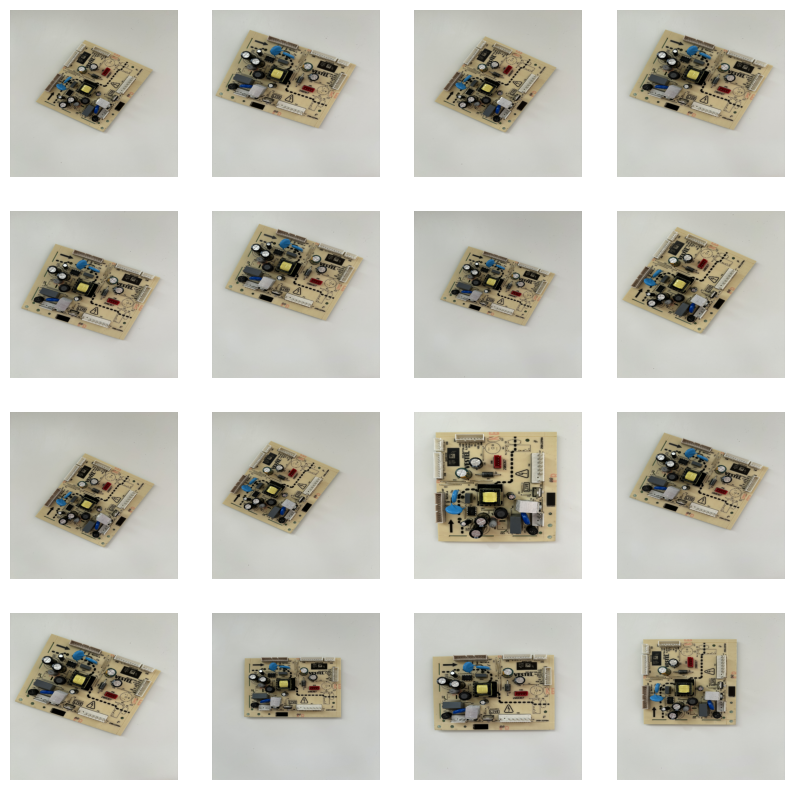

In [ ]:
image_batch, _ = next(iter(train_dataset))

fig = plt.figure(figsize=(10, 10))

for index, image in enumerate(image_batch):  # Get first batch
  plt.subplot(4, 4, index + 1)
  plt.imshow(image[:, :, :])
  plt.axis('off')
  if index >= 15:
    break

### Convolutional Autoencoder Architecture

based on "*Image Based Detection of Modifications in Assembled PCBs with Deep Convolutional Autoencoders*" literature.

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model

### Data Augmentation Layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, seed=None),
  tf.keras.layers.RandomContrast(0.2, seed=None)
  # tf.keras.layers.RandomCrop(256, 256, seed=None, **kwargs)
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
def conv_block(x, filters=16, kernel=5, stride=2, transpose=False, slope=experiment['LRELU_SLOPE'], padding='same'):
  conv = Conv2DTranspose if transpose else Conv2D

  x = conv(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=padding, use_bias=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(slope)(x)

  return x

In [ ]:
def create_encoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Autoencoder model input shape
        output_shape: Latent vector shape
    """
    with strategy.scope():
      n_leves_enc = 7
      n_dense = int(input_shape[0]/(2**n_leves_enc))

      inputs = Input(shape=input_shape, name='encoder_input')
      # Apply Data augmentation
      if experiment['DATA_AUG'] == True:
        inputs = data_augmentation(inputs)

      conv1 = conv_block(inputs, filters=32)
      conv2 = conv_block(conv1,  filters=64)
      conv3 = conv_block(conv2,  filters=128)
      conv4 = conv_block(conv3,  filters=128)
      conv5 = conv_block(conv4,  filters=256)
      conv6 = conv_block(conv5,  filters=256)
      conv7 = conv_block(conv6,  filters=256)

      conv7_flat = Flatten()(conv7)
      fc1 = Dense(units=(n_dense*n_dense*256))(conv7_flat)

      # Batch normalization
      fc1 = BatchNormalization()(fc1)
      # Add activation function Leaky ReLU
      fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

      fc2 = Dense(units=output_shape)(fc1)
      output_layer = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc2)

      model = Model(inputs, output_layer, name='Encoder_Model')
    if verbose > 0:
      model.summary()
    return model

In [ ]:
def create_decoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Latent vector shape
        output_shape: Autoencoder model input shape
    """
    with strategy.scope():
      n_leves_enc = 7
      n_dense = int(output_shape[0]/(2**n_leves_enc))

      inputs = Input(shape=input_shape, name='decoder_input')
      fc1 = Dense(units=(n_dense*n_dense*256))(inputs)
      fc1 = BatchNormalization()(fc1)
      fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

      z_mat = Reshape((n_dense, n_dense, 256))(fc1)

      # Transposed Convolution Layers
      dconv0 = conv_block(z_mat,  filters=256, transpose=True)
      dconv1 = conv_block(dconv0, filters=256, transpose=True)
      dconv2 = conv_block(dconv1, filters=128, transpose=True)
      dconv3 = conv_block(dconv2, filters=128, transpose=True)
      dconv4 = conv_block(dconv3, filters=64, transpose=True)
      dconv5 = conv_block(dconv4, filters=32, transpose=True)

      dconv6 = Conv2DTranspose(filters=output_shape[2], kernel_size=(5,5), strides=2, padding='same',
          use_bias=True, activation='sigmoid')(dconv5)

      model = Model(inputs, dconv6, name="Decoder_Model")
    if verbose > 0:
      model.summary()
    return model

### Create Autoencoder Model

In [ ]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'], output_shape=experiment['LATENT_DIM'], verbose=1)

Model: "Encoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                     

In [ ]:
latent_input = (experiment['LATENT_DIM'],)

In [ ]:
create_decoder_model(latent_input, output_shape=experiment['INPUT_SHAPE'], verbose=1)

Model: "Decoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 500)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              2052096   
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638656   
 nspose)                                             

In [ ]:
def create_autoencoder_model(input_shape, latent_dim_shape):
    with strategy.scope():
      inputs = Input(shape=input_shape, name='Autoencoder_input')

      enc_model = create_encoder_model(input_shape, latent_dim_shape, verbose=0)
      dec_model = create_decoder_model(latent_dim_shape, input_shape, verbose=0)

      latent_vector = enc_model(inputs)
      output = dec_model(latent_vector)

      model = Model(inputs, output, name="Autoencoder_Model")

    model.summary()
    return model

In [ ]:
autoencoder_model = create_autoencoder_model(experiment['INPUT_SHAPE'],
                                  latent_dim_shape=experiment['LATENT_DIM'])

Model: "Autoencoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Autoencoder_input (InputLay  [(None, 512, 512, 3)]    0         
 er)                                                             
                                                                 
 Encoder_Model (Functional)  (None, 500)               23615796  
                                                                 
 Decoder_Model (Functional)  (None, 512, 512, 3)       6836803   
                                                                 
Total params: 30,452,599
Trainable params: 30,432,247
Non-trainable params: 20,352
_________________________________________________________________


In [ ]:
def init_perceptual_loss(perp_layers=None, verbose=0):
  # Set perceptual model
  if experiment['PERCEP_LOSS_MODEL'] == 'VGG19':
    perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  else:
    perp_model = tf.keras.applications.VGG16(input_shape=(224,224,3))

  # Set perceptual loss output layers
  if perp_layers != None:
    modelOutputs = [perp_model.layers[i].output for i in perp_layers]
  else:
    modelOutputs = perp_model.layers[-2].output  # Get last layer of the model before prediction layer

  model = Model(perp_model.inputs, modelOutputs)
  if verbose > 0:
      model.summary()

  return model

In [ ]:
# vgg19_model = init_perceptual_loss([5,8,13,18], 1)

# print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
#  {vgg19_model.layers[5]}\n {vgg19_model.layers[8]}\n\
#  {vgg19_model.layers[13]}\n {vgg19_model.layers[18]}')

# vgg19_model = init_perceptual_loss(None, 1)
# print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
#  {vgg19_model.layers[-1]}')

### Loss Functions and Optimizer

In [ ]:
from keras import backend as K

def mse_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  return 1000 * r_loss

In [ ]:
def mae_loss(y_true, y_pred):
  r_loss = K.mean(K.abs(y_true - y_pred), axis = [1,2,3])
  return 1000 * r_loss

In [ ]:
def kl_loss(mean, log_var):
  kl_loss_result =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
  return kl_loss_result

In [ ]:
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
def adversarial_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.math.log(y_pred + 1e-8))

### MSE Perceptual Loss

Perceptual Loss

In short, the perceptual loss function works by `summing` all the `squared errors` between all the `pixels` and `taking the mean`. This is in contrast to a `per-pixel loss function` which sums all the absolute errors between pixels.


[What is a Perceptual Loss Function?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)

[Johnson et al. (2016)](https://arxiv.org/pdf/1603.08155.pdf%7C)

In [ ]:
class MSE_Perceptual(tf.keras.losses.Loss):
  def __init__(self, perc_layers=None, lambda_mse=0.01, lambda_perc=1, perc_loss=False):
    super(MSE_Perceptual, self).__init__()
    self.loss = None
    self.perc_layers = perc_layers
    self.lambda_mse = lambda_mse
    self.perc_loss = perc_loss
    self.lambda_perc = lambda_perc
    with strategy.scope():  # TPU
      self.perc_model = init_perceptual_loss(self.perc_layers)
      self.loss_fn = tf.keras.losses.mean_squared_error

  def call(self, y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(tf.math.pow(y_pred,2) - tf.math.pow(y_true,2)))

    if self.perc_loss == True:
        perceptual_loss = []

        y_true_reshape = tf.image.resize(y_true, (224, 224))
        y_pred_reshape = tf.image.resize(y_pred, (224, 224))

        y_true_output = self.perc_model(y_true_reshape)
        y_pred_output = self.perc_model(y_pred_reshape)

        if self.perc_layers != None:
            # Add losses for every perceptual layer output
            for idx, (y_true_layer, y_pred_layer) in enumerate(zip(y_true_output, y_pred_output)):
                  # Output (Layer 5): (8, 112, 112, 128)
                  # Output (Layer 8): (8, 56, 56, 256)
                  # Output (Layer 13): (8, 28, 28, 512)
                  # Output (Layer 18): (8, 14, 14, 512)
                  # y_pred_layer[0].shape = (112, 112, 128) for Layer 5
                  w, h, d = y_pred_layer[0].shape
                  perceptual_loss.append((1/(w*h*d))*tf.reduce_mean(tf.square(y_true_layer - y_pred_layer)))
                  #perceptual_loss.append((1/(w*h*d))*tf.reduce_sum(tf.square(y_true_layer - y_pred_layer)))
        else:
            # Last layer of the backbone, flatten layer
            # y_pred_layer.shape: (4096,) => y_pred_layer.shape[0]: 4096
            perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_mean(tf.square(y_true_output - y_pred_output)))
            # perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_sum(tf.square(y_true_output - y_pred_output)))

    self.loss = self.lambda_mse*mse_loss
    if self.perc_loss == True:
        self.loss += self.lambda_perc*tf.reduce_sum(perceptual_loss)

    return self.loss

### Create Loss Function

In [ ]:
if (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
  loss_fn = MSE_Perceptual(experiment['PERCEPTUAL_LAYERS'], experiment['MSE_LOSS_LAMBDA'], experiment['PERP_LOSS_LAMBDA'], perc_loss=True)
else:
  loss_fn = MSE_Perceptual(lambda_mse=experiment['MSE_LOSS_LAMBDA'])

In [ ]:
from glob import glob

training_files = glob(BD67_NORMAL_FRONT_PATH + "/*.JPG")
print(f"Number of normal BD67-PCB front side photos: {len(training_files)}")

Number of normal BD67-PCB front side photos: 124


In [ ]:
from sklearn.model_selection import train_test_split

training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['VALID_SIZE'], random_state=100)

print(f"Number of Training Images: {len(training_files)}")
print(f"Number of Validation Images: {len(valid_files)}")

Number of Training Images: 111
Number of Validation Images: 13


In [ ]:
import math

training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['VALID_SIZE'])

train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of training batches:    3
Number of validation batches:  1


### Learning Rate Decay

In [ ]:
import math

LR_START = 1e-5
LR_MIN = 1e-5
#LR_MAX = 9e-4 * strategy.num_replicas_in_sync
LR_MAX = 9e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = 0.5
EPOCHS = experiment['EPOCHS']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
    lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
    if LR_MIN is not None:
      lr = tf.math.maximum(LR_MIN, lr)

  return lr

### Training Callbacks

In [ ]:
lr_callback2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=f"{experiment['TRAINING_WEIGHT_DIR']}/best_model_val_loss.h5", monitor='val_loss', save_best_only=True)

In [ ]:
STEPS_PER_EPOCH = len(training_files) // experiment['BATCH_SIZE']
STEPS_PER_VAL = len(valid_files) // experiment['BATCH_SIZE']

In [ ]:
if experiment['TYPE'] == 'train':
    if (experiment['RECONS_LOSS'] == 'MSE') or (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
      with strategy.scope():
        autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              # Anything between 2 and `steps_per_epoch` could help here.
                              steps_per_execution = 50,
                              loss=loss_fn,
                              metrics=['mae', 'mse'])
    elif experiment['RECONS_LOSS'] == 'SSIM':
      with strategy.scope():
        autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              steps_per_execution = 50,
                              loss=ssim_loss,
                              metrics=['mae', 'mse'])

In [ ]:
if experiment['TYPE'] == 'train':
    autoencoder_model_hist = autoencoder_model.fit(
        train_dataset_part,
        validation_data=valid_dataset_part,
        epochs=experiment['EPOCHS'],
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback2, cp],
        validation_steps=STEPS_PER_VAL
      )


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.2467 - mse: 0.0767

3/3 [==============================] - 46s 15s/step - loss: 0.0010 - mae: 0.2467 - mse: 0.0767 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.0003066666666666667.
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 9.8666e-04 - mae: 0.2431 - mse: 0.0749

3/3 [==============================] - 2s 601ms/step - loss: 9.8666e-04 - mae: 0.2431 - mse: 0.0749 - lr: 3.0667e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006033333333333333.
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 8.9638e-04 - mae: 0.2290 - mse: 0.0680

3/3 [==============================] - 2s 628ms/step - loss: 8.9638e-04 - mae: 0.2290 - mse: 0.0680 - lr: 6.0333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008999999845400453.
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 7.4983e-04 - mae: 0.2048 - mse: 0.0577

3/3 [==============================] - 2s 649ms/step - loss: 7.4983e-04 - mae: 0.2048 - mse: 0.0577 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0008999977144412696.
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 5.8586e-04 - mae: 0.1754 - mse: 0.0466

3/3 [==============================] - 2s 780ms/step - loss: 5.8586e-04 - mae: 0.1754 - mse: 0.0466 - lr: 9.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0008999910787679255.
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 4.5723e-04 - mae: 0.1514 - mse: 0.0379

3/3 [==============================] - 2s 564ms/step - loss: 4.5723e-04 - mae: 0.1514 - mse: 0.0379 - lr: 8.9999e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0008999798446893692.
Epoch 7/1000
3/3 [==============================] - ETA: 0s - loss: 3.5537e-04 - mae: 0.1312 - mse: 0.0315

3/3 [==============================] - 2s 585ms/step - loss: 3.5537e-04 - mae: 0.1312 - mse: 0.0315 - lr: 8.9998e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0008999642450362444.
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 2.7495e-04 - mae: 0.1141 - mse: 0.0265

3/3 [==============================] - 2s 572ms/step - loss: 2.7495e-04 - mae: 0.1141 - mse: 0.0265 - lr: 8.9996e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0008999441633932292.
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 2.1468e-04 - mae: 0.0998 - mse: 0.0223

3/3 [==============================] - 2s 653ms/step - loss: 2.1468e-04 - mae: 0.0998 - mse: 0.0223 - lr: 8.9994e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0008999195997603238.
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 1.9157e-04 - mae: 0.0923 - mse: 0.0206

3/3 [==============================] - 2s 653ms/step - loss: 1.9157e-04 - mae: 0.0923 - mse: 0.0206 - lr: 8.9992e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0008998905541375279.
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 1.8223e-04 - mae: 0.0885 - mse: 0.0199

3/3 [==============================] - 2s 621ms/step - loss: 1.8223e-04 - mae: 0.0885 - mse: 0.0199 - lr: 8.9989e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0008998570265248418.
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 1.7439e-04 - mae: 0.0858 - mse: 0.0197

3/3 [==============================] - 2s 580ms/step - loss: 1.7439e-04 - mae: 0.0858 - mse: 0.0197 - lr: 8.9986e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0008998190169222653.
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 1.6075e-04 - mae: 0.0827 - mse: 0.0188

3/3 [==============================] - 2s 574ms/step - loss: 1.6075e-04 - mae: 0.0827 - mse: 0.0188 - lr: 8.9982e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0008997765835374594.
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 1.4621e-04 - mae: 0.0791 - mse: 0.0175

3/3 [==============================] - 2s 596ms/step - loss: 1.4621e-04 - mae: 0.0791 - mse: 0.0175 - lr: 8.9978e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.000899729726370424.
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 1.3297e-04 - mae: 0.0755 - mse: 0.0160

3/3 [==============================] - 2s 583ms/step - loss: 1.3297e-04 - mae: 0.0755 - mse: 0.0160 - lr: 8.9973e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0008996783290058374.
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 1.2258e-04 - mae: 0.0725 - mse: 0.0150

3/3 [==============================] - 2s 643ms/step - loss: 1.2258e-04 - mae: 0.0725 - mse: 0.0150 - lr: 8.9968e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0008996225078590214.
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 1.1676e-04 - mae: 0.0704 - mse: 0.0143

3/3 [==============================] - 2s 655ms/step - loss: 1.1676e-04 - mae: 0.0704 - mse: 0.0143 - lr: 8.9962e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0008995622047223151.
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 1.1307e-04 - mae: 0.0695 - mse: 0.0142

3/3 [==============================] - 2s 796ms/step - loss: 1.1307e-04 - mae: 0.0695 - mse: 0.0142 - lr: 8.9956e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0008994974195957184.
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 1.0963e-04 - mae: 0.0682 - mse: 0.0137

3/3 [==============================] - 2s 557ms/step - loss: 1.0963e-04 - mae: 0.0682 - mse: 0.0137 - lr: 8.9950e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0008994282106868923.
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 1.0449e-04 - mae: 0.0670 - mse: 0.0134

3/3 [==============================] - 2s 744ms/step - loss: 1.0449e-04 - mae: 0.0670 - mse: 0.0134 - lr: 8.9943e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0008993545197881758.
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 9.9613e-05 - mae: 0.0652 - mse: 0.0129

3/3 [==============================] - 3s 1s/step - loss: 9.9613e-05 - mae: 0.0652 - mse: 0.0129 - lr: 8.9935e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.000899276346899569.
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 9.5401e-05 - mae: 0.0639 - mse: 0.0126

3/3 [==============================] - 3s 1s/step - loss: 9.5401e-05 - mae: 0.0639 - mse: 0.0126 - lr: 8.9928e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008991936920210719.
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 9.2615e-05 - mae: 0.0628 - mse: 0.0123

3/3 [==============================] - 3s 855ms/step - loss: 9.2615e-05 - mae: 0.0628 - mse: 0.0123 - lr: 8.9919e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008991067297756672.
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 8.9837e-05 - mae: 0.0617 - mse: 0.0120

3/3 [==============================] - 2s 783ms/step - loss: 8.9837e-05 - mae: 0.0617 - mse: 0.0120 - lr: 8.9911e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008990151109173894.
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 8.7597e-05 - mae: 0.0608 - mse: 0.0118

3/3 [==============================] - 3s 843ms/step - loss: 8.7597e-05 - mae: 0.0608 - mse: 0.0118 - lr: 8.9902e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.000898919184692204.
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 8.5631e-05 - mae: 0.0599 - mse: 0.0116

3/3 [==============================] - 3s 1s/step - loss: 8.5631e-05 - mae: 0.0599 - mse: 0.0116 - lr: 8.9892e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0008988186600618064.
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 8.3912e-05 - mae: 0.0593 - mse: 0.0115

3/3 [==============================] - 2s 609ms/step - loss: 8.3912e-05 - mae: 0.0593 - mse: 0.0115 - lr: 8.9882e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0008987138280645013.
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 8.2367e-05 - mae: 0.0586 - mse: 0.0113

3/3 [==============================] - 2s 569ms/step - loss: 8.2367e-05 - mae: 0.0586 - mse: 0.0113 - lr: 8.9871e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0008986044558696449.
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 8.1037e-05 - mae: 0.0580 - mse: 0.0112

3/3 [==============================] - 2s 567ms/step - loss: 8.1037e-05 - mae: 0.0580 - mse: 0.0112 - lr: 8.9860e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.000898490659892559.
Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 7.9900e-05 - mae: 0.0575 - mse: 0.0111

3/3 [==============================] - 2s 785ms/step - loss: 7.9900e-05 - mae: 0.0575 - mse: 0.0111 - lr: 8.9849e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.000898372323717922.
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 7.9133e-05 - mae: 0.0570 - mse: 0.0110

3/3 [==============================] - 2s 615ms/step - loss: 7.9133e-05 - mae: 0.0570 - mse: 0.0110 - lr: 8.9837e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0008982496219687164.
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 7.8067e-05 - mae: 0.0566 - mse: 0.0109

3/3 [==============================] - 2s 644ms/step - loss: 7.8067e-05 - mae: 0.0566 - mse: 0.0109 - lr: 8.9825e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0008981224382296205.
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 7.7506e-05 - mae: 0.0562 - mse: 0.0109

3/3 [==============================] - 2s 649ms/step - loss: 7.7506e-05 - mae: 0.0562 - mse: 0.0109 - lr: 8.9812e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0008979908307082951.
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 7.6743e-05 - mae: 0.0559 - mse: 0.0108

3/3 [==============================] - 2s 578ms/step - loss: 7.6743e-05 - mae: 0.0559 - mse: 0.0108 - lr: 8.9799e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0008978547411970794.
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 7.6114e-05 - mae: 0.0554 - mse: 0.0107

3/3 [==============================] - 2s 563ms/step - loss: 7.6114e-05 - mae: 0.0554 - mse: 0.0107 - lr: 8.9785e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0008977142861112952.
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 7.5022e-05 - mae: 0.0552 - mse: 0.0106

3/3 [==============================] - 2s 569ms/step - loss: 7.5022e-05 - mae: 0.0552 - mse: 0.0106 - lr: 8.9771e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0008975692908279598.
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 7.3779e-05 - mae: 0.0545 - mse: 0.0105

3/3 [==============================] - 2s 580ms/step - loss: 7.3779e-05 - mae: 0.0545 - mse: 0.0105 - lr: 8.9757e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0008974199299700558.
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 7.2972e-05 - mae: 0.0542 - mse: 0.0104

3/3 [==============================] - 2s 633ms/step - loss: 7.2972e-05 - mae: 0.0542 - mse: 0.0104 - lr: 8.9742e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0008972660871222615.
Epoch 39/1000
3/3 [==============================] - ETA: 0s - loss: 7.1740e-05 - mae: 0.0537 - mse: 0.0103

3/3 [==============================] - 2s 660ms/step - loss: 7.1740e-05 - mae: 0.0537 - mse: 0.0103 - lr: 8.9727e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0008971077622845769.
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 7.0572e-05 - mae: 0.0532 - mse: 0.0102

3/3 [==============================] - 2s 572ms/step - loss: 7.0572e-05 - mae: 0.0532 - mse: 0.0102 - lr: 8.9711e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008969450718723238.
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 6.9868e-05 - mae: 0.0529 - mse: 0.0101

3/3 [==============================] - 2s 571ms/step - loss: 6.9868e-05 - mae: 0.0529 - mse: 0.0101 - lr: 8.9695e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0008967778994701803.
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 6.8793e-05 - mae: 0.0524 - mse: 0.0100

3/3 [==============================] - 2s 582ms/step - loss: 6.8793e-05 - mae: 0.0524 - mse: 0.0100 - lr: 8.9678e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0008966062450781465.
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 6.8182e-05 - mae: 0.0520 - mse: 0.0099

3/3 [==============================] - 2s 566ms/step - loss: 6.8182e-05 - mae: 0.0520 - mse: 0.0099 - lr: 8.9661e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0008964302251115441.
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 6.7071e-05 - mae: 0.0516 - mse: 0.0098

3/3 [==============================] - 3s 936ms/step - loss: 6.7071e-05 - mae: 0.0516 - mse: 0.0098 - lr: 8.9643e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0008962497813627124.
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 6.6207e-05 - mae: 0.0511 - mse: 0.0097

3/3 [==============================] - 2s 679ms/step - loss: 6.6207e-05 - mae: 0.0511 - mse: 0.0097 - lr: 8.9625e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0008960648556239903.
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 6.5468e-05 - mae: 0.0509 - mse: 0.0096

3/3 [==============================] - 2s 560ms/step - loss: 6.5468e-05 - mae: 0.0509 - mse: 0.0096 - lr: 8.9606e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0008958755643106997.
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 6.4595e-05 - mae: 0.0504 - mse: 0.0096

3/3 [==============================] - 2s 592ms/step - loss: 6.4595e-05 - mae: 0.0504 - mse: 0.0096 - lr: 8.9588e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0008956817910075188.
Epoch 48/1000
3/3 [==============================] - ETA: 0s - loss: 6.3895e-05 - mae: 0.0501 - mse: 0.0095

3/3 [==============================] - 2s 570ms/step - loss: 6.3895e-05 - mae: 0.0501 - mse: 0.0095 - lr: 8.9568e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0008954836521297693.
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 6.3046e-05 - mae: 0.0498 - mse: 0.0094

3/3 [==============================] - 2s 587ms/step - loss: 6.3046e-05 - mae: 0.0498 - mse: 0.0094 - lr: 8.9548e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0008952810312621295.
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 6.2564e-05 - mae: 0.0495 - mse: 0.0094

3/3 [==============================] - 2s 646ms/step - loss: 6.2564e-05 - mae: 0.0495 - mse: 0.0094 - lr: 8.9528e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0008950739866122603.
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 6.2008e-05 - mae: 0.0492 - mse: 0.0093

3/3 [==============================] - 2s 668ms/step - loss: 6.2008e-05 - mae: 0.0492 - mse: 0.0093 - lr: 8.9507e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0008948625763878226.
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 6.2001e-05 - mae: 0.0493 - mse: 0.0092

3/3 [==============================] - 2s 589ms/step - loss: 6.2001e-05 - mae: 0.0493 - mse: 0.0092 - lr: 8.9486e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0008946467423811555.
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 6.1926e-05 - mae: 0.0490 - mse: 0.0092

3/3 [==============================] - 2s 575ms/step - loss: 6.1926e-05 - mae: 0.0490 - mse: 0.0092 - lr: 8.9465e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.000894426426384598.
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 6.1263e-05 - mae: 0.0489 - mse: 0.0092

3/3 [==============================] - 2s 586ms/step - loss: 6.1263e-05 - mae: 0.0489 - mse: 0.0092 - lr: 8.9443e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0008942016866058111.
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 6.1204e-05 - mae: 0.0489 - mse: 0.0091

3/3 [==============================] - 2s 590ms/step - loss: 6.1204e-05 - mae: 0.0489 - mse: 0.0091 - lr: 8.9420e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0008939726394601166.
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 6.0197e-05 - mae: 0.0484 - mse: 0.0091

3/3 [==============================] - 2s 598ms/step - loss: 6.0197e-05 - mae: 0.0484 - mse: 0.0091 - lr: 8.9397e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0008937391103245318.
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 5.9949e-05 - mae: 0.0484 - mse: 0.0090

3/3 [==============================] - 2s 651ms/step - loss: 5.9949e-05 - mae: 0.0484 - mse: 0.0090 - lr: 8.9374e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0008935012156143785.
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 5.9707e-05 - mae: 0.0482 - mse: 0.0090

3/3 [==============================] - 2s 633ms/step - loss: 5.9707e-05 - mae: 0.0482 - mse: 0.0090 - lr: 8.9350e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0008932588971219957.
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 5.9046e-05 - mae: 0.0480 - mse: 0.0089

3/3 [==============================] - 2s 597ms/step - loss: 5.9046e-05 - mae: 0.0480 - mse: 0.0089 - lr: 8.9326e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0008930122130550444.
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 5.8603e-05 - mae: 0.0478 - mse: 0.0089

3/3 [==============================] - 2s 813ms/step - loss: 5.8603e-05 - mae: 0.0478 - mse: 0.0089 - lr: 8.9301e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.0008927610469982028.
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 5.7882e-05 - mae: 0.0475 - mse: 0.0087

3/3 [==============================] - 2s 587ms/step - loss: 5.7882e-05 - mae: 0.0475 - mse: 0.0087 - lr: 8.9276e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0008925055735744536.
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 5.6768e-05 - mae: 0.0469 - mse: 0.0087

3/3 [==============================] - 2s 626ms/step - loss: 5.6768e-05 - mae: 0.0469 - mse: 0.0087 - lr: 8.9251e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.000892245618160814.
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 5.6122e-05 - mae: 0.0466 - mse: 0.0086

3/3 [==============================] - 2s 639ms/step - loss: 5.6122e-05 - mae: 0.0466 - mse: 0.0086 - lr: 8.9225e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0008919813553802669.
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 5.5671e-05 - mae: 0.0465 - mse: 0.0085

3/3 [==============================] - 2s 628ms/step - loss: 5.5671e-05 - mae: 0.0465 - mse: 0.0085 - lr: 8.9198e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0008917126688174903.
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 5.5204e-05 - mae: 0.0461 - mse: 0.0085

3/3 [==============================] - 2s 563ms/step - loss: 5.5204e-05 - mae: 0.0461 - mse: 0.0085 - lr: 8.9171e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0008914396166801453.
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 5.4645e-05 - mae: 0.0461 - mse: 0.0084

3/3 [==============================] - 2s 579ms/step - loss: 5.4645e-05 - mae: 0.0461 - mse: 0.0084 - lr: 8.9144e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0008911620825529099.
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 5.4273e-05 - mae: 0.0457 - mse: 0.0083

3/3 [==============================] - 2s 555ms/step - loss: 5.4273e-05 - mae: 0.0457 - mse: 0.0083 - lr: 8.9116e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0008908802992664278.
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 5.4188e-05 - mae: 0.0459 - mse: 0.0083

3/3 [==============================] - 2s 590ms/step - loss: 5.4188e-05 - mae: 0.0459 - mse: 0.0083 - lr: 8.9088e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0008905941504053771.
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 5.3933e-05 - mae: 0.0457 - mse: 0.0082

3/3 [==============================] - 2s 634ms/step - loss: 5.3933e-05 - mae: 0.0457 - mse: 0.0082 - lr: 8.9059e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0008903034613467753.
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 5.4213e-05 - mae: 0.0459 - mse: 0.0083

3/3 [==============================] - 3s 937ms/step - loss: 5.4213e-05 - mae: 0.0459 - mse: 0.0083 - lr: 8.9030e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0008900085231289268.
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 5.3753e-05 - mae: 0.0456 - mse: 0.0082

3/3 [==============================] - 2s 579ms/step - loss: 5.3753e-05 - mae: 0.0456 - mse: 0.0082 - lr: 8.9001e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.0008897092193365097.
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 5.3771e-05 - mae: 0.0458 - mse: 0.0082

3/3 [==============================] - 2s 572ms/step - loss: 5.3771e-05 - mae: 0.0458 - mse: 0.0082 - lr: 8.8971e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0008894055499695241.
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 5.2695e-05 - mae: 0.0451 - mse: 0.0081

3/3 [==============================] - 2s 567ms/step - loss: 5.2695e-05 - mae: 0.0451 - mse: 0.0081 - lr: 8.8941e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.0008890974568203092.
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 5.2169e-05 - mae: 0.0449 - mse: 0.0081

3/3 [==============================] - 2s 564ms/step - loss: 5.2169e-05 - mae: 0.0449 - mse: 0.0081 - lr: 8.8910e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0008887849980965257.
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 5.1853e-05 - mae: 0.0448 - mse: 0.0080

3/3 [==============================] - 2s 634ms/step - loss: 5.1853e-05 - mae: 0.0448 - mse: 0.0080 - lr: 8.8878e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0008884682902134955.
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 5.1369e-05 - mae: 0.0447 - mse: 0.0079

3/3 [==============================] - 2s 633ms/step - loss: 5.1369e-05 - mae: 0.0447 - mse: 0.0079 - lr: 8.8847e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0008881472167558968.
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 5.2423e-05 - mae: 0.0451 - mse: 0.0081

3/3 [==============================] - 2s 564ms/step - loss: 5.2423e-05 - mae: 0.0451 - mse: 0.0081 - lr: 8.8815e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0008878216613084078.
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 5.1016e-05 - mae: 0.0446 - mse: 0.0079

3/3 [==============================] - 2s 557ms/step - loss: 5.1016e-05 - mae: 0.0446 - mse: 0.0079 - lr: 8.8782e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0008874918567016721.
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 5.1427e-05 - mae: 0.0445 - mse: 0.0079

3/3 [==============================] - 2s 570ms/step - loss: 5.1427e-05 - mae: 0.0445 - mse: 0.0079 - lr: 8.8749e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0008871576865203679.
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 5.0214e-05 - mae: 0.0442 - mse: 0.0078

3/3 [==============================] - 2s 564ms/step - loss: 5.0214e-05 - mae: 0.0442 - mse: 0.0078 - lr: 8.8716e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.000886819208972156.
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 4.9562e-05 - mae: 0.0438 - mse: 0.0078

3/3 [==============================] - 2s 622ms/step - loss: 4.9562e-05 - mae: 0.0438 - mse: 0.0078 - lr: 8.8682e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0008864763658493757.
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 4.8815e-05 - mae: 0.0434 - mse: 0.0077

3/3 [==============================] - 3s 938ms/step - loss: 4.8815e-05 - mae: 0.0434 - mse: 0.0077 - lr: 8.8648e-04

Epoch 83: LearningRateScheduler setting learning rate to 0.0008861291571520269.
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 4.8388e-05 - mae: 0.0432 - mse: 0.0076

3/3 [==============================] - 2s 574ms/step - loss: 4.8388e-05 - mae: 0.0432 - mse: 0.0076 - lr: 8.8613e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.0008857776410877705.
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 4.8016e-05 - mae: 0.0430 - mse: 0.0075

3/3 [==============================] - 2s 567ms/step - loss: 4.8016e-05 - mae: 0.0430 - mse: 0.0075 - lr: 8.8578e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0008854218176566064.
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 4.7618e-05 - mae: 0.0428 - mse: 0.0075

3/3 [==============================] - 2s 586ms/step - loss: 4.7618e-05 - mae: 0.0428 - mse: 0.0075 - lr: 8.8542e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0008850616868585348.
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 4.7195e-05 - mae: 0.0427 - mse: 0.0074

3/3 [==============================] - 2s 569ms/step - loss: 4.7195e-05 - mae: 0.0427 - mse: 0.0074 - lr: 8.8506e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.0008846971904858947.
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 4.6740e-05 - mae: 0.0424 - mse: 0.0074

3/3 [==============================] - 2s 635ms/step - loss: 4.6740e-05 - mae: 0.0424 - mse: 0.0074 - lr: 8.8470e-04

Epoch 88: LearningRateScheduler setting learning rate to 0.000884328386746347.
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 4.6248e-05 - mae: 0.0422 - mse: 0.0073

3/3 [==============================] - 2s 718ms/step - loss: 4.6248e-05 - mae: 0.0422 - mse: 0.0073 - lr: 8.8433e-04

Epoch 89: LearningRateScheduler setting learning rate to 0.0008839552756398916.
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 4.5863e-05 - mae: 0.0419 - mse: 0.0073

3/3 [==============================] - 4s 1s/step - loss: 4.5863e-05 - mae: 0.0419 - mse: 0.0073 - lr: 8.8396e-04

Epoch 90: LearningRateScheduler setting learning rate to 0.0008835779153741896.
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 4.5384e-05 - mae: 0.0418 - mse: 0.0072

3/3 [==============================] - 2s 581ms/step - loss: 4.5384e-05 - mae: 0.0418 - mse: 0.0072 - lr: 8.8358e-04

Epoch 91: LearningRateScheduler setting learning rate to 0.0008831961313262582.
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 4.5023e-05 - mae: 0.0415 - mse: 0.0072

3/3 [==============================] - 2s 575ms/step - loss: 4.5023e-05 - mae: 0.0415 - mse: 0.0072 - lr: 8.8320e-04

Epoch 92: LearningRateScheduler setting learning rate to 0.000882810156326741.
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 4.4759e-05 - mae: 0.0415 - mse: 0.0071

3/3 [==============================] - 2s 562ms/step - loss: 4.4759e-05 - mae: 0.0415 - mse: 0.0071 - lr: 8.8281e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0008824198157526553.
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 4.4366e-05 - mae: 0.0412 - mse: 0.0071

3/3 [==============================] - 2s 560ms/step - loss: 4.4366e-05 - mae: 0.0412 - mse: 0.0071 - lr: 8.8242e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.000882025167811662.
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 4.4368e-05 - mae: 0.0414 - mse: 0.0070

3/3 [==============================] - 2s 633ms/step - loss: 4.4368e-05 - mae: 0.0414 - mse: 0.0070 - lr: 8.8203e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.000881626270711422.
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 4.3868e-05 - mae: 0.0410 - mse: 0.0071

3/3 [==============================] - 3s 975ms/step - loss: 4.3868e-05 - mae: 0.0410 - mse: 0.0071 - lr: 8.8163e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.0008812230662442744.
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 4.3960e-05 - mae: 0.0413 - mse: 0.0069

3/3 [==============================] - 2s 589ms/step - loss: 4.3960e-05 - mae: 0.0413 - mse: 0.0069 - lr: 8.8122e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.000880815670825541.
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 4.3378e-05 - mae: 0.0408 - mse: 0.0070

3/3 [==============================] - 2s 590ms/step - loss: 4.3378e-05 - mae: 0.0408 - mse: 0.0070 - lr: 8.8082e-04

Epoch 98: LearningRateScheduler setting learning rate to 0.0008804038516245782.
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 4.3637e-05 - mae: 0.0412 - mse: 0.0069

3/3 [==============================] - 2s 575ms/step - loss: 4.3637e-05 - mae: 0.0412 - mse: 0.0069 - lr: 8.8040e-04

Epoch 99: LearningRateScheduler setting learning rate to 0.0008799877832643688.
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 4.3049e-05 - mae: 0.0407 - mse: 0.0070

3/3 [==============================] - 2s 561ms/step - loss: 4.3049e-05 - mae: 0.0407 - mse: 0.0070 - lr: 8.7999e-04

Epoch 100: LearningRateScheduler setting learning rate to 0.0008795675821602345.
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 4.3342e-05 - mae: 0.0410 - mse: 0.0068

3/3 [==============================] - 2s 628ms/step - loss: 4.3342e-05 - mae: 0.0410 - mse: 0.0068 - lr: 8.7957e-04

Epoch 101: LearningRateScheduler setting learning rate to 0.0008791430154815316.
Epoch 101/1000
3/3 [==============================] - ETA: 0s - loss: 4.2260e-05 - mae: 0.0402 - mse: 0.0069

3/3 [==============================] - 2s 633ms/step - loss: 4.2260e-05 - mae: 0.0402 - mse: 0.0069 - lr: 8.7914e-04

Epoch 102: LearningRateScheduler setting learning rate to 0.0008787141996435821.
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 4.2045e-05 - mae: 0.0402 - mse: 0.0068

3/3 [==============================] - 2s 589ms/step - loss: 4.2045e-05 - mae: 0.0402 - mse: 0.0068 - lr: 8.7871e-04

Epoch 103: LearningRateScheduler setting learning rate to 0.000878281076438725.
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 4.1390e-05 - mae: 0.0399 - mse: 0.0067

3/3 [==============================] - 2s 570ms/step - loss: 4.1390e-05 - mae: 0.0399 - mse: 0.0067 - lr: 8.7828e-04

Epoch 104: LearningRateScheduler setting learning rate to 0.0008778437622822821.
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 4.1134e-05 - mae: 0.0397 - mse: 0.0067

3/3 [==============================] - 2s 592ms/step - loss: 4.1134e-05 - mae: 0.0397 - mse: 0.0067 - lr: 8.7784e-04

Epoch 105: LearningRateScheduler setting learning rate to 0.0008774021407589316.
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 4.0462e-05 - mae: 0.0395 - mse: 0.0066

3/3 [==============================] - 2s 682ms/step - loss: 4.0462e-05 - mae: 0.0395 - mse: 0.0066 - lr: 8.7740e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0008769563864916563.
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 4.0034e-05 - mae: 0.0390 - mse: 0.0066

3/3 [==============================] - 2s 648ms/step - loss: 4.0034e-05 - mae: 0.0390 - mse: 0.0066 - lr: 8.7696e-04

Epoch 107: LearningRateScheduler setting learning rate to 0.0008765063248574734.
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 3.9826e-05 - mae: 0.0391 - mse: 0.0065

3/3 [==============================] - 2s 647ms/step - loss: 3.9826e-05 - mae: 0.0391 - mse: 0.0065 - lr: 8.7651e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0008760520140640438.
Epoch 108/1000
3/3 [==============================] - ETA: 0s - loss: 3.9560e-05 - mae: 0.0389 - mse: 0.0066

3/3 [==============================] - 2s 652ms/step - loss: 3.9560e-05 - mae: 0.0389 - mse: 0.0066 - lr: 8.7605e-04

Epoch 109: LearningRateScheduler setting learning rate to 0.0008755935123190284.
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 3.9900e-05 - mae: 0.0392 - mse: 0.0064

3/3 [==============================] - 2s 812ms/step - loss: 3.9900e-05 - mae: 0.0392 - mse: 0.0064 - lr: 8.7559e-04

Epoch 110: LearningRateScheduler setting learning rate to 0.0008751307614147663.
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 3.9203e-05 - mae: 0.0387 - mse: 0.0065

3/3 [==============================] - 2s 589ms/step - loss: 3.9203e-05 - mae: 0.0387 - mse: 0.0065 - lr: 8.7513e-04

Epoch 111: LearningRateScheduler setting learning rate to 0.0008746637613512576.
Epoch 111/1000
3/3 [==============================] - ETA: 0s - loss: 3.9270e-05 - mae: 0.0388 - mse: 0.0064

3/3 [==============================] - 2s 562ms/step - loss: 3.9270e-05 - mae: 0.0388 - mse: 0.0064 - lr: 8.7466e-04

Epoch 112: LearningRateScheduler setting learning rate to 0.000874192628543824.
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 3.8651e-05 - mae: 0.0385 - mse: 0.0064

3/3 [==============================] - 2s 625ms/step - loss: 3.8651e-05 - mae: 0.0385 - mse: 0.0064 - lr: 8.7419e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.0008737172465771437.
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 3.8781e-05 - mae: 0.0384 - mse: 0.0064

3/3 [==============================] - 2s 644ms/step - loss: 3.8781e-05 - mae: 0.0384 - mse: 0.0064 - lr: 8.7372e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0008732376154512167.
Epoch 114/1000
3/3 [==============================] - ETA: 0s - loss: 3.9180e-05 - mae: 0.0386 - mse: 0.0064

3/3 [==============================] - 2s 643ms/step - loss: 3.9180e-05 - mae: 0.0386 - mse: 0.0064 - lr: 8.7324e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.000872753793373704.
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 3.8993e-05 - mae: 0.0385 - mse: 0.0064

3/3 [==============================] - 2s 576ms/step - loss: 3.8993e-05 - mae: 0.0385 - mse: 0.0064 - lr: 8.7275e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.0008722657803446054.
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 3.8893e-05 - mae: 0.0384 - mse: 0.0064

3/3 [==============================] - 2s 571ms/step - loss: 3.8893e-05 - mae: 0.0384 - mse: 0.0064 - lr: 8.7227e-04

Epoch 117: LearningRateScheduler setting learning rate to 0.0008717735763639212.
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 3.9313e-05 - mae: 0.0385 - mse: 0.0065

3/3 [==============================] - 2s 571ms/step - loss: 3.9313e-05 - mae: 0.0385 - mse: 0.0065 - lr: 8.7177e-04

Epoch 118: LearningRateScheduler setting learning rate to 0.0008712771814316511.
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 3.7940e-05 - mae: 0.0379 - mse: 0.0063

3/3 [==============================] - 2s 552ms/step - loss: 3.7940e-05 - mae: 0.0379 - mse: 0.0063 - lr: 8.7128e-04

Epoch 119: LearningRateScheduler setting learning rate to 0.0008707765955477953.
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 3.7529e-05 - mae: 0.0377 - mse: 0.0063

3/3 [==============================] - 2s 632ms/step - loss: 3.7529e-05 - mae: 0.0377 - mse: 0.0063 - lr: 8.7078e-04

Epoch 120: LearningRateScheduler setting learning rate to 0.0008702718769200146.
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 3.7747e-05 - mae: 0.0380 - mse: 0.0062

3/3 [==============================] - 2s 645ms/step - loss: 3.7747e-05 - mae: 0.0380 - mse: 0.0062 - lr: 8.7027e-04

Epoch 121: LearningRateScheduler setting learning rate to 0.0008697629673406482.
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 3.7115e-05 - mae: 0.0376 - mse: 0.0063

3/3 [==============================] - 2s 572ms/step - loss: 3.7115e-05 - mae: 0.0376 - mse: 0.0063 - lr: 8.6976e-04

Epoch 122: LearningRateScheduler setting learning rate to 0.000869249866809696.
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 3.6920e-05 - mae: 0.0375 - mse: 0.0062

3/3 [==============================] - 2s 564ms/step - loss: 3.6920e-05 - mae: 0.0375 - mse: 0.0062 - lr: 8.6925e-04

Epoch 123: LearningRateScheduler setting learning rate to 0.0008687326335348189.
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 3.6501e-05 - mae: 0.0373 - mse: 0.0062

3/3 [==============================] - 2s 569ms/step - loss: 3.6501e-05 - mae: 0.0373 - mse: 0.0062 - lr: 8.6873e-04

Epoch 124: LearningRateScheduler setting learning rate to 0.000868211209308356.
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 3.6251e-05 - mae: 0.0370 - mse: 0.0061

3/3 [==============================] - 2s 564ms/step - loss: 3.6251e-05 - mae: 0.0370 - mse: 0.0061 - lr: 8.6821e-04

Epoch 125: LearningRateScheduler setting learning rate to 0.0008676857105456293.
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 3.5823e-05 - mae: 0.0369 - mse: 0.0061

3/3 [==============================] - 2s 638ms/step - loss: 3.5823e-05 - mae: 0.0369 - mse: 0.0061 - lr: 8.6769e-04

Epoch 126: LearningRateScheduler setting learning rate to 0.0008671559626236558.
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 3.5570e-05 - mae: 0.0366 - mse: 0.0061

3/3 [==============================] - 2s 650ms/step - loss: 3.5570e-05 - mae: 0.0366 - mse: 0.0061 - lr: 8.6716e-04

Epoch 127: LearningRateScheduler setting learning rate to 0.0008666220819577575.
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 3.5494e-05 - mae: 0.0367 - mse: 0.0060

3/3 [==============================] - 2s 564ms/step - loss: 3.5494e-05 - mae: 0.0367 - mse: 0.0060 - lr: 8.6662e-04

Epoch 128: LearningRateScheduler setting learning rate to 0.0008660840685479343.
Epoch 128/1000
3/3 [==============================] - ETA: 0s - loss: 3.5255e-05 - mae: 0.0365 - mse: 0.0060

3/3 [==============================] - 2s 571ms/step - loss: 3.5255e-05 - mae: 0.0365 - mse: 0.0060 - lr: 8.6608e-04

Epoch 129: LearningRateScheduler setting learning rate to 0.0008655419806018472.
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 3.5460e-05 - mae: 0.0367 - mse: 0.0060

3/3 [==============================] - 2s 577ms/step - loss: 3.5460e-05 - mae: 0.0367 - mse: 0.0060 - lr: 8.6554e-04

Epoch 130: LearningRateScheduler setting learning rate to 0.0008649957599118352.
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 3.5276e-05 - mae: 0.0366 - mse: 0.0060

3/3 [==============================] - 2s 597ms/step - loss: 3.5276e-05 - mae: 0.0366 - mse: 0.0060 - lr: 8.6500e-04

Epoch 131: LearningRateScheduler setting learning rate to 0.0008644453482702374.
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 3.5750e-05 - mae: 0.0368 - mse: 0.0060

3/3 [==============================] - 2s 640ms/step - loss: 3.5750e-05 - mae: 0.0368 - mse: 0.0060 - lr: 8.6445e-04

Epoch 132: LearningRateScheduler setting learning rate to 0.0008638909203000367.
Epoch 132/1000
3/3 [==============================] - ETA: 0s - loss: 3.5025e-05 - mae: 0.0365 - mse: 0.0060

3/3 [==============================] - 2s 648ms/step - loss: 3.5025e-05 - mae: 0.0365 - mse: 0.0060 - lr: 8.6389e-04

Epoch 133: LearningRateScheduler setting learning rate to 0.0008633323013782501.
Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 3.5945e-05 - mae: 0.0368 - mse: 0.0060

3/3 [==============================] - 2s 684ms/step - loss: 3.5945e-05 - mae: 0.0368 - mse: 0.0060 - lr: 8.6333e-04

Epoch 134: LearningRateScheduler setting learning rate to 0.0008627696079201996.
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 3.5347e-05 - mae: 0.0365 - mse: 0.0060

3/3 [==============================] - 2s 562ms/step - loss: 3.5347e-05 - mae: 0.0365 - mse: 0.0060 - lr: 8.6277e-04

Epoch 135: LearningRateScheduler setting learning rate to 0.0008622028399258852.
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 3.4970e-05 - mae: 0.0362 - mse: 0.0060

3/3 [==============================] - 2s 793ms/step - loss: 3.4970e-05 - mae: 0.0362 - mse: 0.0060 - lr: 8.6220e-04

Epoch 136: LearningRateScheduler setting learning rate to 0.0008616319391876459.
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 3.4450e-05 - mae: 0.0361 - mse: 0.0059

3/3 [==============================] - 2s 599ms/step - loss: 3.4450e-05 - mae: 0.0361 - mse: 0.0059 - lr: 8.6163e-04

Epoch 137: LearningRateScheduler setting learning rate to 0.0008610569639131427.
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 3.4172e-05 - mae: 0.0359 - mse: 0.0059

3/3 [==============================] - 2s 605ms/step - loss: 3.4172e-05 - mae: 0.0359 - mse: 0.0059 - lr: 8.6106e-04

Epoch 138: LearningRateScheduler setting learning rate to 0.0008604779723100364.
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 3.4008e-05 - mae: 0.0359 - mse: 0.0058

3/3 [==============================] - 2s 635ms/step - loss: 3.4008e-05 - mae: 0.0359 - mse: 0.0058 - lr: 8.6048e-04

Epoch 139: LearningRateScheduler setting learning rate to 0.0008598948479630053.
Epoch 139/1000
3/3 [==============================] - ETA: 0s - loss: 3.3645e-05 - mae: 0.0357 - mse: 0.0058

3/3 [==============================] - 2s 647ms/step - loss: 3.3645e-05 - mae: 0.0357 - mse: 0.0058 - lr: 8.5989e-04

Epoch 140: LearningRateScheduler setting learning rate to 0.0008593075908720493.
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 3.3595e-05 - mae: 0.0357 - mse: 0.0057

3/3 [==============================] - 2s 585ms/step - loss: 3.3595e-05 - mae: 0.0357 - mse: 0.0057 - lr: 8.5931e-04

Epoch 141: LearningRateScheduler setting learning rate to 0.0008587163174524903.
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 3.3256e-05 - mae: 0.0355 - mse: 0.0058

3/3 [==============================] - 2s 576ms/step - loss: 3.3256e-05 - mae: 0.0355 - mse: 0.0058 - lr: 8.5872e-04

Epoch 142: LearningRateScheduler setting learning rate to 0.0008581210277043283.
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 3.3204e-05 - mae: 0.0355 - mse: 0.0057

3/3 [==============================] - 2s 573ms/step - loss: 3.3204e-05 - mae: 0.0355 - mse: 0.0057 - lr: 8.5812e-04

Epoch 143: LearningRateScheduler setting learning rate to 0.0008575216052122414.
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 3.2915e-05 - mae: 0.0353 - mse: 0.0057

3/3 [==============================] - 2s 569ms/step - loss: 3.2915e-05 - mae: 0.0353 - mse: 0.0057 - lr: 8.5752e-04

Epoch 144: LearningRateScheduler setting learning rate to 0.0008569182245992124.
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 3.2709e-05 - mae: 0.0351 - mse: 0.0057

3/3 [==============================] - 2s 630ms/step - loss: 3.2709e-05 - mae: 0.0351 - mse: 0.0057 - lr: 8.5692e-04

Epoch 145: LearningRateScheduler setting learning rate to 0.0008563107694499195.
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 3.2603e-05 - mae: 0.0351 - mse: 0.0056

3/3 [==============================] - 2s 648ms/step - loss: 3.2603e-05 - mae: 0.0351 - mse: 0.0056 - lr: 8.5631e-04

Epoch 146: LearningRateScheduler setting learning rate to 0.0008556992979720235.
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 3.2599e-05 - mae: 0.0350 - mse: 0.0057

3/3 [==============================] - 2s 555ms/step - loss: 3.2599e-05 - mae: 0.0350 - mse: 0.0057 - lr: 8.5570e-04

Epoch 147: LearningRateScheduler setting learning rate to 0.0008550837519578636.
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 3.2434e-05 - mae: 0.0350 - mse: 0.0056

3/3 [==============================] - 2s 549ms/step - loss: 3.2434e-05 - mae: 0.0350 - mse: 0.0056 - lr: 8.5508e-04

Epoch 148: LearningRateScheduler setting learning rate to 0.0008544642478227615.
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 3.2523e-05 - mae: 0.0350 - mse: 0.0056

3/3 [==============================] - 2s 823ms/step - loss: 3.2523e-05 - mae: 0.0350 - mse: 0.0056 - lr: 8.5446e-04

Epoch 149: LearningRateScheduler setting learning rate to 0.0008538406691513956.
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 3.3236e-05 - mae: 0.0354 - mse: 0.0057

3/3 [==============================] - 2s 564ms/step - loss: 3.3236e-05 - mae: 0.0354 - mse: 0.0057 - lr: 8.5384e-04

Epoch 150: LearningRateScheduler setting learning rate to 0.0008532130741514266.
Epoch 150/1000
3/3 [==============================] - ETA: 0s - loss: 3.2459e-05 - mae: 0.0351 - mse: 0.0056

3/3 [==============================] - 2s 645ms/step - loss: 3.2459e-05 - mae: 0.0351 - mse: 0.0056 - lr: 8.5321e-04

Epoch 151: LearningRateScheduler setting learning rate to 0.0008525815210305154.
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 3.2843e-05 - mae: 0.0351 - mse: 0.0057

3/3 [==============================] - 2s 670ms/step - loss: 3.2843e-05 - mae: 0.0351 - mse: 0.0057 - lr: 8.5258e-04

Epoch 152: LearningRateScheduler setting learning rate to 0.0008519459515810013.
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 3.2006e-05 - mae: 0.0347 - mse: 0.0056

3/3 [==============================] - 2s 595ms/step - loss: 3.2006e-05 - mae: 0.0347 - mse: 0.0056 - lr: 8.5195e-04

Epoch 153: LearningRateScheduler setting learning rate to 0.000851306424010545.
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 3.1842e-05 - mae: 0.0345 - mse: 0.0056

3/3 [==============================] - 2s 573ms/step - loss: 3.1842e-05 - mae: 0.0345 - mse: 0.0056 - lr: 8.5131e-04

Epoch 154: LearningRateScheduler setting learning rate to 0.0008506628219038248.
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 3.1674e-05 - mae: 0.0346 - mse: 0.0055

3/3 [==============================] - 2s 588ms/step - loss: 3.1674e-05 - mae: 0.0346 - mse: 0.0055 - lr: 8.5066e-04

Epoch 155: LearningRateScheduler setting learning rate to 0.0008500153198838234.
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 3.1410e-05 - mae: 0.0344 - mse: 0.0055

3/3 [==============================] - 2s 583ms/step - loss: 3.1410e-05 - mae: 0.0344 - mse: 0.0055 - lr: 8.5002e-04

Epoch 156: LearningRateScheduler setting learning rate to 0.0008493638597428799.
Epoch 156/1000
3/3 [==============================] - ETA: 0s - loss: 3.1406e-05 - mae: 0.0345 - mse: 0.0054

3/3 [==============================] - 2s 638ms/step - loss: 3.1406e-05 - mae: 0.0345 - mse: 0.0054 - lr: 8.4936e-04

Epoch 157: LearningRateScheduler setting learning rate to 0.0008487083250656724.
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 3.1141e-05 - mae: 0.0343 - mse: 0.0055

3/3 [==============================] - 2s 646ms/step - loss: 3.1141e-05 - mae: 0.0343 - mse: 0.0055 - lr: 8.4871e-04

Epoch 158: LearningRateScheduler setting learning rate to 0.0008480489486828446.
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 3.1072e-05 - mae: 0.0343 - mse: 0.0054

3/3 [==============================] - 2s 657ms/step - loss: 3.1072e-05 - mae: 0.0343 - mse: 0.0054 - lr: 8.4805e-04

Epoch 159: LearningRateScheduler setting learning rate to 0.0008473855559714139.
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 3.0864e-05 - mae: 0.0342 - mse: 0.0054

3/3 [==============================] - 2s 583ms/step - loss: 3.0864e-05 - mae: 0.0342 - mse: 0.0054 - lr: 8.4739e-04

Epoch 160: LearningRateScheduler setting learning rate to 0.000846718205139041.
Epoch 160/1000
3/3 [==============================] - ETA: 0s - loss: 3.0713e-05 - mae: 0.0340 - mse: 0.0054

3/3 [==============================] - 2s 561ms/step - loss: 3.0713e-05 - mae: 0.0340 - mse: 0.0054 - lr: 8.4672e-04

Epoch 161: LearningRateScheduler setting learning rate to 0.0008460469543933868.
Epoch 161/1000
3/3 [==============================] - ETA: 0s - loss: 3.0513e-05 - mae: 0.0340 - mse: 0.0053

3/3 [==============================] - 2s 587ms/step - loss: 3.0513e-05 - mae: 0.0340 - mse: 0.0053 - lr: 8.4605e-04

Epoch 162: LearningRateScheduler setting learning rate to 0.0008453718037344515.
Epoch 162/1000
3/3 [==============================] - ETA: 0s - loss: 3.0379e-05 - mae: 0.0338 - mse: 0.0054

3/3 [==============================] - 2s 615ms/step - loss: 3.0379e-05 - mae: 0.0338 - mse: 0.0054 - lr: 8.4537e-04

Epoch 163: LearningRateScheduler setting learning rate to 0.0008446926949545741.
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 3.0377e-05 - mae: 0.0339 - mse: 0.0053

3/3 [==============================] - 2s 663ms/step - loss: 3.0377e-05 - mae: 0.0339 - mse: 0.0053 - lr: 8.4469e-04

Epoch 164: LearningRateScheduler setting learning rate to 0.0008440096280537546.
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 3.0305e-05 - mae: 0.0338 - mse: 0.0054

3/3 [==============================] - 2s 665ms/step - loss: 3.0305e-05 - mae: 0.0338 - mse: 0.0054 - lr: 8.4401e-04

Epoch 165: LearningRateScheduler setting learning rate to 0.0008433227194473147.
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 3.0341e-05 - mae: 0.0339 - mse: 0.0053

3/3 [==============================] - 2s 581ms/step - loss: 3.0341e-05 - mae: 0.0339 - mse: 0.0053 - lr: 8.4332e-04

Epoch 166: LearningRateScheduler setting learning rate to 0.0008426318527199328.
Epoch 166/1000
3/3 [==============================] - ETA: 0s - loss: 3.0234e-05 - mae: 0.0339 - mse: 0.0053

3/3 [==============================] - 2s 578ms/step - loss: 3.0234e-05 - mae: 0.0339 - mse: 0.0053 - lr: 8.4263e-04

Epoch 167: LearningRateScheduler setting learning rate to 0.0008419371442869306.
Epoch 167/1000
3/3 [==============================] - ETA: 0s - loss: 3.0242e-05 - mae: 0.0338 - mse: 0.0053

3/3 [==============================] - 2s 584ms/step - loss: 3.0242e-05 - mae: 0.0338 - mse: 0.0053 - lr: 8.4194e-04

Epoch 168: LearningRateScheduler setting learning rate to 0.0008412384777329862.
Epoch 168/1000
3/3 [==============================] - ETA: 0s - loss: 2.9925e-05 - mae: 0.0337 - mse: 0.0053

3/3 [==============================] - 2s 581ms/step - loss: 2.9925e-05 - mae: 0.0337 - mse: 0.0053 - lr: 8.4124e-04

Epoch 169: LearningRateScheduler setting learning rate to 0.0008405359694734216.
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 3.0036e-05 - mae: 0.0336 - mse: 0.0053

3/3 [==============================] - 2s 642ms/step - loss: 3.0036e-05 - mae: 0.0336 - mse: 0.0053 - lr: 8.4054e-04

Epoch 170: LearningRateScheduler setting learning rate to 0.0008398295613005757.
Epoch 170/1000
3/3 [==============================] - ETA: 0s - loss: 3.0013e-05 - mae: 0.0337 - mse: 0.0052

3/3 [==============================] - 2s 672ms/step - loss: 3.0013e-05 - mae: 0.0337 - mse: 0.0052 - lr: 8.3983e-04

Epoch 171: LearningRateScheduler setting learning rate to 0.0008391192532144487.
Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 2.9907e-05 - mae: 0.0336 - mse: 0.0053

3/3 [==============================] - 2s 575ms/step - loss: 2.9907e-05 - mae: 0.0336 - mse: 0.0053 - lr: 8.3912e-04

Epoch 172: LearningRateScheduler setting learning rate to 0.0008384051034227014.
Epoch 172/1000
3/3 [==============================] - ETA: 0s - loss: 3.0283e-05 - mae: 0.0339 - mse: 0.0053

3/3 [==============================] - 2s 586ms/step - loss: 3.0283e-05 - mae: 0.0339 - mse: 0.0053 - lr: 8.3841e-04

Epoch 173: LearningRateScheduler setting learning rate to 0.0008376871119253337.
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 2.9784e-05 - mae: 0.0335 - mse: 0.0053

3/3 [==============================] - 2s 582ms/step - loss: 2.9784e-05 - mae: 0.0335 - mse: 0.0053 - lr: 8.3769e-04

Epoch 174: LearningRateScheduler setting learning rate to 0.0008369652787223458.
Epoch 174/1000
3/3 [==============================] - ETA: 0s - loss: 2.9991e-05 - mae: 0.0337 - mse: 0.0052

3/3 [==============================] - 2s 570ms/step - loss: 2.9991e-05 - mae: 0.0337 - mse: 0.0052 - lr: 8.3697e-04

Epoch 175: LearningRateScheduler setting learning rate to 0.0008362396038137376.
Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 2.9575e-05 - mae: 0.0335 - mse: 0.0053

3/3 [==============================] - 2s 628ms/step - loss: 2.9575e-05 - mae: 0.0335 - mse: 0.0053 - lr: 8.3624e-04

Epoch 176: LearningRateScheduler setting learning rate to 0.0008355100871995091.
Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 2.9452e-05 - mae: 0.0334 - mse: 0.0052

3/3 [==============================] - 2s 652ms/step - loss: 2.9452e-05 - mae: 0.0334 - mse: 0.0052 - lr: 8.3551e-04

Epoch 177: LearningRateScheduler setting learning rate to 0.0008347767288796604.
Epoch 177/1000
3/3 [==============================] - ETA: 0s - loss: 2.9215e-05 - mae: 0.0332 - mse: 0.0052

3/3 [==============================] - 2s 567ms/step - loss: 2.9215e-05 - mae: 0.0332 - mse: 0.0052 - lr: 8.3478e-04

Epoch 178: LearningRateScheduler setting learning rate to 0.0008340395288541913.
Epoch 178/1000
3/3 [==============================] - ETA: 0s - loss: 2.9009e-05 - mae: 0.0331 - mse: 0.0052

3/3 [==============================] - 2s 581ms/step - loss: 2.9009e-05 - mae: 0.0331 - mse: 0.0052 - lr: 8.3404e-04

Epoch 179: LearningRateScheduler setting learning rate to 0.0008332986035384238.
Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 2.8852e-05 - mae: 0.0330 - mse: 0.0051

3/3 [==============================] - 2s 578ms/step - loss: 2.8852e-05 - mae: 0.0330 - mse: 0.0051 - lr: 8.3330e-04

Epoch 180: LearningRateScheduler setting learning rate to 0.000832553778309375.
Epoch 180/1000
3/3 [==============================] - ETA: 0s - loss: 2.8815e-05 - mae: 0.0329 - mse: 0.0052

3/3 [==============================] - 2s 569ms/step - loss: 2.8815e-05 - mae: 0.0329 - mse: 0.0052 - lr: 8.3255e-04

Epoch 181: LearningRateScheduler setting learning rate to 0.0008318051695823669.
Epoch 181/1000
3/3 [==============================] - ETA: 0s - loss: 2.8792e-05 - mae: 0.0330 - mse: 0.0051

3/3 [==============================] - 2s 635ms/step - loss: 2.8792e-05 - mae: 0.0330 - mse: 0.0051 - lr: 8.3181e-04

Epoch 182: LearningRateScheduler setting learning rate to 0.0008310528355650604.
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 2.8639e-05 - mae: 0.0328 - mse: 0.0052

3/3 [==============================] - 2s 662ms/step - loss: 2.8639e-05 - mae: 0.0328 - mse: 0.0052 - lr: 8.3105e-04

Epoch 183: LearningRateScheduler setting learning rate to 0.0008302966598421335.
Epoch 183/1000
3/3 [==============================] - ETA: 0s - loss: 2.8521e-05 - mae: 0.0329 - mse: 0.0051

3/3 [==============================] - 2s 660ms/step - loss: 2.8521e-05 - mae: 0.0329 - mse: 0.0051 - lr: 8.3030e-04

Epoch 184: LearningRateScheduler setting learning rate to 0.0008295367588289082.
Epoch 184/1000
3/3 [==============================] - ETA: 0s - loss: 2.8311e-05 - mae: 0.0326 - mse: 0.0051

3/3 [==============================] - 2s 572ms/step - loss: 2.8311e-05 - mae: 0.0326 - mse: 0.0051 - lr: 8.2954e-04

Epoch 185: LearningRateScheduler setting learning rate to 0.0008287730161100626.
Epoch 185/1000
3/3 [==============================] - ETA: 0s - loss: 2.8276e-05 - mae: 0.0326 - mse: 0.0050

3/3 [==============================] - 2s 577ms/step - loss: 2.8276e-05 - mae: 0.0326 - mse: 0.0050 - lr: 8.2877e-04

Epoch 186: LearningRateScheduler setting learning rate to 0.0008280055481009185.
Epoch 186/1000
3/3 [==============================] - ETA: 0s - loss: 2.8054e-05 - mae: 0.0325 - mse: 0.0051

3/3 [==============================] - 2s 584ms/step - loss: 2.8054e-05 - mae: 0.0325 - mse: 0.0051 - lr: 8.2801e-04

Epoch 187: LearningRateScheduler setting learning rate to 0.000827234354801476.
Epoch 187/1000
3/3 [==============================] - ETA: 0s - loss: 2.8036e-05 - mae: 0.0324 - mse: 0.0050

3/3 [==============================] - 2s 638ms/step - loss: 2.8036e-05 - mae: 0.0324 - mse: 0.0050 - lr: 8.2723e-04

Epoch 188: LearningRateScheduler setting learning rate to 0.0008264593780040741.
Epoch 188/1000
3/3 [==============================] - ETA: 0s - loss: 2.8105e-05 - mae: 0.0325 - mse: 0.0050

3/3 [==============================] - 2s 638ms/step - loss: 2.8105e-05 - mae: 0.0325 - mse: 0.0050 - lr: 8.2646e-04

Epoch 189: LearningRateScheduler setting learning rate to 0.0008256806177087128.
Epoch 189/1000
3/3 [==============================] - ETA: 0s - loss: 2.7862e-05 - mae: 0.0323 - mse: 0.0050

3/3 [==============================] - 2s 643ms/step - loss: 2.7862e-05 - mae: 0.0323 - mse: 0.0050 - lr: 8.2568e-04

Epoch 190: LearningRateScheduler setting learning rate to 0.0008248982485383749.
Epoch 190/1000
3/3 [==============================] - ETA: 0s - loss: 2.8070e-05 - mae: 0.0325 - mse: 0.0050

3/3 [==============================] - 2s 568ms/step - loss: 2.8070e-05 - mae: 0.0325 - mse: 0.0050 - lr: 8.2490e-04

Epoch 191: LearningRateScheduler setting learning rate to 0.0008241120376624167.
Epoch 191/1000
3/3 [==============================] - ETA: 0s - loss: 2.7678e-05 - mae: 0.0322 - mse: 0.0050

3/3 [==============================] - 2s 580ms/step - loss: 2.7678e-05 - mae: 0.0322 - mse: 0.0050 - lr: 8.2411e-04

Epoch 192: LearningRateScheduler setting learning rate to 0.0008233221597038209.
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 2.7704e-05 - mae: 0.0323 - mse: 0.0050

3/3 [==============================] - 2s 566ms/step - loss: 2.7704e-05 - mae: 0.0323 - mse: 0.0050 - lr: 8.2332e-04

Epoch 193: LearningRateScheduler setting learning rate to 0.0008225286146625876.
Epoch 193/1000
3/3 [==============================] - ETA: 0s - loss: 2.7431e-05 - mae: 0.0321 - mse: 0.0050

3/3 [==============================] - 2s 569ms/step - loss: 2.7431e-05 - mae: 0.0321 - mse: 0.0050 - lr: 8.2253e-04

Epoch 194: LearningRateScheduler setting learning rate to 0.0008217313443310559.
Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 2.7334e-05 - mae: 0.0320 - mse: 0.0049

3/3 [==============================] - 2s 636ms/step - loss: 2.7334e-05 - mae: 0.0320 - mse: 0.0049 - lr: 8.2173e-04

Epoch 195: LearningRateScheduler setting learning rate to 0.0008209304069168866.
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss: 2.7198e-05 - mae: 0.0320 - mse: 0.0049

3/3 [==============================] - 2s 646ms/step - loss: 2.7198e-05 - mae: 0.0320 - mse: 0.0049 - lr: 8.2093e-04

Epoch 196: LearningRateScheduler setting learning rate to 0.0008201257442124188.
Epoch 196/1000
3/3 [==============================] - ETA: 0s - loss: 2.7065e-05 - mae: 0.0318 - mse: 0.0049

3/3 [==============================] - 2s 575ms/step - loss: 2.7065e-05 - mae: 0.0318 - mse: 0.0049 - lr: 8.2013e-04

Epoch 197: LearningRateScheduler setting learning rate to 0.0008193174144253135.
Epoch 197/1000
3/3 [==============================] - ETA: 0s - loss: 2.7035e-05 - mae: 0.0319 - mse: 0.0049

3/3 [==============================] - 2s 585ms/step - loss: 2.7035e-05 - mae: 0.0319 - mse: 0.0049 - lr: 8.1932e-04

Epoch 198: LearningRateScheduler setting learning rate to 0.0008185054175555706.
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 2.6905e-05 - mae: 0.0318 - mse: 0.0049

3/3 [==============================] - 2s 569ms/step - loss: 2.6905e-05 - mae: 0.0318 - mse: 0.0049 - lr: 8.1851e-04

Epoch 199: LearningRateScheduler setting learning rate to 0.0008176897536031902.
Epoch 199/1000
3/3 [==============================] - ETA: 0s - loss: 2.6886e-05 - mae: 0.0318 - mse: 0.0049

3/3 [==============================] - 2s 570ms/step - loss: 2.6886e-05 - mae: 0.0318 - mse: 0.0049 - lr: 8.1769e-04

Epoch 200: LearningRateScheduler setting learning rate to 0.0008168704807758331.
Epoch 200/1000
3/3 [==============================] - ETA: 0s - loss: 2.6786e-05 - mae: 0.0317 - mse: 0.0049

3/3 [==============================] - 2s 643ms/step - loss: 2.6786e-05 - mae: 0.0317 - mse: 0.0049 - lr: 8.1687e-04

Epoch 201: LearningRateScheduler setting learning rate to 0.0008160474826581776.
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 2.6737e-05 - mae: 0.0317 - mse: 0.0049

3/3 [==============================] - 2s 652ms/step - loss: 2.6737e-05 - mae: 0.0317 - mse: 0.0049 - lr: 8.1605e-04

Epoch 202: LearningRateScheduler setting learning rate to 0.0008152209338732064.
Epoch 202/1000
3/3 [==============================] - ETA: 0s - loss: 2.6643e-05 - mae: 0.0317 - mse: 0.0048

3/3 [==============================] - 2s 576ms/step - loss: 2.6643e-05 - mae: 0.0317 - mse: 0.0048 - lr: 8.1522e-04

Epoch 203: LearningRateScheduler setting learning rate to 0.0008143907180055976.
Epoch 203/1000
3/3 [==============================] - ETA: 0s - loss: 2.6571e-05 - mae: 0.0315 - mse: 0.0048

3/3 [==============================] - 2s 564ms/step - loss: 2.6571e-05 - mae: 0.0315 - mse: 0.0048 - lr: 8.1439e-04

Epoch 204: LearningRateScheduler setting learning rate to 0.0008135568932630122.
Epoch 204/1000
3/3 [==============================] - ETA: 0s - loss: 2.6520e-05 - mae: 0.0316 - mse: 0.0048

3/3 [==============================] - 2s 572ms/step - loss: 2.6520e-05 - mae: 0.0316 - mse: 0.0048 - lr: 8.1356e-04

Epoch 205: LearningRateScheduler setting learning rate to 0.000812719517853111.
Epoch 205/1000
3/3 [==============================] - ETA: 0s - loss: 2.6441e-05 - mae: 0.0315 - mse: 0.0048

3/3 [==============================] - 2s 568ms/step - loss: 2.6441e-05 - mae: 0.0315 - mse: 0.0048 - lr: 8.1272e-04

Epoch 206: LearningRateScheduler setting learning rate to 0.0008118784171529114.
Epoch 206/1000
3/3 [==============================] - ETA: 0s - loss: 2.6450e-05 - mae: 0.0315 - mse: 0.0048

3/3 [==============================] - 2s 625ms/step - loss: 2.6450e-05 - mae: 0.0315 - mse: 0.0048 - lr: 8.1188e-04

Epoch 207: LearningRateScheduler setting learning rate to 0.000811033823993057.
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 2.6322e-05 - mae: 0.0315 - mse: 0.0048

3/3 [==============================] - 2s 626ms/step - loss: 2.6322e-05 - mae: 0.0315 - mse: 0.0048 - lr: 8.1103e-04

Epoch 208: LearningRateScheduler setting learning rate to 0.000810185563750565.
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 2.6345e-05 - mae: 0.0314 - mse: 0.0048

3/3 [==============================] - 2s 658ms/step - loss: 2.6345e-05 - mae: 0.0314 - mse: 0.0048 - lr: 8.1019e-04

Epoch 209: LearningRateScheduler setting learning rate to 0.0008093338110484183.
Epoch 209/1000
3/3 [==============================] - ETA: 0s - loss: 2.6196e-05 - mae: 0.0314 - mse: 0.0048

3/3 [==============================] - 2s 574ms/step - loss: 2.6196e-05 - mae: 0.0314 - mse: 0.0048 - lr: 8.0933e-04

Epoch 210: LearningRateScheduler setting learning rate to 0.0008084784494712949.
Epoch 210/1000
3/3 [==============================] - ETA: 0s - loss: 2.6233e-05 - mae: 0.0313 - mse: 0.0048

3/3 [==============================] - 2s 582ms/step - loss: 2.6233e-05 - mae: 0.0313 - mse: 0.0048 - lr: 8.0848e-04

Epoch 211: LearningRateScheduler setting learning rate to 0.0008076195372268558.
Epoch 211/1000
3/3 [==============================] - ETA: 0s - loss: 2.6177e-05 - mae: 0.0313 - mse: 0.0048

3/3 [==============================] - 2s 563ms/step - loss: 2.6177e-05 - mae: 0.0313 - mse: 0.0048 - lr: 8.0762e-04

Epoch 212: LearningRateScheduler setting learning rate to 0.0008067570743151009.
Epoch 212/1000
3/3 [==============================] - ETA: 0s - loss: 2.6172e-05 - mae: 0.0314 - mse: 0.0048

3/3 [==============================] - 2s 582ms/step - loss: 2.6172e-05 - mae: 0.0314 - mse: 0.0048 - lr: 8.0676e-04

Epoch 213: LearningRateScheduler setting learning rate to 0.0008058910607360303.
Epoch 213/1000
3/3 [==============================] - ETA: 0s - loss: 2.6240e-05 - mae: 0.0313 - mse: 0.0048

3/3 [==============================] - 3s 891ms/step - loss: 2.6240e-05 - mae: 0.0313 - mse: 0.0048 - lr: 8.0589e-04

Epoch 214: LearningRateScheduler setting learning rate to 0.000805021496489644.
Epoch 214/1000
3/3 [==============================] - ETA: 0s - loss: 2.6004e-05 - mae: 0.0313 - mse: 0.0047

3/3 [==============================] - 2s 663ms/step - loss: 2.6004e-05 - mae: 0.0313 - mse: 0.0047 - lr: 8.0502e-04

Epoch 215: LearningRateScheduler setting learning rate to 0.000804148439783603.
Epoch 215/1000
3/3 [==============================] - ETA: 0s - loss: 2.6188e-05 - mae: 0.0313 - mse: 0.0048

3/3 [==============================] - 2s 565ms/step - loss: 2.6188e-05 - mae: 0.0313 - mse: 0.0048 - lr: 8.0415e-04

Epoch 216: LearningRateScheduler setting learning rate to 0.000803271890617907.
Epoch 216/1000
3/3 [==============================] - ETA: 0s - loss: 2.5883e-05 - mae: 0.0311 - mse: 0.0047

3/3 [==============================] - 2s 585ms/step - loss: 2.5883e-05 - mae: 0.0311 - mse: 0.0047 - lr: 8.0327e-04

Epoch 217: LearningRateScheduler setting learning rate to 0.0008023917907848954.
Epoch 217/1000
3/3 [==============================] - ETA: 0s - loss: 2.5966e-05 - mae: 0.0313 - mse: 0.0047

3/3 [==============================] - 2s 580ms/step - loss: 2.5966e-05 - mae: 0.0313 - mse: 0.0047 - lr: 8.0239e-04

Epoch 218: LearningRateScheduler setting learning rate to 0.000801508198492229.
Epoch 218/1000
3/3 [==============================] - ETA: 0s - loss: 2.5939e-05 - mae: 0.0312 - mse: 0.0047

3/3 [==============================] - 2s 593ms/step - loss: 2.5939e-05 - mae: 0.0312 - mse: 0.0047 - lr: 8.0151e-04

Epoch 219: LearningRateScheduler setting learning rate to 0.0008006211137399077.
Epoch 219/1000
3/3 [==============================] - ETA: 0s - loss: 2.5720e-05 - mae: 0.0311 - mse: 0.0047

3/3 [==============================] - 2s 640ms/step - loss: 2.5720e-05 - mae: 0.0311 - mse: 0.0047 - lr: 8.0062e-04

Epoch 220: LearningRateScheduler setting learning rate to 0.0007997305365279317.
Epoch 220/1000
3/3 [==============================] - ETA: 0s - loss: 2.5871e-05 - mae: 0.0312 - mse: 0.0047

3/3 [==============================] - 2s 663ms/step - loss: 2.5871e-05 - mae: 0.0312 - mse: 0.0047 - lr: 7.9973e-04

Epoch 221: LearningRateScheduler setting learning rate to 0.0007988365250639617.
Epoch 221/1000
3/3 [==============================] - ETA: 0s - loss: 2.5621e-05 - mae: 0.0310 - mse: 0.0047

3/3 [==============================] - 2s 570ms/step - loss: 2.5621e-05 - mae: 0.0310 - mse: 0.0047 - lr: 7.9884e-04

Epoch 222: LearningRateScheduler setting learning rate to 0.000797939021140337.
Epoch 222/1000
3/3 [==============================] - ETA: 0s - loss: 2.5629e-05 - mae: 0.0311 - mse: 0.0047

3/3 [==============================] - 2s 583ms/step - loss: 2.5629e-05 - mae: 0.0311 - mse: 0.0047 - lr: 7.9794e-04

Epoch 223: LearningRateScheduler setting learning rate to 0.0007970380247570574.
Epoch 223/1000
3/3 [==============================] - ETA: 0s - loss: 2.5435e-05 - mae: 0.0309 - mse: 0.0047

3/3 [==============================] - 2s 570ms/step - loss: 2.5435e-05 - mae: 0.0309 - mse: 0.0047 - lr: 7.9704e-04

Epoch 224: LearningRateScheduler setting learning rate to 0.0007961336523294449.
Epoch 224/1000
3/3 [==============================] - ETA: 0s - loss: 2.5360e-05 - mae: 0.0309 - mse: 0.0046

3/3 [==============================] - 2s 568ms/step - loss: 2.5360e-05 - mae: 0.0309 - mse: 0.0046 - lr: 7.9613e-04

Epoch 225: LearningRateScheduler setting learning rate to 0.0007952258456498384.
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 2.5227e-05 - mae: 0.0308 - mse: 0.0047

3/3 [==============================] - 3s 896ms/step - loss: 2.5227e-05 - mae: 0.0308 - mse: 0.0047 - lr: 7.9523e-04

Epoch 226: LearningRateScheduler setting learning rate to 0.0007943145465105772.
Epoch 226/1000
3/3 [==============================] - ETA: 0s - loss: 2.5135e-05 - mae: 0.0307 - mse: 0.0046

3/3 [==============================] - 2s 651ms/step - loss: 2.5135e-05 - mae: 0.0307 - mse: 0.0046 - lr: 7.9431e-04

Epoch 227: LearningRateScheduler setting learning rate to 0.000793399871326983.
Epoch 227/1000
3/3 [==============================] - ETA: 0s - loss: 2.5051e-05 - mae: 0.0307 - mse: 0.0046

3/3 [==============================] - 2s 618ms/step - loss: 2.5051e-05 - mae: 0.0307 - mse: 0.0046 - lr: 7.9340e-04

Epoch 228: LearningRateScheduler setting learning rate to 0.0007924818200990558.
Epoch 228/1000
3/3 [==============================] - ETA: 0s - loss: 2.4920e-05 - mae: 0.0305 - mse: 0.0046

3/3 [==============================] - 2s 577ms/step - loss: 2.4920e-05 - mae: 0.0305 - mse: 0.0046 - lr: 7.9248e-04

Epoch 229: LearningRateScheduler setting learning rate to 0.0007915603346191347.
Epoch 229/1000
3/3 [==============================] - ETA: 0s - loss: 2.4817e-05 - mae: 0.0305 - mse: 0.0046

3/3 [==============================] - 2s 566ms/step - loss: 2.4817e-05 - mae: 0.0305 - mse: 0.0046 - lr: 7.9156e-04

Epoch 230: LearningRateScheduler setting learning rate to 0.0007906353566795588.
Epoch 230/1000
3/3 [==============================] - ETA: 0s - loss: 2.4724e-05 - mae: 0.0304 - mse: 0.0046

3/3 [==============================] - 2s 575ms/step - loss: 2.4724e-05 - mae: 0.0304 - mse: 0.0046 - lr: 7.9064e-04

Epoch 231: LearningRateScheduler setting learning rate to 0.0007897071191109717.
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 2.4654e-05 - mae: 0.0304 - mse: 0.0045

3/3 [==============================] - 2s 592ms/step - loss: 2.4654e-05 - mae: 0.0304 - mse: 0.0045 - lr: 7.8971e-04

Epoch 232: LearningRateScheduler setting learning rate to 0.0007887755637057126.
Epoch 232/1000
3/3 [==============================] - ETA: 0s - loss: 2.4591e-05 - mae: 0.0304 - mse: 0.0045

3/3 [==============================] - 2s 641ms/step - loss: 2.4591e-05 - mae: 0.0304 - mse: 0.0045 - lr: 7.8878e-04

Epoch 233: LearningRateScheduler setting learning rate to 0.0007878405158407986.
Epoch 233/1000
3/3 [==============================] - ETA: 0s - loss: 2.4531e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 649ms/step - loss: 2.4531e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.8784e-04

Epoch 234: LearningRateScheduler setting learning rate to 0.0007869021501392126.
Epoch 234/1000
3/3 [==============================] - ETA: 0s - loss: 2.4485e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 568ms/step - loss: 2.4485e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.8690e-04

Epoch 235: LearningRateScheduler setting learning rate to 0.0007859604666009545.
Epoch 235/1000
3/3 [==============================] - ETA: 0s - loss: 2.4443e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 570ms/step - loss: 2.4443e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.8596e-04

Epoch 236: LearningRateScheduler setting learning rate to 0.0007850154070183635.
Epoch 236/1000
3/3 [==============================] - ETA: 0s - loss: 2.4436e-05 - mae: 0.0302 - mse: 0.0045

3/3 [==============================] - 2s 561ms/step - loss: 2.4436e-05 - mae: 0.0302 - mse: 0.0045 - lr: 7.8502e-04

Epoch 237: LearningRateScheduler setting learning rate to 0.0007840670295991004.
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 2.4380e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 574ms/step - loss: 2.4380e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.8407e-04

Epoch 238: LearningRateScheduler setting learning rate to 0.0007831153343431652.
Epoch 238/1000
3/3 [==============================] - ETA: 0s - loss: 2.4308e-05 - mae: 0.0302 - mse: 0.0045

3/3 [==============================] - 2s 646ms/step - loss: 2.4308e-05 - mae: 0.0302 - mse: 0.0045 - lr: 7.8312e-04

Epoch 239: LearningRateScheduler setting learning rate to 0.0007821603794582188.
Epoch 239/1000
3/3 [==============================] - ETA: 0s - loss: 2.4302e-05 - mae: 0.0302 - mse: 0.0045

3/3 [==============================] - 2s 645ms/step - loss: 2.4302e-05 - mae: 0.0302 - mse: 0.0045 - lr: 7.8216e-04

Epoch 240: LearningRateScheduler setting learning rate to 0.0007812020485289395.
Epoch 240/1000
3/3 [==============================] - ETA: 0s - loss: 2.4254e-05 - mae: 0.0302 - mse: 0.0045

3/3 [==============================] - 2s 565ms/step - loss: 2.4254e-05 - mae: 0.0302 - mse: 0.0045 - lr: 7.8120e-04

Epoch 241: LearningRateScheduler setting learning rate to 0.0007802405161783099.
Epoch 241/1000
3/3 [==============================] - ETA: 0s - loss: 2.4221e-05 - mae: 0.0301 - mse: 0.0045

3/3 [==============================] - 2s 573ms/step - loss: 2.4221e-05 - mae: 0.0301 - mse: 0.0045 - lr: 7.8024e-04

Epoch 242: LearningRateScheduler setting learning rate to 0.0007792756077833474.
Epoch 242/1000
3/3 [==============================] - ETA: 0s - loss: 2.4224e-05 - mae: 0.0301 - mse: 0.0045

3/3 [==============================] - 2s 572ms/step - loss: 2.4224e-05 - mae: 0.0301 - mse: 0.0045 - lr: 7.7928e-04

Epoch 243: LearningRateScheduler setting learning rate to 0.0007783074979670346.
Epoch 243/1000
3/3 [==============================] - ETA: 0s - loss: 2.4166e-05 - mae: 0.0301 - mse: 0.0045

3/3 [==============================] - 2s 572ms/step - loss: 2.4166e-05 - mae: 0.0301 - mse: 0.0045 - lr: 7.7831e-04

Epoch 244: LearningRateScheduler setting learning rate to 0.0007773361285217106.
Epoch 244/1000
3/3 [==============================] - ETA: 0s - loss: 2.4230e-05 - mae: 0.0301 - mse: 0.0045

3/3 [==============================] - 2s 634ms/step - loss: 2.4230e-05 - mae: 0.0301 - mse: 0.0045 - lr: 7.7734e-04

Epoch 245: LearningRateScheduler setting learning rate to 0.0007763614994473755.
Epoch 245/1000
3/3 [==============================] - ETA: 0s - loss: 2.4173e-05 - mae: 0.0302 - mse: 0.0044

3/3 [==============================] - 2s 650ms/step - loss: 2.4173e-05 - mae: 0.0302 - mse: 0.0044 - lr: 7.7636e-04

Epoch 246: LearningRateScheduler setting learning rate to 0.0007753836689516902.
Epoch 246/1000
3/3 [==============================] - ETA: 0s - loss: 2.4331e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 637ms/step - loss: 2.4331e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.7538e-04

Epoch 247: LearningRateScheduler setting learning rate to 0.0007744025206193328.
Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 2.4370e-05 - mae: 0.0303 - mse: 0.0045

3/3 [==============================] - 2s 579ms/step - loss: 2.4370e-05 - mae: 0.0303 - mse: 0.0045 - lr: 7.7440e-04

Epoch 248: LearningRateScheduler setting learning rate to 0.0007734181708656251.
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 2.4375e-05 - mae: 0.0304 - mse: 0.0044

3/3 [==============================] - 2s 572ms/step - loss: 2.4375e-05 - mae: 0.0304 - mse: 0.0044 - lr: 7.7342e-04

Epoch 249: LearningRateScheduler setting learning rate to 0.0007724306778982282.
Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss: 2.4247e-05 - mae: 0.0302 - mse: 0.0045

3/3 [==============================] - 2s 580ms/step - loss: 2.4247e-05 - mae: 0.0302 - mse: 0.0045 - lr: 7.7243e-04

Epoch 250: LearningRateScheduler setting learning rate to 0.00077143992530182.
Epoch 250/1000
3/3 [==============================] - ETA: 0s - loss: 2.4271e-05 - mae: 0.0303 - mse: 0.0044

3/3 [==============================] - 2s 569ms/step - loss: 2.4271e-05 - mae: 0.0303 - mse: 0.0044 - lr: 7.7144e-04

Epoch 251: LearningRateScheduler setting learning rate to 0.0007704459712840617.
Epoch 251/1000
3/3 [==============================] - ETA: 0s - loss: 2.4209e-05 - mae: 0.0303 - mse: 0.0044

3/3 [==============================] - 2s 629ms/step - loss: 2.4209e-05 - mae: 0.0303 - mse: 0.0044 - lr: 7.7045e-04

Epoch 252: LearningRateScheduler setting learning rate to 0.0007694489322602749.
Epoch 252/1000
3/3 [==============================] - ETA: 0s - loss: 2.4081e-05 - mae: 0.0301 - mse: 0.0045

3/3 [==============================] - 2s 643ms/step - loss: 2.4081e-05 - mae: 0.0301 - mse: 0.0045 - lr: 7.6945e-04

Epoch 253: LearningRateScheduler setting learning rate to 0.000768448575399816.
Epoch 253/1000
3/3 [==============================] - ETA: 0s - loss: 2.4115e-05 - mae: 0.0302 - mse: 0.0044

3/3 [==============================] - 2s 574ms/step - loss: 2.4115e-05 - mae: 0.0302 - mse: 0.0044 - lr: 7.6845e-04

Epoch 254: LearningRateScheduler setting learning rate to 0.0007674451917409897.
Epoch 254/1000
3/3 [==============================] - ETA: 0s - loss: 2.3996e-05 - mae: 0.0300 - mse: 0.0045

3/3 [==============================] - 2s 569ms/step - loss: 2.3996e-05 - mae: 0.0300 - mse: 0.0045 - lr: 7.6745e-04

Epoch 255: LearningRateScheduler setting learning rate to 0.0007664385484531522.
Epoch 255/1000
3/3 [==============================] - ETA: 0s - loss: 2.4042e-05 - mae: 0.0301 - mse: 0.0044

3/3 [==============================] - 2s 574ms/step - loss: 2.4042e-05 - mae: 0.0301 - mse: 0.0044 - lr: 7.6644e-04

Epoch 256: LearningRateScheduler setting learning rate to 0.0007654288201592863.
Epoch 256/1000
3/3 [==============================] - ETA: 0s - loss: 2.3881e-05 - mae: 0.0300 - mse: 0.0044

3/3 [==============================] - 2s 557ms/step - loss: 2.3881e-05 - mae: 0.0300 - mse: 0.0044 - lr: 7.6543e-04

Epoch 257: LearningRateScheduler setting learning rate to 0.000764415948651731.
Epoch 257/1000
3/3 [==============================] - ETA: 0s - loss: 2.4011e-05 - mae: 0.0300 - mse: 0.0045

3/3 [==============================] - 2s 638ms/step - loss: 2.4011e-05 - mae: 0.0300 - mse: 0.0045 - lr: 7.6442e-04

Epoch 258: LearningRateScheduler setting learning rate to 0.0007633999921381474.
Epoch 258/1000
3/3 [==============================] - ETA: 0s - loss: 2.4009e-05 - mae: 0.0300 - mse: 0.0044

3/3 [==============================] - 2s 657ms/step - loss: 2.4009e-05 - mae: 0.0300 - mse: 0.0044 - lr: 7.6340e-04

Epoch 259: LearningRateScheduler setting learning rate to 0.0007623808924108744.
Epoch 259/1000
3/3 [==============================] - ETA: 0s - loss: 2.3722e-05 - mae: 0.0298 - mse: 0.0044

3/3 [==============================] - 2s 555ms/step - loss: 2.3722e-05 - mae: 0.0298 - mse: 0.0044 - lr: 7.6238e-04

Epoch 260: LearningRateScheduler setting learning rate to 0.000761358649469912.
Epoch 260/1000
3/3 [==============================] - ETA: 0s - loss: 2.3846e-05 - mae: 0.0299 - mse: 0.0044

3/3 [==============================] - 2s 579ms/step - loss: 2.3846e-05 - mae: 0.0299 - mse: 0.0044 - lr: 7.6136e-04

Epoch 261: LearningRateScheduler setting learning rate to 0.0007603333215229213.
Epoch 261/1000
3/3 [==============================] - ETA: 0s - loss: 2.3595e-05 - mae: 0.0298 - mse: 0.0044

3/3 [==============================] - 2s 579ms/step - loss: 2.3595e-05 - mae: 0.0298 - mse: 0.0044 - lr: 7.6033e-04

Epoch 262: LearningRateScheduler setting learning rate to 0.0007593049667775631.
Epoch 262/1000
3/3 [==============================] - ETA: 0s - loss: 2.3459e-05 - mae: 0.0296 - mse: 0.0044

3/3 [==============================] - 2s 588ms/step - loss: 2.3459e-05 - mae: 0.0296 - mse: 0.0044 - lr: 7.5930e-04

Epoch 263: LearningRateScheduler setting learning rate to 0.0007582735270261765.
Epoch 263/1000
3/3 [==============================] - ETA: 0s - loss: 2.3309e-05 - mae: 0.0296 - mse: 0.0043

3/3 [==============================] - 2s 623ms/step - loss: 2.3309e-05 - mae: 0.0296 - mse: 0.0043 - lr: 7.5827e-04

Epoch 264: LearningRateScheduler setting learning rate to 0.0007572390022687614.
Epoch 264/1000
3/3 [==============================] - ETA: 0s - loss: 2.3203e-05 - mae: 0.0294 - mse: 0.0043

3/3 [==============================] - 2s 652ms/step - loss: 2.3203e-05 - mae: 0.0294 - mse: 0.0043 - lr: 7.5724e-04

Epoch 265: LearningRateScheduler setting learning rate to 0.0007562014507129788.
Epoch 265/1000
3/3 [==============================] - ETA: 0s - loss: 2.3129e-05 - mae: 0.0294 - mse: 0.0043

3/3 [==============================] - 3s 848ms/step - loss: 2.3129e-05 - mae: 0.0294 - mse: 0.0043 - lr: 7.5620e-04

Epoch 266: LearningRateScheduler setting learning rate to 0.0007551608141511679.
Epoch 266/1000
3/3 [==============================] - ETA: 0s - loss: 2.3041e-05 - mae: 0.0293 - mse: 0.0043

3/3 [==============================] - 2s 572ms/step - loss: 2.3041e-05 - mae: 0.0293 - mse: 0.0043 - lr: 7.5516e-04

Epoch 267: LearningRateScheduler setting learning rate to 0.0007541172089986503.
Epoch 267/1000
3/3 [==============================] - ETA: 0s - loss: 2.3015e-05 - mae: 0.0293 - mse: 0.0043

3/3 [==============================] - 2s 571ms/step - loss: 2.3015e-05 - mae: 0.0293 - mse: 0.0043 - lr: 7.5412e-04

Epoch 268: LearningRateScheduler setting learning rate to 0.0007530705770477653.
Epoch 268/1000
3/3 [==============================] - ETA: 0s - loss: 2.2881e-05 - mae: 0.0292 - mse: 0.0043

3/3 [==============================] - 2s 602ms/step - loss: 2.2881e-05 - mae: 0.0292 - mse: 0.0043 - lr: 7.5307e-04

Epoch 269: LearningRateScheduler setting learning rate to 0.0007520209182985127.
Epoch 269/1000
3/3 [==============================] - ETA: 0s - loss: 2.2867e-05 - mae: 0.0292 - mse: 0.0043

3/3 [==============================] - 2s 624ms/step - loss: 2.2867e-05 - mae: 0.0292 - mse: 0.0043 - lr: 7.5202e-04

Epoch 270: LearningRateScheduler setting learning rate to 0.0007509682327508926.
Epoch 270/1000
3/3 [==============================] - ETA: 0s - loss: 2.2746e-05 - mae: 0.0291 - mse: 0.0043

3/3 [==============================] - 2s 632ms/step - loss: 2.2746e-05 - mae: 0.0291 - mse: 0.0043 - lr: 7.5097e-04

Epoch 271: LearningRateScheduler setting learning rate to 0.000749912578612566.
Epoch 271/1000
3/3 [==============================] - ETA: 0s - loss: 2.2750e-05 - mae: 0.0291 - mse: 0.0043

3/3 [==============================] - 2s 658ms/step - loss: 2.2750e-05 - mae: 0.0291 - mse: 0.0043 - lr: 7.4991e-04

Epoch 272: LearningRateScheduler setting learning rate to 0.0007488539558835328.
Epoch 272/1000
3/3 [==============================] - ETA: 0s - loss: 2.2641e-05 - mae: 0.0290 - mse: 0.0042

3/3 [==============================] - 2s 576ms/step - loss: 2.2641e-05 - mae: 0.0290 - mse: 0.0042 - lr: 7.4885e-04

Epoch 273: LearningRateScheduler setting learning rate to 0.0007477923645637929.
Epoch 273/1000
3/3 [==============================] - ETA: 0s - loss: 2.2643e-05 - mae: 0.0291 - mse: 0.0042

3/3 [==============================] - 2s 627ms/step - loss: 2.2643e-05 - mae: 0.0291 - mse: 0.0042 - lr: 7.4779e-04

Epoch 274: LearningRateScheduler setting learning rate to 0.0007467278628610075.
Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 2.2536e-05 - mae: 0.0289 - mse: 0.0042

3/3 [==============================] - 2s 588ms/step - loss: 2.2536e-05 - mae: 0.0289 - mse: 0.0042 - lr: 7.4673e-04

Epoch 275: LearningRateScheduler setting learning rate to 0.0007456603343598545.
Epoch 275/1000
3/3 [==============================] - ETA: 0s - loss: 2.2524e-05 - mae: 0.0290 - mse: 0.0042

3/3 [==============================] - 2s 600ms/step - loss: 2.2524e-05 - mae: 0.0290 - mse: 0.0042 - lr: 7.4566e-04

Epoch 276: LearningRateScheduler setting learning rate to 0.0007445898954756558.
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 2.2467e-05 - mae: 0.0289 - mse: 0.0042

3/3 [==============================] - 2s 633ms/step - loss: 2.2467e-05 - mae: 0.0289 - mse: 0.0042 - lr: 7.4459e-04

Epoch 277: LearningRateScheduler setting learning rate to 0.0007435165462084115.
Epoch 277/1000
3/3 [==============================] - ETA: 0s - loss: 2.2439e-05 - mae: 0.0289 - mse: 0.0042

3/3 [==============================] - 2s 659ms/step - loss: 2.2439e-05 - mae: 0.0289 - mse: 0.0042 - lr: 7.4352e-04

Epoch 278: LearningRateScheduler setting learning rate to 0.0007424402865581214.
Epoch 278/1000
3/3 [==============================] - ETA: 0s - loss: 2.2434e-05 - mae: 0.0289 - mse: 0.0042

3/3 [==============================] - 2s 615ms/step - loss: 2.2434e-05 - mae: 0.0289 - mse: 0.0042 - lr: 7.4244e-04

Epoch 279: LearningRateScheduler setting learning rate to 0.0007413610583171248.
Epoch 279/1000
3/3 [==============================] - ETA: 0s - loss: 2.2341e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 3s 899ms/step - loss: 2.2341e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.4136e-04

Epoch 280: LearningRateScheduler setting learning rate to 0.0007402790361084044.
Epoch 280/1000
3/3 [==============================] - ETA: 0s - loss: 2.2379e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 617ms/step - loss: 2.2379e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.4028e-04

Epoch 281: LearningRateScheduler setting learning rate to 0.0007391940453089774.
Epoch 281/1000
3/3 [==============================] - ETA: 0s - loss: 2.2277e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 718ms/step - loss: 2.2277e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3919e-04

Epoch 282: LearningRateScheduler setting learning rate to 0.0007381062605418265.
Epoch 282/1000
3/3 [==============================] - ETA: 0s - loss: 2.2299e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 685ms/step - loss: 2.2299e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3811e-04

Epoch 283: LearningRateScheduler setting learning rate to 0.0007370155653916299.
Epoch 283/1000
3/3 [==============================] - ETA: 0s - loss: 2.2246e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 704ms/step - loss: 2.2246e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3702e-04

Epoch 284: LearningRateScheduler setting learning rate to 0.0007359220180660486.
Epoch 284/1000
3/3 [==============================] - ETA: 0s - loss: 2.2229e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 648ms/step - loss: 2.2229e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3592e-04

Epoch 285: LearningRateScheduler setting learning rate to 0.0007348256185650826.
Epoch 285/1000
3/3 [==============================] - ETA: 0s - loss: 2.2261e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 617ms/step - loss: 2.2261e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3483e-04

Epoch 286: LearningRateScheduler setting learning rate to 0.0007337264250963926.
Epoch 286/1000
3/3 [==============================] - ETA: 0s - loss: 2.2143e-05 - mae: 0.0287 - mse: 0.0042

3/3 [==============================] - 2s 631ms/step - loss: 2.2143e-05 - mae: 0.0287 - mse: 0.0042 - lr: 7.3373e-04

Epoch 287: LearningRateScheduler setting learning rate to 0.0007326244376599789.
Epoch 287/1000
3/3 [==============================] - ETA: 0s - loss: 2.2185e-05 - mae: 0.0287 - mse: 0.0042

3/3 [==============================] - 2s 707ms/step - loss: 2.2185e-05 - mae: 0.0287 - mse: 0.0042 - lr: 7.3262e-04

Epoch 288: LearningRateScheduler setting learning rate to 0.0007315195980481803.
Epoch 288/1000
3/3 [==============================] - ETA: 0s - loss: 2.2107e-05 - mae: 0.0287 - mse: 0.0041

3/3 [==============================] - 2s 701ms/step - loss: 2.2107e-05 - mae: 0.0287 - mse: 0.0041 - lr: 7.3152e-04

Epoch 289: LearningRateScheduler setting learning rate to 0.0007304120226763189.
Epoch 289/1000
3/3 [==============================] - ETA: 0s - loss: 2.2161e-05 - mae: 0.0288 - mse: 0.0042

3/3 [==============================] - 2s 704ms/step - loss: 2.2161e-05 - mae: 0.0288 - mse: 0.0042 - lr: 7.3041e-04

Epoch 290: LearningRateScheduler setting learning rate to 0.0007293016533367336.
Epoch 290/1000
3/3 [==============================] - ETA: 0s - loss: 2.2083e-05 - mae: 0.0287 - mse: 0.0042

3/3 [==============================] - 2s 707ms/step - loss: 2.2083e-05 - mae: 0.0287 - mse: 0.0042 - lr: 7.2930e-04

Epoch 291: LearningRateScheduler setting learning rate to 0.0007281884318217635.
Epoch 291/1000
3/3 [==============================] - ETA: 0s - loss: 2.2061e-05 - mae: 0.0287 - mse: 0.0041

3/3 [==============================] - 2s 717ms/step - loss: 2.2061e-05 - mae: 0.0287 - mse: 0.0041 - lr: 7.2819e-04

Epoch 292: LearningRateScheduler setting learning rate to 0.0007270724745467305.
Epoch 292/1000
3/3 [==============================] - ETA: 0s - loss: 2.2084e-05 - mae: 0.0287 - mse: 0.0042

3/3 [==============================] - 2s 721ms/step - loss: 2.2084e-05 - mae: 0.0287 - mse: 0.0042 - lr: 7.2707e-04

Epoch 293: LearningRateScheduler setting learning rate to 0.0007259537815116346.
Epoch 293/1000
3/3 [==============================] - ETA: 0s - loss: 2.1996e-05 - mae: 0.0286 - mse: 0.0041

3/3 [==============================] - 2s 734ms/step - loss: 2.1996e-05 - mae: 0.0286 - mse: 0.0041 - lr: 7.2595e-04

Epoch 294: LearningRateScheduler setting learning rate to 0.0007248323527164757.
Epoch 294/1000
3/3 [==============================] - ETA: 0s - loss: 2.1990e-05 - mae: 0.0287 - mse: 0.0041

3/3 [==============================] - 2s 720ms/step - loss: 2.1990e-05 - mae: 0.0287 - mse: 0.0041 - lr: 7.2483e-04

Epoch 295: LearningRateScheduler setting learning rate to 0.0007237081881612539.
Epoch 295/1000
3/3 [==============================] - ETA: 0s - loss: 2.1951e-05 - mae: 0.0286 - mse: 0.0041

3/3 [==============================] - 2s 592ms/step - loss: 2.1951e-05 - mae: 0.0286 - mse: 0.0041 - lr: 7.2371e-04

Epoch 296: LearningRateScheduler setting learning rate to 0.0007225812878459692.
Epoch 296/1000
3/3 [==============================] - ETA: 0s - loss: 2.1966e-05 - mae: 0.0287 - mse: 0.0041

3/3 [==============================] - 2s 577ms/step - loss: 2.1966e-05 - mae: 0.0287 - mse: 0.0041 - lr: 7.2258e-04

Epoch 297: LearningRateScheduler setting learning rate to 0.0007214517681859434.
Epoch 297/1000
3/3 [==============================] - ETA: 0s - loss: 2.2003e-05 - mae: 0.0287 - mse: 0.0041

3/3 [==============================] - 2s 571ms/step - loss: 2.2003e-05 - mae: 0.0287 - mse: 0.0041 - lr: 7.2145e-04

Epoch 298: LearningRateScheduler setting learning rate to 0.0007203194545581937.
Epoch 298/1000
3/3 [==============================] - ETA: 0s - loss: 2.1852e-05 - mae: 0.0285 - mse: 0.0041

3/3 [==============================] - 2s 585ms/step - loss: 2.1852e-05 - mae: 0.0285 - mse: 0.0041 - lr: 7.2032e-04

Epoch 299: LearningRateScheduler setting learning rate to 0.0007191845215857029.
Epoch 299/1000
3/3 [==============================] - ETA: 0s - loss: 2.1864e-05 - mae: 0.0286 - mse: 0.0041

3/3 [==============================] - 2s 629ms/step - loss: 2.1864e-05 - mae: 0.0286 - mse: 0.0041 - lr: 7.1918e-04

Epoch 300: LearningRateScheduler setting learning rate to 0.0007180468528531492.
Epoch 300/1000
3/3 [==============================] - ETA: 0s - loss: 2.1770e-05 - mae: 0.0285 - mse: 0.0041

3/3 [==============================] - 2s 635ms/step - loss: 2.1770e-05 - mae: 0.0285 - mse: 0.0041 - lr: 7.1805e-04

Epoch 301: LearningRateScheduler setting learning rate to 0.0007169066229835153.
Epoch 301/1000
3/3 [==============================] - ETA: 0s - loss: 2.1787e-05 - mae: 0.0285 - mse: 0.0041

3/3 [==============================] - 2s 570ms/step - loss: 2.1787e-05 - mae: 0.0285 - mse: 0.0041 - lr: 7.1691e-04

Epoch 302: LearningRateScheduler setting learning rate to 0.0007157636573538184.
Epoch 302/1000
3/3 [==============================] - ETA: 0s - loss: 2.1700e-05 - mae: 0.0285 - mse: 0.0041

3/3 [==============================] - 2s 602ms/step - loss: 2.1700e-05 - mae: 0.0285 - mse: 0.0041 - lr: 7.1576e-04

Epoch 303: LearningRateScheduler setting learning rate to 0.0007146180141717196.
Epoch 303/1000
3/3 [==============================] - ETA: 0s - loss: 2.1638e-05 - mae: 0.0284 - mse: 0.0041

3/3 [==============================] - 2s 826ms/step - loss: 2.1638e-05 - mae: 0.0284 - mse: 0.0041 - lr: 7.1462e-04

Epoch 304: LearningRateScheduler setting learning rate to 0.0007134698098525405.
Epoch 304/1000
3/3 [==============================] - ETA: 0s - loss: 2.1643e-05 - mae: 0.0284 - mse: 0.0041

3/3 [==============================] - 2s 582ms/step - loss: 2.1643e-05 - mae: 0.0284 - mse: 0.0041 - lr: 7.1347e-04

Epoch 305: LearningRateScheduler setting learning rate to 0.0007123189861886203.
Epoch 305/1000
3/3 [==============================] - ETA: 0s - loss: 2.1568e-05 - mae: 0.0284 - mse: 0.0041

3/3 [==============================] - 2s 633ms/step - loss: 2.1568e-05 - mae: 0.0284 - mse: 0.0041 - lr: 7.1232e-04

Epoch 306: LearningRateScheduler setting learning rate to 0.00071116560138762.
Epoch 306/1000
3/3 [==============================] - ETA: 0s - loss: 2.1546e-05 - mae: 0.0283 - mse: 0.0041

3/3 [==============================] - 2s 640ms/step - loss: 2.1546e-05 - mae: 0.0283 - mse: 0.0041 - lr: 7.1117e-04

Epoch 307: LearningRateScheduler setting learning rate to 0.0007100095972418785.
Epoch 307/1000
3/3 [==============================] - ETA: 0s - loss: 2.1492e-05 - mae: 0.0283 - mse: 0.0040

3/3 [==============================] - 2s 571ms/step - loss: 2.1492e-05 - mae: 0.0283 - mse: 0.0040 - lr: 7.1001e-04

Epoch 308: LearningRateScheduler setting learning rate to 0.0007088509737513959.
Epoch 308/1000
3/3 [==============================] - ETA: 0s - loss: 2.1484e-05 - mae: 0.0283 - mse: 0.0041

3/3 [==============================] - 2s 574ms/step - loss: 2.1484e-05 - mae: 0.0283 - mse: 0.0041 - lr: 7.0885e-04

Epoch 309: LearningRateScheduler setting learning rate to 0.0007076897891238332.
Epoch 309/1000
3/3 [==============================] - ETA: 0s - loss: 2.1495e-05 - mae: 0.0283 - mse: 0.0040

3/3 [==============================] - 2s 574ms/step - loss: 2.1495e-05 - mae: 0.0283 - mse: 0.0040 - lr: 7.0769e-04

Epoch 310: LearningRateScheduler setting learning rate to 0.0007065260433591902.
Epoch 310/1000
3/3 [==============================] - ETA: 0s - loss: 2.1421e-05 - mae: 0.0283 - mse: 0.0040

3/3 [==============================] - 2s 565ms/step - loss: 2.1421e-05 - mae: 0.0283 - mse: 0.0040 - lr: 7.0653e-04

Epoch 311: LearningRateScheduler setting learning rate to 0.0007053597364574671.
Epoch 311/1000
3/3 [==============================] - ETA: 0s - loss: 2.1408e-05 - mae: 0.0282 - mse: 0.0041

3/3 [==============================] - 2s 743ms/step - loss: 2.1408e-05 - mae: 0.0282 - mse: 0.0041 - lr: 7.0536e-04

Epoch 312: LearningRateScheduler setting learning rate to 0.0007041909266263247.
Epoch 312/1000
3/3 [==============================] - ETA: 0s - loss: 2.1315e-05 - mae: 0.0282 - mse: 0.0040

3/3 [==============================] - 3s 1s/step - loss: 2.1315e-05 - mae: 0.0282 - mse: 0.0040 - lr: 7.0419e-04

Epoch 313: LearningRateScheduler setting learning rate to 0.000703019555658102.
Epoch 313/1000
3/3 [==============================] - ETA: 0s - loss: 2.1309e-05 - mae: 0.0281 - mse: 0.0040

3/3 [==============================] - 4s 1s/step - loss: 2.1309e-05 - mae: 0.0281 - mse: 0.0040 - lr: 7.0302e-04

Epoch 314: LearningRateScheduler setting learning rate to 0.000701845739968121.
Epoch 314/1000
3/3 [==============================] - ETA: 0s - loss: 2.1248e-05 - mae: 0.0281 - mse: 0.0040

3/3 [==============================] - 2s 677ms/step - loss: 2.1248e-05 - mae: 0.0281 - mse: 0.0040 - lr: 7.0185e-04

Epoch 315: LearningRateScheduler setting learning rate to 0.0007006693631410599.
Epoch 315/1000
3/3 [==============================] - ETA: 0s - loss: 2.1209e-05 - mae: 0.0281 - mse: 0.0040

3/3 [==============================] - 2s 572ms/step - loss: 2.1209e-05 - mae: 0.0281 - mse: 0.0040 - lr: 7.0067e-04

Epoch 316: LearningRateScheduler setting learning rate to 0.0006994905415922403.
Epoch 316/1000
3/3 [==============================] - ETA: 0s - loss: 2.1130e-05 - mae: 0.0280 - mse: 0.0040

3/3 [==============================] - 2s 581ms/step - loss: 2.1130e-05 - mae: 0.0280 - mse: 0.0040 - lr: 6.9949e-04

Epoch 317: LearningRateScheduler setting learning rate to 0.0006983092171140015.
Epoch 317/1000
3/3 [==============================] - ETA: 0s - loss: 2.1105e-05 - mae: 0.0280 - mse: 0.0040

3/3 [==============================] - 3s 879ms/step - loss: 2.1105e-05 - mae: 0.0280 - mse: 0.0040 - lr: 6.9831e-04

Epoch 318: LearningRateScheduler setting learning rate to 0.0006971254479140043.
Epoch 318/1000
3/3 [==============================] - ETA: 0s - loss: 2.1076e-05 - mae: 0.0280 - mse: 0.0040

3/3 [==============================] - 2s 644ms/step - loss: 2.1076e-05 - mae: 0.0280 - mse: 0.0040 - lr: 6.9713e-04

Epoch 319: LearningRateScheduler setting learning rate to 0.0006959392339922488.
Epoch 319/1000
3/3 [==============================] - ETA: 0s - loss: 2.1080e-05 - mae: 0.0279 - mse: 0.0040

3/3 [==============================] - 2s 662ms/step - loss: 2.1080e-05 - mae: 0.0279 - mse: 0.0040 - lr: 6.9594e-04

Epoch 320: LearningRateScheduler setting learning rate to 0.000694750458933413.
Epoch 320/1000
3/3 [==============================] - ETA: 0s - loss: 2.1005e-05 - mae: 0.0280 - mse: 0.0040

3/3 [==============================] - 2s 576ms/step - loss: 2.1005e-05 - mae: 0.0280 - mse: 0.0040 - lr: 6.9475e-04

Epoch 321: LearningRateScheduler setting learning rate to 0.0006935593555681407.
Epoch 321/1000
3/3 [==============================] - ETA: 0s - loss: 2.0981e-05 - mae: 0.0279 - mse: 0.0040

3/3 [==============================] - 2s 584ms/step - loss: 2.0981e-05 - mae: 0.0279 - mse: 0.0040 - lr: 6.9356e-04

Epoch 322: LearningRateScheduler setting learning rate to 0.0006923659238964319.
Epoch 322/1000
3/3 [==============================] - ETA: 0s - loss: 2.1011e-05 - mae: 0.0279 - mse: 0.0040

3/3 [==============================] - 2s 566ms/step - loss: 2.1011e-05 - mae: 0.0279 - mse: 0.0040 - lr: 6.9237e-04

Epoch 323: LearningRateScheduler setting learning rate to 0.0006911699310876429.
Epoch 323/1000
3/3 [==============================] - ETA: 0s - loss: 2.0939e-05 - mae: 0.0279 - mse: 0.0040

3/3 [==============================] - 2s 588ms/step - loss: 2.0939e-05 - mae: 0.0279 - mse: 0.0040 - lr: 6.9117e-04

Epoch 324: LearningRateScheduler setting learning rate to 0.0006899716099724174.
Epoch 324/1000
3/3 [==============================] - ETA: 0s - loss: 2.0960e-05 - mae: 0.0278 - mse: 0.0040

3/3 [==============================] - 2s 644ms/step - loss: 2.0960e-05 - mae: 0.0278 - mse: 0.0040 - lr: 6.8997e-04

Epoch 325: LearningRateScheduler setting learning rate to 0.0006887709023430943.
Epoch 325/1000
3/3 [==============================] - ETA: 0s - loss: 2.0932e-05 - mae: 0.0279 - mse: 0.0039

3/3 [==============================] - 2s 646ms/step - loss: 2.0932e-05 - mae: 0.0279 - mse: 0.0039 - lr: 6.8877e-04

Epoch 326: LearningRateScheduler setting learning rate to 0.0006875678081996739.
Epoch 326/1000
3/3 [==============================] - ETA: 0s - loss: 2.0837e-05 - mae: 0.0278 - mse: 0.0040

3/3 [==============================] - 2s 584ms/step - loss: 2.0837e-05 - mae: 0.0278 - mse: 0.0040 - lr: 6.8757e-04

Epoch 327: LearningRateScheduler setting learning rate to 0.0006863623857498169.
Epoch 327/1000
3/3 [==============================] - ETA: 0s - loss: 2.0969e-05 - mae: 0.0279 - mse: 0.0040

3/3 [==============================] - 2s 571ms/step - loss: 2.0969e-05 - mae: 0.0279 - mse: 0.0040 - lr: 6.8636e-04

Epoch 328: LearningRateScheduler setting learning rate to 0.0006851545767858624.
Epoch 328/1000
3/3 [==============================] - ETA: 0s - loss: 2.0867e-05 - mae: 0.0278 - mse: 0.0039

3/3 [==============================] - 2s 566ms/step - loss: 2.0867e-05 - mae: 0.0278 - mse: 0.0039 - lr: 6.8515e-04

Epoch 329: LearningRateScheduler setting learning rate to 0.0006839443813078105.
Epoch 329/1000
3/3 [==============================] - ETA: 0s - loss: 2.0825e-05 - mae: 0.0278 - mse: 0.0040

3/3 [==============================] - 2s 812ms/step - loss: 2.0825e-05 - mae: 0.0278 - mse: 0.0040 - lr: 6.8394e-04

Epoch 330: LearningRateScheduler setting learning rate to 0.0006827320321463048.
Epoch 330/1000
3/3 [==============================] - ETA: 0s - loss: 2.0897e-05 - mae: 0.0278 - mse: 0.0039

3/3 [==============================] - 2s 664ms/step - loss: 2.0897e-05 - mae: 0.0278 - mse: 0.0039 - lr: 6.8273e-04

Epoch 331: LearningRateScheduler setting learning rate to 0.0006815172382630408.
Epoch 331/1000
3/3 [==============================] - ETA: 0s - loss: 2.0761e-05 - mae: 0.0277 - mse: 0.0039

3/3 [==============================] - 2s 657ms/step - loss: 2.0761e-05 - mae: 0.0277 - mse: 0.0039 - lr: 6.8152e-04

Epoch 332: LearningRateScheduler setting learning rate to 0.0006803001742810011.
Epoch 332/1000
3/3 [==============================] - ETA: 0s - loss: 2.0760e-05 - mae: 0.0277 - mse: 0.0039

3/3 [==============================] - 2s 565ms/step - loss: 2.0760e-05 - mae: 0.0277 - mse: 0.0039 - lr: 6.8030e-04

Epoch 333: LearningRateScheduler setting learning rate to 0.0006790807819925249.
Epoch 333/1000
3/3 [==============================] - ETA: 0s - loss: 2.0651e-05 - mae: 0.0277 - mse: 0.0039

3/3 [==============================] - 2s 571ms/step - loss: 2.0651e-05 - mae: 0.0277 - mse: 0.0039 - lr: 6.7908e-04

Epoch 334: LearningRateScheduler setting learning rate to 0.0006778592360205948.
Epoch 334/1000
3/3 [==============================] - ETA: 0s - loss: 2.0722e-05 - mae: 0.0277 - mse: 0.0039

3/3 [==============================] - 2s 569ms/step - loss: 2.0722e-05 - mae: 0.0277 - mse: 0.0039 - lr: 6.7786e-04

Epoch 335: LearningRateScheduler setting learning rate to 0.0006766353035345674.
Epoch 335/1000
3/3 [==============================] - ETA: 0s - loss: 2.0584e-05 - mae: 0.0276 - mse: 0.0039

3/3 [==============================] - 2s 570ms/step - loss: 2.0584e-05 - mae: 0.0276 - mse: 0.0039 - lr: 6.7664e-04

Epoch 336: LearningRateScheduler setting learning rate to 0.0006754091591574252.
Epoch 336/1000
3/3 [==============================] - ETA: 0s - loss: 2.0667e-05 - mae: 0.0277 - mse: 0.0039

3/3 [==============================] - 2s 634ms/step - loss: 2.0667e-05 - mae: 0.0277 - mse: 0.0039 - lr: 6.7541e-04

Epoch 337: LearningRateScheduler setting learning rate to 0.0006741808610968292.
Epoch 337/1000
3/3 [==============================] - ETA: 0s - loss: 2.0492e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 656ms/step - loss: 2.0492e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.7418e-04

Epoch 338: LearningRateScheduler setting learning rate to 0.0006729501765221357.
Epoch 338/1000
3/3 [==============================] - ETA: 0s - loss: 2.0512e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 655ms/step - loss: 2.0512e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.7295e-04

Epoch 339: LearningRateScheduler setting learning rate to 0.0006717174546793103.
Epoch 339/1000
3/3 [==============================] - ETA: 0s - loss: 2.0470e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 563ms/step - loss: 2.0470e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.7172e-04

Epoch 340: LearningRateScheduler setting learning rate to 0.0006704824045300484.
Epoch 340/1000
3/3 [==============================] - ETA: 0s - loss: 2.0481e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 576ms/step - loss: 2.0481e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.7048e-04

Epoch 341: LearningRateScheduler setting learning rate to 0.0006692452006973326.
Epoch 341/1000
3/3 [==============================] - ETA: 0s - loss: 2.0376e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 575ms/step - loss: 2.0376e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.6925e-04

Epoch 342: LearningRateScheduler setting learning rate to 0.0006680058431811631.
Epoch 342/1000
3/3 [==============================] - ETA: 0s - loss: 2.0438e-05 - mae: 0.0275 - mse: 0.0039

3/3 [==============================] - 2s 583ms/step - loss: 2.0438e-05 - mae: 0.0275 - mse: 0.0039 - lr: 6.6801e-04

Epoch 343: LearningRateScheduler setting learning rate to 0.0006667643319815397.
Epoch 343/1000
3/3 [==============================] - ETA: 0s - loss: 2.0325e-05 - mae: 0.0274 - mse: 0.0039

3/3 [==============================] - 2s 639ms/step - loss: 2.0325e-05 - mae: 0.0274 - mse: 0.0039 - lr: 6.6676e-04

Epoch 344: LearningRateScheduler setting learning rate to 0.0006655205506831408.
Epoch 344/1000
3/3 [==============================] - ETA: 0s - loss: 2.0354e-05 - mae: 0.0274 - mse: 0.0039

3/3 [==============================] - 2s 644ms/step - loss: 2.0354e-05 - mae: 0.0274 - mse: 0.0039 - lr: 6.6552e-04

Epoch 345: LearningRateScheduler setting learning rate to 0.0006642747321166098.
Epoch 345/1000
3/3 [==============================] - ETA: 0s - loss: 2.0240e-05 - mae: 0.0273 - mse: 0.0039

3/3 [==============================] - 2s 570ms/step - loss: 2.0240e-05 - mae: 0.0273 - mse: 0.0039 - lr: 6.6427e-04

Epoch 346: LearningRateScheduler setting learning rate to 0.0006630267598666251.
Epoch 346/1000
3/3 [==============================] - ETA: 0s - loss: 2.0211e-05 - mae: 0.0273 - mse: 0.0038

3/3 [==============================] - 2s 571ms/step - loss: 2.0211e-05 - mae: 0.0273 - mse: 0.0038 - lr: 6.6303e-04

Epoch 347: LearningRateScheduler setting learning rate to 0.0006617766921408474.
Epoch 347/1000
3/3 [==============================] - ETA: 0s - loss: 2.0186e-05 - mae: 0.0273 - mse: 0.0038

3/3 [==============================] - 2s 571ms/step - loss: 2.0186e-05 - mae: 0.0273 - mse: 0.0038 - lr: 6.6178e-04

Epoch 348: LearningRateScheduler setting learning rate to 0.0006605245289392769.
Epoch 348/1000
3/3 [==============================] - ETA: 0s - loss: 2.0182e-05 - mae: 0.0273 - mse: 0.0038

3/3 [==============================] - 2s 577ms/step - loss: 2.0182e-05 - mae: 0.0273 - mse: 0.0038 - lr: 6.6052e-04

Epoch 349: LearningRateScheduler setting learning rate to 0.0006592702702619135.
Epoch 349/1000
3/3 [==============================] - ETA: 0s - loss: 2.0112e-05 - mae: 0.0273 - mse: 0.0038

3/3 [==============================] - 2s 650ms/step - loss: 2.0112e-05 - mae: 0.0273 - mse: 0.0038 - lr: 6.5927e-04

Epoch 350: LearningRateScheduler setting learning rate to 0.0006580139161087573.
Epoch 350/1000
3/3 [==============================] - ETA: 0s - loss: 2.0126e-05 - mae: 0.0272 - mse: 0.0038

3/3 [==============================] - 2s 655ms/step - loss: 2.0126e-05 - mae: 0.0272 - mse: 0.0038 - lr: 6.5801e-04

Epoch 351: LearningRateScheduler setting learning rate to 0.000656755524687469.
Epoch 351/1000
3/3 [==============================] - ETA: 0s - loss: 2.0047e-05 - mae: 0.0272 - mse: 0.0038

3/3 [==============================] - 2s 577ms/step - loss: 2.0047e-05 - mae: 0.0272 - mse: 0.0038 - lr: 6.5676e-04

Epoch 352: LearningRateScheduler setting learning rate to 0.0006554950959980488.
Epoch 352/1000
3/3 [==============================] - ETA: 0s - loss: 2.0055e-05 - mae: 0.0272 - mse: 0.0038

3/3 [==============================] - 2s 572ms/step - loss: 2.0055e-05 - mae: 0.0272 - mse: 0.0038 - lr: 6.5550e-04

Epoch 353: LearningRateScheduler setting learning rate to 0.0006542325136251748.
Epoch 353/1000
3/3 [==============================] - ETA: 0s - loss: 1.9997e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 573ms/step - loss: 1.9997e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.5423e-04

Epoch 354: LearningRateScheduler setting learning rate to 0.0006529680103994906.
Epoch 354/1000
3/3 [==============================] - ETA: 0s - loss: 1.9949e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 571ms/step - loss: 1.9949e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.5297e-04

Epoch 355: LearningRateScheduler setting learning rate to 0.0006517014699056745.
Epoch 355/1000
3/3 [==============================] - ETA: 0s - loss: 1.9975e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 653ms/step - loss: 1.9975e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.5170e-04

Epoch 356: LearningRateScheduler setting learning rate to 0.0006504328921437263.
Epoch 356/1000
3/3 [==============================] - ETA: 0s - loss: 1.9976e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 647ms/step - loss: 1.9976e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.5043e-04

Epoch 357: LearningRateScheduler setting learning rate to 0.0006491623935289681.
Epoch 357/1000
3/3 [==============================] - ETA: 0s - loss: 1.9901e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 578ms/step - loss: 1.9901e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.4916e-04

Epoch 358: LearningRateScheduler setting learning rate to 0.0006478898576460779.
Epoch 358/1000
3/3 [==============================] - ETA: 0s - loss: 1.9940e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 573ms/step - loss: 1.9940e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.4789e-04

Epoch 359: LearningRateScheduler setting learning rate to 0.0006466153427027166.
Epoch 359/1000
3/3 [==============================] - ETA: 0s - loss: 1.9868e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 585ms/step - loss: 1.9868e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.4662e-04

Epoch 360: LearningRateScheduler setting learning rate to 0.0006453389651142061.
Epoch 360/1000
3/3 [==============================] - ETA: 0s - loss: 1.9882e-05 - mae: 0.0271 - mse: 0.0038

3/3 [==============================] - 2s 576ms/step - loss: 1.9882e-05 - mae: 0.0271 - mse: 0.0038 - lr: 6.4534e-04

Epoch 361: LearningRateScheduler setting learning rate to 0.0006440605502575636.
Epoch 361/1000
3/3 [==============================] - ETA: 0s - loss: 1.9847e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 637ms/step - loss: 1.9847e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.4406e-04

Epoch 362: LearningRateScheduler setting learning rate to 0.000642780214548111.
Epoch 362/1000
3/3 [==============================] - ETA: 0s - loss: 1.9775e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 643ms/step - loss: 1.9775e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.4278e-04

Epoch 363: LearningRateScheduler setting learning rate to 0.0006414980161935091.
Epoch 363/1000
3/3 [==============================] - ETA: 0s - loss: 1.9834e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 638ms/step - loss: 1.9834e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.4150e-04

Epoch 364: LearningRateScheduler setting learning rate to 0.0006402138969860971.
Epoch 364/1000
3/3 [==============================] - ETA: 0s - loss: 1.9794e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 591ms/step - loss: 1.9794e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.4021e-04

Epoch 365: LearningRateScheduler setting learning rate to 0.000638927856925875.
Epoch 365/1000
3/3 [==============================] - ETA: 0s - loss: 1.9754e-05 - mae: 0.0270 - mse: 0.0037

3/3 [==============================] - 2s 585ms/step - loss: 1.9754e-05 - mae: 0.0270 - mse: 0.0037 - lr: 6.3893e-04

Epoch 366: LearningRateScheduler setting learning rate to 0.0006376400124281645.
Epoch 366/1000
3/3 [==============================] - ETA: 0s - loss: 1.9762e-05 - mae: 0.0270 - mse: 0.0038

3/3 [==============================] - 2s 584ms/step - loss: 1.9762e-05 - mae: 0.0270 - mse: 0.0038 - lr: 6.3764e-04

Epoch 367: LearningRateScheduler setting learning rate to 0.0006363502470776439.
Epoch 367/1000
3/3 [==============================] - ETA: 0s - loss: 1.9701e-05 - mae: 0.0269 - mse: 0.0037

3/3 [==============================] - 2s 831ms/step - loss: 1.9701e-05 - mae: 0.0269 - mse: 0.0037 - lr: 6.3635e-04

Epoch 368: LearningRateScheduler setting learning rate to 0.0006350586772896349.
Epoch 368/1000
3/3 [==============================] - ETA: 0s - loss: 1.9693e-05 - mae: 0.0269 - mse: 0.0037

3/3 [==============================] - 2s 660ms/step - loss: 1.9693e-05 - mae: 0.0269 - mse: 0.0037 - lr: 6.3506e-04

Epoch 369: LearningRateScheduler setting learning rate to 0.0006337651866488159.
Epoch 369/1000
3/3 [==============================] - ETA: 0s - loss: 1.9649e-05 - mae: 0.0269 - mse: 0.0038

3/3 [==============================] - 2s 647ms/step - loss: 1.9649e-05 - mae: 0.0269 - mse: 0.0038 - lr: 6.3377e-04

Epoch 370: LearningRateScheduler setting learning rate to 0.0006324699497781694.
Epoch 370/1000
3/3 [==============================] - ETA: 0s - loss: 1.9596e-05 - mae: 0.0269 - mse: 0.0037

3/3 [==============================] - 2s 580ms/step - loss: 1.9596e-05 - mae: 0.0269 - mse: 0.0037 - lr: 6.3247e-04

Epoch 371: LearningRateScheduler setting learning rate to 0.0006311729084700346.
Epoch 371/1000
3/3 [==============================] - ETA: 0s - loss: 1.9643e-05 - mae: 0.0269 - mse: 0.0037

3/3 [==============================] - 2s 569ms/step - loss: 1.9643e-05 - mae: 0.0269 - mse: 0.0037 - lr: 6.3117e-04

Epoch 372: LearningRateScheduler setting learning rate to 0.0006298740045167506.
Epoch 372/1000
3/3 [==============================] - ETA: 0s - loss: 1.9558e-05 - mae: 0.0268 - mse: 0.0037

3/3 [==============================] - 2s 569ms/step - loss: 1.9558e-05 - mae: 0.0268 - mse: 0.0037 - lr: 6.2987e-04

Epoch 373: LearningRateScheduler setting learning rate to 0.0006285733543336391.
Epoch 373/1000
3/3 [==============================] - ETA: 0s - loss: 1.9582e-05 - mae: 0.0268 - mse: 0.0037

3/3 [==============================] - 2s 588ms/step - loss: 1.9582e-05 - mae: 0.0268 - mse: 0.0037 - lr: 6.2857e-04

Epoch 374: LearningRateScheduler setting learning rate to 0.0006272709579207003.
Epoch 374/1000
3/3 [==============================] - ETA: 0s - loss: 1.9497e-05 - mae: 0.0268 - mse: 0.0037

3/3 [==============================] - 2s 624ms/step - loss: 1.9497e-05 - mae: 0.0268 - mse: 0.0037 - lr: 6.2727e-04

Epoch 375: LearningRateScheduler setting learning rate to 0.0006259668152779341.
Epoch 375/1000
3/3 [==============================] - ETA: 0s - loss: 1.9507e-05 - mae: 0.0268 - mse: 0.0037

3/3 [==============================] - 2s 643ms/step - loss: 1.9507e-05 - mae: 0.0268 - mse: 0.0037 - lr: 6.2597e-04

Epoch 376: LearningRateScheduler setting learning rate to 0.0006246608099900186.
Epoch 376/1000
3/3 [==============================] - ETA: 0s - loss: 1.9454e-05 - mae: 0.0267 - mse: 0.0037

3/3 [==============================] - 2s 567ms/step - loss: 1.9454e-05 - mae: 0.0267 - mse: 0.0037 - lr: 6.2466e-04

Epoch 377: LearningRateScheduler setting learning rate to 0.0006233531748875976.
Epoch 377/1000
3/3 [==============================] - ETA: 0s - loss: 1.9416e-05 - mae: 0.0267 - mse: 0.0037

3/3 [==============================] - 2s 572ms/step - loss: 1.9416e-05 - mae: 0.0267 - mse: 0.0037 - lr: 6.2335e-04

Epoch 378: LearningRateScheduler setting learning rate to 0.0006220437353476882.
Epoch 378/1000
3/3 [==============================] - ETA: 0s - loss: 1.9401e-05 - mae: 0.0267 - mse: 0.0037

3/3 [==============================] - 2s 577ms/step - loss: 1.9401e-05 - mae: 0.0267 - mse: 0.0037 - lr: 6.2204e-04

Epoch 379: LearningRateScheduler setting learning rate to 0.0006207326659932733.
Epoch 379/1000
3/3 [==============================] - ETA: 0s - loss: 1.9355e-05 - mae: 0.0267 - mse: 0.0037

3/3 [==============================] - 2s 571ms/step - loss: 1.9355e-05 - mae: 0.0267 - mse: 0.0037 - lr: 6.2073e-04

Epoch 380: LearningRateScheduler setting learning rate to 0.0006194199086166918.
Epoch 380/1000
3/3 [==============================] - ETA: 0s - loss: 1.9353e-05 - mae: 0.0266 - mse: 0.0037

3/3 [==============================] - 2s 632ms/step - loss: 1.9353e-05 - mae: 0.0266 - mse: 0.0037 - lr: 6.1942e-04

Epoch 381: LearningRateScheduler setting learning rate to 0.000618105405010283.
Epoch 381/1000
3/3 [==============================] - ETA: 0s - loss: 1.9304e-05 - mae: 0.0266 - mse: 0.0037

3/3 [==============================] - 3s 955ms/step - loss: 1.9304e-05 - mae: 0.0266 - mse: 0.0037 - lr: 6.1811e-04

Epoch 382: LearningRateScheduler setting learning rate to 0.0006167892133817077.
Epoch 382/1000
3/3 [==============================] - ETA: 0s - loss: 1.9276e-05 - mae: 0.0266 - mse: 0.0037

3/3 [==============================] - 2s 602ms/step - loss: 1.9276e-05 - mae: 0.0266 - mse: 0.0037 - lr: 6.1679e-04

Epoch 383: LearningRateScheduler setting learning rate to 0.0006154713919386268.
Epoch 383/1000
3/3 [==============================] - ETA: 0s - loss: 1.9259e-05 - mae: 0.0266 - mse: 0.0037

3/3 [==============================] - 2s 583ms/step - loss: 1.9259e-05 - mae: 0.0266 - mse: 0.0037 - lr: 6.1547e-04

Epoch 384: LearningRateScheduler setting learning rate to 0.0006141520570963621.
Epoch 384/1000
3/3 [==============================] - ETA: 0s - loss: 1.9221e-05 - mae: 0.0266 - mse: 0.0037

3/3 [==============================] - 2s 563ms/step - loss: 1.9221e-05 - mae: 0.0266 - mse: 0.0037 - lr: 6.1415e-04

Epoch 385: LearningRateScheduler setting learning rate to 0.0006128309178166091.
Epoch 385/1000
3/3 [==============================] - ETA: 0s - loss: 1.9190e-05 - mae: 0.0265 - mse: 0.0037

3/3 [==============================] - 2s 569ms/step - loss: 1.9190e-05 - mae: 0.0265 - mse: 0.0037 - lr: 6.1283e-04

Epoch 386: LearningRateScheduler setting learning rate to 0.0006115082651376724.
Epoch 386/1000
3/3 [==============================] - ETA: 0s - loss: 1.9177e-05 - mae: 0.0265 - mse: 0.0037

3/3 [==============================] - 2s 614ms/step - loss: 1.9177e-05 - mae: 0.0265 - mse: 0.0037 - lr: 6.1151e-04

Epoch 387: LearningRateScheduler setting learning rate to 0.0006101839244365692.
Epoch 387/1000
3/3 [==============================] - ETA: 0s - loss: 1.9134e-05 - mae: 0.0265 - mse: 0.0037

3/3 [==============================] - 2s 659ms/step - loss: 1.9134e-05 - mae: 0.0265 - mse: 0.0037 - lr: 6.1018e-04

Epoch 388: LearningRateScheduler setting learning rate to 0.0006088580703362823.
Epoch 388/1000
3/3 [==============================] - ETA: 0s - loss: 1.9117e-05 - mae: 0.0265 - mse: 0.0037

3/3 [==============================] - 2s 656ms/step - loss: 1.9117e-05 - mae: 0.0265 - mse: 0.0037 - lr: 6.0886e-04

Epoch 389: LearningRateScheduler setting learning rate to 0.0006075305864214897.
Epoch 389/1000
3/3 [==============================] - ETA: 0s - loss: 1.9093e-05 - mae: 0.0265 - mse: 0.0036

3/3 [==============================] - 2s 579ms/step - loss: 1.9093e-05 - mae: 0.0265 - mse: 0.0036 - lr: 6.0753e-04

Epoch 390: LearningRateScheduler setting learning rate to 0.0006062015308998525.
Epoch 390/1000
3/3 [==============================] - ETA: 0s - loss: 1.9064e-05 - mae: 0.0264 - mse: 0.0037

3/3 [==============================] - 2s 566ms/step - loss: 1.9064e-05 - mae: 0.0264 - mse: 0.0037 - lr: 6.0620e-04

Epoch 391: LearningRateScheduler setting learning rate to 0.0006048709619790316.
Epoch 391/1000
3/3 [==============================] - ETA: 0s - loss: 1.9083e-05 - mae: 0.0264 - mse: 0.0037

3/3 [==============================] - 2s 575ms/step - loss: 1.9083e-05 - mae: 0.0264 - mse: 0.0037 - lr: 6.0487e-04

Epoch 392: LearningRateScheduler setting learning rate to 0.0006035388796590269.
Epoch 392/1000
3/3 [==============================] - ETA: 0s - loss: 1.9011e-05 - mae: 0.0264 - mse: 0.0036

3/3 [==============================] - 2s 575ms/step - loss: 1.9011e-05 - mae: 0.0264 - mse: 0.0036 - lr: 6.0354e-04

Epoch 393: LearningRateScheduler setting learning rate to 0.0006022052839398384.
Epoch 393/1000
3/3 [==============================] - ETA: 0s - loss: 1.9044e-05 - mae: 0.0264 - mse: 0.0036

3/3 [==============================] - 2s 624ms/step - loss: 1.9044e-05 - mae: 0.0264 - mse: 0.0036 - lr: 6.0221e-04

Epoch 394: LearningRateScheduler setting learning rate to 0.0006008700584061444.
Epoch 394/1000
3/3 [==============================] - ETA: 0s - loss: 1.8987e-05 - mae: 0.0264 - mse: 0.0036

3/3 [==============================] - 3s 939ms/step - loss: 1.8987e-05 - mae: 0.0264 - mse: 0.0036 - lr: 6.0087e-04

Epoch 395: LearningRateScheduler setting learning rate to 0.0005995334358885884.
Epoch 395/1000
3/3 [==============================] - ETA: 0s - loss: 1.8974e-05 - mae: 0.0264 - mse: 0.0036

3/3 [==============================] - 2s 584ms/step - loss: 1.8974e-05 - mae: 0.0264 - mse: 0.0036 - lr: 5.9953e-04

Epoch 396: LearningRateScheduler setting learning rate to 0.0005981952999718487.
Epoch 396/1000
3/3 [==============================] - ETA: 0s - loss: 1.8938e-05 - mae: 0.0263 - mse: 0.0036

3/3 [==============================] - 2s 577ms/step - loss: 1.8938e-05 - mae: 0.0263 - mse: 0.0036 - lr: 5.9820e-04

Epoch 397: LearningRateScheduler setting learning rate to 0.0005968556506559253.
Epoch 397/1000
3/3 [==============================] - ETA: 0s - loss: 1.8894e-05 - mae: 0.0263 - mse: 0.0036

3/3 [==============================] - 2s 571ms/step - loss: 1.8894e-05 - mae: 0.0263 - mse: 0.0036 - lr: 5.9686e-04

Epoch 398: LearningRateScheduler setting learning rate to 0.0005955146043561399.
Epoch 398/1000
3/3 [==============================] - ETA: 0s - loss: 1.8902e-05 - mae: 0.0263 - mse: 0.0036

3/3 [==============================] - 2s 573ms/step - loss: 1.8902e-05 - mae: 0.0263 - mse: 0.0036 - lr: 5.9551e-04

Epoch 399: LearningRateScheduler setting learning rate to 0.0005941721028648317.
Epoch 399/1000
3/3 [==============================] - ETA: 0s - loss: 1.8840e-05 - mae: 0.0263 - mse: 0.0036

3/3 [==============================] - 2s 632ms/step - loss: 1.8840e-05 - mae: 0.0263 - mse: 0.0036 - lr: 5.9417e-04

Epoch 400: LearningRateScheduler setting learning rate to 0.0005928281461820006.
Epoch 400/1000
3/3 [==============================] - ETA: 0s - loss: 1.8845e-05 - mae: 0.0263 - mse: 0.0036

3/3 [==============================] - 2s 652ms/step - loss: 1.8845e-05 - mae: 0.0263 - mse: 0.0036 - lr: 5.9283e-04

Epoch 401: LearningRateScheduler setting learning rate to 0.0005914827343076468.
Epoch 401/1000
3/3 [==============================] - ETA: 0s - loss: 1.8799e-05 - mae: 0.0262 - mse: 0.0036

3/3 [==============================] - 2s 572ms/step - loss: 1.8799e-05 - mae: 0.0262 - mse: 0.0036 - lr: 5.9148e-04

Epoch 402: LearningRateScheduler setting learning rate to 0.0005901361000724137.
Epoch 402/1000
3/3 [==============================] - ETA: 0s - loss: 1.8801e-05 - mae: 0.0262 - mse: 0.0036

3/3 [==============================] - 2s 582ms/step - loss: 1.8801e-05 - mae: 0.0262 - mse: 0.0036 - lr: 5.9014e-04

Epoch 403: LearningRateScheduler setting learning rate to 0.000588787894230336.
Epoch 403/1000
3/3 [==============================] - ETA: 0s - loss: 1.8749e-05 - mae: 0.0262 - mse: 0.0036

3/3 [==============================] - 2s 576ms/step - loss: 1.8749e-05 - mae: 0.0262 - mse: 0.0036 - lr: 5.8879e-04

Epoch 404: LearningRateScheduler setting learning rate to 0.0005874383496120572.
Epoch 404/1000
3/3 [==============================] - ETA: 0s - loss: 1.8750e-05 - mae: 0.0262 - mse: 0.0036

3/3 [==============================] - 2s 581ms/step - loss: 1.8750e-05 - mae: 0.0262 - mse: 0.0036 - lr: 5.8744e-04

Epoch 405: LearningRateScheduler setting learning rate to 0.0005860874662175775.
Epoch 405/1000
3/3 [==============================] - ETA: 0s - loss: 1.8700e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 637ms/step - loss: 1.8700e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.8609e-04

Epoch 406: LearningRateScheduler setting learning rate to 0.0005847351858392358.
Epoch 406/1000
3/3 [==============================] - ETA: 0s - loss: 1.8709e-05 - mae: 0.0262 - mse: 0.0036

3/3 [==============================] - 2s 675ms/step - loss: 1.8709e-05 - mae: 0.0262 - mse: 0.0036 - lr: 5.8474e-04

Epoch 407: LearningRateScheduler setting learning rate to 0.000583381624892354.
Epoch 407/1000
3/3 [==============================] - ETA: 0s - loss: 1.8650e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 3s 908ms/step - loss: 1.8650e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.8338e-04

Epoch 408: LearningRateScheduler setting learning rate to 0.0005820266669616103.
Epoch 408/1000
3/3 [==============================] - ETA: 0s - loss: 1.8670e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 593ms/step - loss: 1.8670e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.8203e-04

Epoch 409: LearningRateScheduler setting learning rate to 0.0005806704284623265.
Epoch 409/1000
3/3 [==============================] - ETA: 0s - loss: 1.8635e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 596ms/step - loss: 1.8635e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.8067e-04

Epoch 410: LearningRateScheduler setting learning rate to 0.0005793129676021636.
Epoch 410/1000
3/3 [==============================] - ETA: 0s - loss: 1.8625e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 592ms/step - loss: 1.8625e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.7931e-04

Epoch 411: LearningRateScheduler setting learning rate to 0.0005779541679657996.
Epoch 411/1000
3/3 [==============================] - ETA: 0s - loss: 1.8615e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 655ms/step - loss: 1.8615e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.7795e-04

Epoch 412: LearningRateScheduler setting learning rate to 0.0005765941459685564.
Epoch 412/1000
3/3 [==============================] - ETA: 0s - loss: 1.8589e-05 - mae: 0.0261 - mse: 0.0036

3/3 [==============================] - 2s 667ms/step - loss: 1.8589e-05 - mae: 0.0261 - mse: 0.0036 - lr: 5.7659e-04

Epoch 413: LearningRateScheduler setting learning rate to 0.0005752327851951122.
Epoch 413/1000
3/3 [==============================] - ETA: 0s - loss: 1.8568e-05 - mae: 0.0260 - mse: 0.0036

3/3 [==============================] - 2s 694ms/step - loss: 1.8568e-05 - mae: 0.0260 - mse: 0.0036 - lr: 5.7523e-04

Epoch 414: LearningRateScheduler setting learning rate to 0.0005738702020607889.
Epoch 414/1000
3/3 [==============================] - ETA: 0s - loss: 1.8551e-05 - mae: 0.0260 - mse: 0.0036

3/3 [==============================] - 2s 595ms/step - loss: 1.8551e-05 - mae: 0.0260 - mse: 0.0036 - lr: 5.7387e-04

Epoch 415: LearningRateScheduler setting learning rate to 0.0005725063965655863.
Epoch 415/1000
3/3 [==============================] - ETA: 0s - loss: 1.8535e-05 - mae: 0.0260 - mse: 0.0036

3/3 [==============================] - 2s 574ms/step - loss: 1.8535e-05 - mae: 0.0260 - mse: 0.0036 - lr: 5.7251e-04

Epoch 416: LearningRateScheduler setting learning rate to 0.0005711413687095046.
Epoch 416/1000
3/3 [==============================] - ETA: 0s - loss: 1.8537e-05 - mae: 0.0260 - mse: 0.0036

3/3 [==============================] - 2s 569ms/step - loss: 1.8537e-05 - mae: 0.0260 - mse: 0.0036 - lr: 5.7114e-04

Epoch 417: LearningRateScheduler setting learning rate to 0.0005697751184925437.
Epoch 417/1000
3/3 [==============================] - ETA: 0s - loss: 1.8521e-05 - mae: 0.0260 - mse: 0.0035

3/3 [==============================] - 2s 570ms/step - loss: 1.8521e-05 - mae: 0.0260 - mse: 0.0035 - lr: 5.6978e-04

Epoch 418: LearningRateScheduler setting learning rate to 0.0005684077041223645.
Epoch 418/1000
3/3 [==============================] - ETA: 0s - loss: 1.8496e-05 - mae: 0.0260 - mse: 0.0036

3/3 [==============================] - 2s 627ms/step - loss: 1.8496e-05 - mae: 0.0260 - mse: 0.0036 - lr: 5.6841e-04

Epoch 419: LearningRateScheduler setting learning rate to 0.0005670391255989671.
Epoch 419/1000
3/3 [==============================] - ETA: 0s - loss: 1.8510e-05 - mae: 0.0260 - mse: 0.0035

3/3 [==============================] - 3s 944ms/step - loss: 1.8510e-05 - mae: 0.0260 - mse: 0.0035 - lr: 5.6704e-04

Epoch 420: LearningRateScheduler setting learning rate to 0.0005656693829223514.
Epoch 420/1000
3/3 [==============================] - ETA: 0s - loss: 1.8464e-05 - mae: 0.0260 - mse: 0.0035

3/3 [==============================] - 2s 567ms/step - loss: 1.8464e-05 - mae: 0.0260 - mse: 0.0035 - lr: 5.6567e-04

Epoch 421: LearningRateScheduler setting learning rate to 0.0005642985343001783.
Epoch 421/1000
3/3 [==============================] - ETA: 0s - loss: 1.8472e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 568ms/step - loss: 1.8472e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.6430e-04

Epoch 422: LearningRateScheduler setting learning rate to 0.000562926463317126.
Epoch 422/1000
3/3 [==============================] - ETA: 0s - loss: 1.8453e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 579ms/step - loss: 1.8453e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.6293e-04

Epoch 423: LearningRateScheduler setting learning rate to 0.0005615533445961773.
Epoch 423/1000
3/3 [==============================] - ETA: 0s - loss: 1.8430e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 566ms/step - loss: 1.8430e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.6155e-04

Epoch 424: LearningRateScheduler setting learning rate to 0.0005601790035143495.
Epoch 424/1000
3/3 [==============================] - ETA: 0s - loss: 1.8422e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 629ms/step - loss: 1.8422e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.6018e-04

Epoch 425: LearningRateScheduler setting learning rate to 0.000558803672902286.
Epoch 425/1000
3/3 [==============================] - ETA: 0s - loss: 1.8395e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 664ms/step - loss: 1.8395e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.5880e-04

Epoch 426: LearningRateScheduler setting learning rate to 0.0005574272363446653.
Epoch 426/1000
3/3 [==============================] - ETA: 0s - loss: 1.8384e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 588ms/step - loss: 1.8384e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.5743e-04

Epoch 427: LearningRateScheduler setting learning rate to 0.0005560496938414872.
Epoch 427/1000
3/3 [==============================] - ETA: 0s - loss: 1.8364e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 570ms/step - loss: 1.8364e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.5605e-04

Epoch 428: LearningRateScheduler setting learning rate to 0.0005546712200157344.
Epoch 428/1000
3/3 [==============================] - ETA: 0s - loss: 1.8332e-05 - mae: 0.0259 - mse: 0.0035

3/3 [==============================] - 2s 590ms/step - loss: 1.8332e-05 - mae: 0.0259 - mse: 0.0035 - lr: 5.5467e-04

Epoch 429: LearningRateScheduler setting learning rate to 0.0005532916402444243.
Epoch 429/1000
3/3 [==============================] - ETA: 0s - loss: 1.8318e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 581ms/step - loss: 1.8318e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.5329e-04

Epoch 430: LearningRateScheduler setting learning rate to 0.0005519110127352178.
Epoch 430/1000
3/3 [==============================] - ETA: 0s - loss: 1.8322e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 653ms/step - loss: 1.8322e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.5191e-04

Epoch 431: LearningRateScheduler setting learning rate to 0.0005505293374881148.
Epoch 431/1000
3/3 [==============================] - ETA: 0s - loss: 1.8264e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 653ms/step - loss: 1.8264e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.5053e-04

Epoch 432: LearningRateScheduler setting learning rate to 0.0005491467309184372.
Epoch 432/1000
3/3 [==============================] - ETA: 0s - loss: 1.8298e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 640ms/step - loss: 1.8298e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.4915e-04

Epoch 433: LearningRateScheduler setting learning rate to 0.0005477630766108632.
Epoch 433/1000
3/3 [==============================] - ETA: 0s - loss: 1.8233e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 576ms/step - loss: 1.8233e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.4776e-04

Epoch 434: LearningRateScheduler setting learning rate to 0.0005463784909807146.
Epoch 434/1000
3/3 [==============================] - ETA: 0s - loss: 1.8247e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 585ms/step - loss: 1.8247e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.4638e-04

Epoch 435: LearningRateScheduler setting learning rate to 0.0005449929158203304.
Epoch 435/1000
3/3 [==============================] - ETA: 0s - loss: 1.8198e-05 - mae: 0.0258 - mse: 0.0035

3/3 [==============================] - 2s 567ms/step - loss: 1.8198e-05 - mae: 0.0258 - mse: 0.0035 - lr: 5.4499e-04

Epoch 436: LearningRateScheduler setting learning rate to 0.0005436064675450325.
Epoch 436/1000
3/3 [==============================] - ETA: 0s - loss: 1.8181e-05 - mae: 0.0257 - mse: 0.0035

3/3 [==============================] - 2s 648ms/step - loss: 1.8181e-05 - mae: 0.0257 - mse: 0.0035 - lr: 5.4361e-04

Epoch 437: LearningRateScheduler setting learning rate to 0.00054221908794716.
Epoch 437/1000
3/3 [==============================] - ETA: 0s - loss: 1.8157e-05 - mae: 0.0257 - mse: 0.0035

3/3 [==============================] - 2s 665ms/step - loss: 1.8157e-05 - mae: 0.0257 - mse: 0.0035 - lr: 5.4222e-04

Epoch 438: LearningRateScheduler setting learning rate to 0.000540830718819052.
Epoch 438/1000
3/3 [==============================] - ETA: 0s - loss: 1.8115e-05 - mae: 0.0257 - mse: 0.0035

3/3 [==============================] - 2s 652ms/step - loss: 1.8115e-05 - mae: 0.0257 - mse: 0.0035 - lr: 5.4083e-04

Epoch 439: LearningRateScheduler setting learning rate to 0.0005394415347836912.
Epoch 439/1000
3/3 [==============================] - ETA: 0s - loss: 1.8089e-05 - mae: 0.0257 - mse: 0.0035

3/3 [==============================] - 2s 593ms/step - loss: 1.8089e-05 - mae: 0.0257 - mse: 0.0035 - lr: 5.3944e-04

Epoch 440: LearningRateScheduler setting learning rate to 0.0005380513612180948.
Epoch 440/1000
3/3 [==============================] - ETA: 0s - loss: 1.8070e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 571ms/step - loss: 1.8070e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3805e-04

Epoch 441: LearningRateScheduler setting learning rate to 0.0005366603727452457.
Epoch 441/1000
3/3 [==============================] - ETA: 0s - loss: 1.8026e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 609ms/step - loss: 1.8026e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3666e-04

Epoch 442: LearningRateScheduler setting learning rate to 0.0005352685693651438.
Epoch 442/1000
3/3 [==============================] - ETA: 0s - loss: 1.8028e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 613ms/step - loss: 1.8028e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3527e-04

Epoch 443: LearningRateScheduler setting learning rate to 0.0005338758346624672.
Epoch 443/1000
3/3 [==============================] - ETA: 0s - loss: 1.7982e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 670ms/step - loss: 1.7982e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3388e-04

Epoch 444: LearningRateScheduler setting learning rate to 0.0005324822850525379.
Epoch 444/1000
3/3 [==============================] - ETA: 0s - loss: 1.7983e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 656ms/step - loss: 1.7983e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3248e-04

Epoch 445: LearningRateScheduler setting learning rate to 0.0005310878623276949.
Epoch 445/1000
3/3 [==============================] - ETA: 0s - loss: 1.7960e-05 - mae: 0.0256 - mse: 0.0035

3/3 [==============================] - 2s 575ms/step - loss: 1.7960e-05 - mae: 0.0256 - mse: 0.0035 - lr: 5.3109e-04

Epoch 446: LearningRateScheduler setting learning rate to 0.0005296927993185818.
Epoch 446/1000
3/3 [==============================] - ETA: 0s - loss: 1.7928e-05 - mae: 0.0255 - mse: 0.0035

3/3 [==============================] - 2s 574ms/step - loss: 1.7928e-05 - mae: 0.0255 - mse: 0.0035 - lr: 5.2969e-04

Epoch 447: LearningRateScheduler setting learning rate to 0.000528296863194555.
Epoch 447/1000
3/3 [==============================] - ETA: 0s - loss: 1.7939e-05 - mae: 0.0255 - mse: 0.0035

3/3 [==============================] - 2s 580ms/step - loss: 1.7939e-05 - mae: 0.0255 - mse: 0.0035 - lr: 5.2830e-04

Epoch 448: LearningRateScheduler setting learning rate to 0.0005269001121632755.
Epoch 448/1000
3/3 [==============================] - ETA: 0s - loss: 1.7875e-05 - mae: 0.0255 - mse: 0.0034

3/3 [==============================] - 2s 597ms/step - loss: 1.7875e-05 - mae: 0.0255 - mse: 0.0034 - lr: 5.2690e-04

Epoch 449: LearningRateScheduler setting learning rate to 0.000525502604432404.
Epoch 449/1000
3/3 [==============================] - ETA: 0s - loss: 1.7899e-05 - mae: 0.0255 - mse: 0.0034

3/3 [==============================] - 2s 640ms/step - loss: 1.7899e-05 - mae: 0.0255 - mse: 0.0034 - lr: 5.2550e-04

Epoch 450: LearningRateScheduler setting learning rate to 0.0005241043982096016.
Epoch 450/1000
3/3 [==============================] - ETA: 0s - loss: 1.7849e-05 - mae: 0.0255 - mse: 0.0034

3/3 [==============================] - 2s 644ms/step - loss: 1.7849e-05 - mae: 0.0255 - mse: 0.0034 - lr: 5.2410e-04

Epoch 451: LearningRateScheduler setting learning rate to 0.0005227053770795465.
Epoch 451/1000
3/3 [==============================] - ETA: 0s - loss: 1.7850e-05 - mae: 0.0255 - mse: 0.0034

3/3 [==============================] - 2s 563ms/step - loss: 1.7850e-05 - mae: 0.0255 - mse: 0.0034 - lr: 5.2271e-04

Epoch 452: LearningRateScheduler setting learning rate to 0.0005213056574575603.
Epoch 452/1000
3/3 [==============================] - ETA: 0s - loss: 1.7828e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 590ms/step - loss: 1.7828e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.2131e-04

Epoch 453: LearningRateScheduler setting learning rate to 0.0005199052975513041.
Epoch 453/1000
3/3 [==============================] - ETA: 0s - loss: 1.7805e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 589ms/step - loss: 1.7805e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1991e-04

Epoch 454: LearningRateScheduler setting learning rate to 0.0005185041227377951.
Epoch 454/1000
3/3 [==============================] - ETA: 0s - loss: 1.7804e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 594ms/step - loss: 1.7804e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1850e-04

Epoch 455: LearningRateScheduler setting learning rate to 0.0005171024240553379.
Epoch 455/1000
3/3 [==============================] - ETA: 0s - loss: 1.7772e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 668ms/step - loss: 1.7772e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1710e-04

Epoch 456: LearningRateScheduler setting learning rate to 0.0005156999686732888.
Epoch 456/1000
3/3 [==============================] - ETA: 0s - loss: 1.7764e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 721ms/step - loss: 1.7764e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1570e-04

Epoch 457: LearningRateScheduler setting learning rate to 0.0005142968147993088.
Epoch 457/1000
3/3 [==============================] - ETA: 0s - loss: 1.7745e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 587ms/step - loss: 1.7745e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1430e-04

Epoch 458: LearningRateScheduler setting learning rate to 0.0005128931370563805.
Epoch 458/1000
3/3 [==============================] - ETA: 0s - loss: 1.7720e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 584ms/step - loss: 1.7720e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1289e-04

Epoch 459: LearningRateScheduler setting learning rate to 0.0005114887608215213.
Epoch 459/1000
3/3 [==============================] - ETA: 0s - loss: 1.7711e-05 - mae: 0.0254 - mse: 0.0034

3/3 [==============================] - 2s 576ms/step - loss: 1.7711e-05 - mae: 0.0254 - mse: 0.0034 - lr: 5.1149e-04

Epoch 460: LearningRateScheduler setting learning rate to 0.0005100838025100529.
Epoch 460/1000
3/3 [==============================] - ETA: 0s - loss: 1.7681e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 577ms/step - loss: 1.7681e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.1008e-04

Epoch 461: LearningRateScheduler setting learning rate to 0.0005086782039143145.
Epoch 461/1000
3/3 [==============================] - ETA: 0s - loss: 1.7674e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 629ms/step - loss: 1.7674e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0868e-04

Epoch 462: LearningRateScheduler setting learning rate to 0.000507272023241967.
Epoch 462/1000
3/3 [==============================] - ETA: 0s - loss: 1.7653e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 660ms/step - loss: 1.7653e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0727e-04

Epoch 463: LearningRateScheduler setting learning rate to 0.0005058653187006712.
Epoch 463/1000
3/3 [==============================] - ETA: 0s - loss: 1.7632e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 569ms/step - loss: 1.7632e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0587e-04

Epoch 464: LearningRateScheduler setting learning rate to 0.0005044580320827663.
Epoch 464/1000
3/3 [==============================] - ETA: 0s - loss: 1.7634e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 567ms/step - loss: 1.7634e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0446e-04

Epoch 465: LearningRateScheduler setting learning rate to 0.0005030502215959132.
Epoch 465/1000
3/3 [==============================] - ETA: 0s - loss: 1.7592e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 574ms/step - loss: 1.7592e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0305e-04

Epoch 466: LearningRateScheduler setting learning rate to 0.0005016418872401118.
Epoch 466/1000
3/3 [==============================] - ETA: 0s - loss: 1.7602e-05 - mae: 0.0253 - mse: 0.0034

3/3 [==============================] - 2s 575ms/step - loss: 1.7602e-05 - mae: 0.0253 - mse: 0.0034 - lr: 5.0164e-04

Epoch 467: LearningRateScheduler setting learning rate to 0.0005002330290153623.
Epoch 467/1000
3/3 [==============================] - ETA: 0s - loss: 1.7558e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 637ms/step - loss: 1.7558e-05 - mae: 0.0252 - mse: 0.0034 - lr: 5.0023e-04

Epoch 468: LearningRateScheduler setting learning rate to 0.0004988237051293254.
Epoch 468/1000
3/3 [==============================] - ETA: 0s - loss: 1.7561e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 652ms/step - loss: 1.7561e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9882e-04

Epoch 469: LearningRateScheduler setting learning rate to 0.0004974138573743403.
Epoch 469/1000
3/3 [==============================] - ETA: 0s - loss: 1.7526e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 671ms/step - loss: 1.7526e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9741e-04

Epoch 470: LearningRateScheduler setting learning rate to 0.0004960035439580679.
Epoch 470/1000
3/3 [==============================] - ETA: 0s - loss: 1.7518e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 609ms/step - loss: 1.7518e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9600e-04

Epoch 471: LearningRateScheduler setting learning rate to 0.0004945927066728473.
Epoch 471/1000
3/3 [==============================] - ETA: 0s - loss: 1.7504e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 828ms/step - loss: 1.7504e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9459e-04

Epoch 472: LearningRateScheduler setting learning rate to 0.0004931815201416612.
Epoch 472/1000
3/3 [==============================] - ETA: 0s - loss: 1.7478e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 575ms/step - loss: 1.7478e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9318e-04

Epoch 473: LearningRateScheduler setting learning rate to 0.0004917699261568487.
Epoch 473/1000
3/3 [==============================] - ETA: 0s - loss: 1.7480e-05 - mae: 0.0252 - mse: 0.0034

3/3 [==============================] - 2s 616ms/step - loss: 1.7480e-05 - mae: 0.0252 - mse: 0.0034 - lr: 4.9177e-04

Epoch 474: LearningRateScheduler setting learning rate to 0.0004903578665107489.
Epoch 474/1000
3/3 [==============================] - ETA: 0s - loss: 1.7442e-05 - mae: 0.0251 - mse: 0.0034

3/3 [==============================] - 2s 631ms/step - loss: 1.7442e-05 - mae: 0.0251 - mse: 0.0034 - lr: 4.9036e-04

Epoch 475: LearningRateScheduler setting learning rate to 0.0004889453994110227.
Epoch 475/1000
3/3 [==============================] - ETA: 0s - loss: 1.7447e-05 - mae: 0.0251 - mse: 0.0034

3/3 [==============================] - 2s 653ms/step - loss: 1.7447e-05 - mae: 0.0251 - mse: 0.0034 - lr: 4.8895e-04

Epoch 476: LearningRateScheduler setting learning rate to 0.000487532583065331.
Epoch 476/1000
3/3 [==============================] - ETA: 0s - loss: 1.7408e-05 - mae: 0.0251 - mse: 0.0034

3/3 [==============================] - 2s 607ms/step - loss: 1.7408e-05 - mae: 0.0251 - mse: 0.0034 - lr: 4.8753e-04

Epoch 477: LearningRateScheduler setting learning rate to 0.0004861193592660129.
Epoch 477/1000
3/3 [==============================] - ETA: 0s - loss: 1.7411e-05 - mae: 0.0251 - mse: 0.0034

3/3 [==============================] - 2s 565ms/step - loss: 1.7411e-05 - mae: 0.0251 - mse: 0.0034 - lr: 4.8612e-04

Epoch 478: LearningRateScheduler setting learning rate to 0.00048470578622072935.
Epoch 478/1000
3/3 [==============================] - ETA: 0s - loss: 1.7380e-05 - mae: 0.0251 - mse: 0.0034

3/3 [==============================] - 2s 582ms/step - loss: 1.7380e-05 - mae: 0.0251 - mse: 0.0034 - lr: 4.8471e-04

Epoch 479: LearningRateScheduler setting learning rate to 0.00048329183482564986.
Epoch 479/1000
3/3 [==============================] - ETA: 0s - loss: 1.7375e-05 - mae: 0.0251 - mse: 0.0033

3/3 [==============================] - 2s 577ms/step - loss: 1.7375e-05 - mae: 0.0251 - mse: 0.0033 - lr: 4.8329e-04

Epoch 480: LearningRateScheduler setting learning rate to 0.00048187762149609625.
Epoch 480/1000
3/3 [==============================] - ETA: 0s - loss: 1.7353e-05 - mae: 0.0251 - mse: 0.0033

3/3 [==============================] - 2s 643ms/step - loss: 1.7353e-05 - mae: 0.0251 - mse: 0.0033 - lr: 4.8188e-04

Epoch 481: LearningRateScheduler setting learning rate to 0.0004804630298167467.
Epoch 481/1000
3/3 [==============================] - ETA: 0s - loss: 1.7342e-05 - mae: 0.0251 - mse: 0.0033

3/3 [==============================] - 2s 708ms/step - loss: 1.7342e-05 - mae: 0.0251 - mse: 0.0033 - lr: 4.8046e-04

Epoch 482: LearningRateScheduler setting learning rate to 0.0004790482053067535.
Epoch 482/1000
3/3 [==============================] - ETA: 0s - loss: 1.7323e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 592ms/step - loss: 1.7323e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7905e-04

Epoch 483: LearningRateScheduler setting learning rate to 0.00047763303155079484.
Epoch 483/1000
3/3 [==============================] - ETA: 0s - loss: 1.7311e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 574ms/step - loss: 1.7311e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7763e-04

Epoch 484: LearningRateScheduler setting learning rate to 0.0004762176249641925.
Epoch 484/1000
3/3 [==============================] - ETA: 0s - loss: 1.7292e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 606ms/step - loss: 1.7292e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7622e-04

Epoch 485: LearningRateScheduler setting learning rate to 0.00047480189823545516.
Epoch 485/1000
3/3 [==============================] - ETA: 0s - loss: 1.7287e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 574ms/step - loss: 1.7287e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7480e-04

Epoch 486: LearningRateScheduler setting learning rate to 0.0004733859677799046.
Epoch 486/1000
3/3 [==============================] - ETA: 0s - loss: 1.7257e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 646ms/step - loss: 1.7257e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7339e-04

Epoch 487: LearningRateScheduler setting learning rate to 0.0004719698044937104.
Epoch 487/1000
3/3 [==============================] - ETA: 0s - loss: 1.7253e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 676ms/step - loss: 1.7253e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7197e-04

Epoch 488: LearningRateScheduler setting learning rate to 0.0004705533792730421.
Epoch 488/1000
3/3 [==============================] - ETA: 0s - loss: 1.7228e-05 - mae: 0.0250 - mse: 0.0033

3/3 [==============================] - 2s 576ms/step - loss: 1.7228e-05 - mae: 0.0250 - mse: 0.0033 - lr: 4.7055e-04

Epoch 489: LearningRateScheduler setting learning rate to 0.0004691368085332215.
Epoch 489/1000
3/3 [==============================] - ETA: 0s - loss: 1.7220e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 578ms/step - loss: 1.7220e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6914e-04

Epoch 490: LearningRateScheduler setting learning rate to 0.00046772000496275723.
Epoch 490/1000
3/3 [==============================] - ETA: 0s - loss: 1.7201e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 575ms/step - loss: 1.7201e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6772e-04

Epoch 491: LearningRateScheduler setting learning rate to 0.0004663031140808016.
Epoch 491/1000
3/3 [==============================] - ETA: 0s - loss: 1.7184e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 580ms/step - loss: 1.7184e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6630e-04

Epoch 492: LearningRateScheduler setting learning rate to 0.00046488599036820233.
Epoch 492/1000
3/3 [==============================] - ETA: 0s - loss: 1.7180e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 636ms/step - loss: 1.7180e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6489e-04

Epoch 493: LearningRateScheduler setting learning rate to 0.0004634686920326203.
Epoch 493/1000
3/3 [==============================] - ETA: 0s - loss: 1.7150e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 648ms/step - loss: 1.7150e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6347e-04

Epoch 494: LearningRateScheduler setting learning rate to 0.0004620513063855469.
Epoch 494/1000
3/3 [==============================] - ETA: 0s - loss: 1.7158e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 643ms/step - loss: 1.7158e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6205e-04

Epoch 495: LearningRateScheduler setting learning rate to 0.00046063377521932125.
Epoch 495/1000
3/3 [==============================] - ETA: 0s - loss: 1.7121e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 588ms/step - loss: 1.7121e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.6063e-04

Epoch 496: LearningRateScheduler setting learning rate to 0.0004592161567416042.
Epoch 496/1000
3/3 [==============================] - ETA: 0s - loss: 1.7128e-05 - mae: 0.0249 - mse: 0.0033

3/3 [==============================] - 2s 582ms/step - loss: 1.7128e-05 - mae: 0.0249 - mse: 0.0033 - lr: 4.5922e-04

Epoch 497: LearningRateScheduler setting learning rate to 0.00045779842184856534.
Epoch 497/1000
3/3 [==============================] - ETA: 0s - loss: 1.7098e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 571ms/step - loss: 1.7098e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5780e-04

Epoch 498: LearningRateScheduler setting learning rate to 0.000456380657851696.
Epoch 498/1000
3/3 [==============================] - ETA: 0s - loss: 1.7096e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 636ms/step - loss: 1.7096e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5638e-04

Epoch 499: LearningRateScheduler setting learning rate to 0.00045496277743950486.
Epoch 499/1000
3/3 [==============================] - ETA: 0s - loss: 1.7073e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 641ms/step - loss: 1.7073e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5496e-04

Epoch 500: LearningRateScheduler setting learning rate to 0.0004535448970273137.
Epoch 500/1000
3/3 [==============================] - ETA: 0s - loss: 1.7059e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 670ms/step - loss: 1.7059e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5354e-04

Epoch 501: LearningRateScheduler setting learning rate to 0.0004521269293036312.
Epoch 501/1000
3/3 [==============================] - ETA: 0s - loss: 1.7046e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 572ms/step - loss: 1.7046e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5213e-04

Epoch 502: LearningRateScheduler setting learning rate to 0.0004507090197876096.
Epoch 502/1000
3/3 [==============================] - ETA: 0s - loss: 1.7026e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 567ms/step - loss: 1.7026e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.5071e-04

Epoch 503: LearningRateScheduler setting learning rate to 0.00044929099385626614.
Epoch 503/1000
3/3 [==============================] - ETA: 0s - loss: 1.7016e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 573ms/step - loss: 1.7016e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.4929e-04

Epoch 504: LearningRateScheduler setting learning rate to 0.0004478730552364141.
Epoch 504/1000
3/3 [==============================] - ETA: 0s - loss: 1.6995e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 568ms/step - loss: 1.6995e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.4787e-04

Epoch 505: LearningRateScheduler setting learning rate to 0.000446455116616562.
Epoch 505/1000
3/3 [==============================] - ETA: 0s - loss: 1.6984e-05 - mae: 0.0248 - mse: 0.0033

3/3 [==============================] - 2s 654ms/step - loss: 1.6984e-05 - mae: 0.0248 - mse: 0.0033 - lr: 4.4646e-04

Epoch 506: LearningRateScheduler setting learning rate to 0.00044503717799670994.
Epoch 506/1000
3/3 [==============================] - ETA: 0s - loss: 1.6969e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 658ms/step - loss: 1.6969e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.4504e-04

Epoch 507: LearningRateScheduler setting learning rate to 0.00044361932668834925.
Epoch 507/1000
3/3 [==============================] - ETA: 0s - loss: 1.6955e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 576ms/step - loss: 1.6955e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.4362e-04

Epoch 508: LearningRateScheduler setting learning rate to 0.00044220153358764946.
Epoch 508/1000
3/3 [==============================] - ETA: 0s - loss: 1.6943e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 576ms/step - loss: 1.6943e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.4220e-04

Epoch 509: LearningRateScheduler setting learning rate to 0.00044078382779844105.
Epoch 509/1000
3/3 [==============================] - ETA: 0s - loss: 1.6925e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 573ms/step - loss: 1.6925e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.4078e-04

Epoch 510: LearningRateScheduler setting learning rate to 0.000439366209320724.
Epoch 510/1000
3/3 [==============================] - ETA: 0s - loss: 1.6917e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 579ms/step - loss: 1.6917e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.3937e-04

Epoch 511: LearningRateScheduler setting learning rate to 0.0004379487072583288.
Epoch 511/1000
3/3 [==============================] - ETA: 0s - loss: 1.6896e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 643ms/step - loss: 1.6896e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.3795e-04

Epoch 512: LearningRateScheduler setting learning rate to 0.00043653129250742495.
Epoch 512/1000
3/3 [==============================] - ETA: 0s - loss: 1.6888e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 682ms/step - loss: 1.6888e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.3653e-04

Epoch 513: LearningRateScheduler setting learning rate to 0.0004351140232756734.
Epoch 513/1000
3/3 [==============================] - ETA: 0s - loss: 1.6870e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 593ms/step - loss: 1.6870e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.3511e-04

Epoch 514: LearningRateScheduler setting learning rate to 0.00043369687045924366.
Epoch 514/1000
3/3 [==============================] - ETA: 0s - loss: 1.6858e-05 - mae: 0.0247 - mse: 0.0033

3/3 [==============================] - 2s 583ms/step - loss: 1.6858e-05 - mae: 0.0247 - mse: 0.0033 - lr: 4.3370e-04

Epoch 515: LearningRateScheduler setting learning rate to 0.0004322799213696271.
Epoch 515/1000
3/3 [==============================] - ETA: 0s - loss: 1.6847e-05 - mae: 0.0246 - mse: 0.0033

3/3 [==============================] - 2s 566ms/step - loss: 1.6847e-05 - mae: 0.0246 - mse: 0.0033 - lr: 4.3228e-04

Epoch 516: LearningRateScheduler setting learning rate to 0.00043086311779916286.
Epoch 516/1000
3/3 [==============================] - ETA: 0s - loss: 1.6827e-05 - mae: 0.0246 - mse: 0.0033

3/3 [==============================] - 2s 592ms/step - loss: 1.6827e-05 - mae: 0.0246 - mse: 0.0033 - lr: 4.3086e-04

Epoch 517: LearningRateScheduler setting learning rate to 0.00042944654705934227.
Epoch 517/1000
3/3 [==============================] - ETA: 0s - loss: 1.6823e-05 - mae: 0.0246 - mse: 0.0033

3/3 [==============================] - 2s 635ms/step - loss: 1.6823e-05 - mae: 0.0246 - mse: 0.0033 - lr: 4.2945e-04

Epoch 518: LearningRateScheduler setting learning rate to 0.0004280302091501653.
Epoch 518/1000
3/3 [==============================] - ETA: 0s - loss: 1.6801e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 664ms/step - loss: 1.6801e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2803e-04

Epoch 519: LearningRateScheduler setting learning rate to 0.00042661401676014066.
Epoch 519/1000
3/3 [==============================] - ETA: 0s - loss: 1.6800e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 692ms/step - loss: 1.6800e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2661e-04

Epoch 520: LearningRateScheduler setting learning rate to 0.0004251980863045901.
Epoch 520/1000
3/3 [==============================] - ETA: 0s - loss: 1.6777e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 605ms/step - loss: 1.6777e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2520e-04

Epoch 521: LearningRateScheduler setting learning rate to 0.0004237823886796832.
Epoch 521/1000
3/3 [==============================] - ETA: 0s - loss: 1.6773e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 564ms/step - loss: 1.6773e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2378e-04

Epoch 522: LearningRateScheduler setting learning rate to 0.0004223669529892504.
Epoch 522/1000
3/3 [==============================] - ETA: 0s - loss: 1.6754e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 802ms/step - loss: 1.6754e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2237e-04

Epoch 523: LearningRateScheduler setting learning rate to 0.0004209518083371222.
Epoch 523/1000
3/3 [==============================] - ETA: 0s - loss: 1.6744e-05 - mae: 0.0246 - mse: 0.0032

3/3 [==============================] - 2s 659ms/step - loss: 1.6744e-05 - mae: 0.0246 - mse: 0.0032 - lr: 4.2095e-04

Epoch 524: LearningRateScheduler setting learning rate to 0.0004195369256194681.
Epoch 524/1000
3/3 [==============================] - ETA: 0s - loss: 1.6732e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 651ms/step - loss: 1.6732e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1954e-04

Epoch 525: LearningRateScheduler setting learning rate to 0.000418122363043949.
Epoch 525/1000
3/3 [==============================] - ETA: 0s - loss: 1.6714e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 654ms/step - loss: 1.6714e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1812e-04

Epoch 526: LearningRateScheduler setting learning rate to 0.0004167081497143954.
Epoch 526/1000
3/3 [==============================] - ETA: 0s - loss: 1.6708e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 586ms/step - loss: 1.6708e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1671e-04

Epoch 527: LearningRateScheduler setting learning rate to 0.0004152942565269768.
Epoch 527/1000
3/3 [==============================] - ETA: 0s - loss: 1.6689e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 606ms/step - loss: 1.6689e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1529e-04

Epoch 528: LearningRateScheduler setting learning rate to 0.0004138806543778628.
Epoch 528/1000
3/3 [==============================] - ETA: 0s - loss: 1.6683e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 571ms/step - loss: 1.6683e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1388e-04

Epoch 529: LearningRateScheduler setting learning rate to 0.00041246743057854474.
Epoch 529/1000
3/3 [==============================] - ETA: 0s - loss: 1.6663e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 602ms/step - loss: 1.6663e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1247e-04

Epoch 530: LearningRateScheduler setting learning rate to 0.0004110545851290226.
Epoch 530/1000
3/3 [==============================] - ETA: 0s - loss: 1.6654e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 654ms/step - loss: 1.6654e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.1105e-04

Epoch 531: LearningRateScheduler setting learning rate to 0.00040964214713312685.
Epoch 531/1000
3/3 [==============================] - ETA: 0s - loss: 1.6637e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 663ms/step - loss: 1.6637e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.0964e-04

Epoch 532: LearningRateScheduler setting learning rate to 0.0004082300583831966.
Epoch 532/1000
3/3 [==============================] - ETA: 0s - loss: 1.6626e-05 - mae: 0.0245 - mse: 0.0032

3/3 [==============================] - 2s 570ms/step - loss: 1.6626e-05 - mae: 0.0245 - mse: 0.0032 - lr: 4.0823e-04

Epoch 533: LearningRateScheduler setting learning rate to 0.0004068184061907232.
Epoch 533/1000
3/3 [==============================] - ETA: 0s - loss: 1.6612e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 590ms/step - loss: 1.6612e-05 - mae: 0.0244 - mse: 0.0032 - lr: 4.0682e-04

Epoch 534: LearningRateScheduler setting learning rate to 0.0004054071905557066.
Epoch 534/1000
3/3 [==============================] - ETA: 0s - loss: 1.6598e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 795ms/step - loss: 1.6598e-05 - mae: 0.0244 - mse: 0.0032 - lr: 4.0541e-04

Epoch 535: LearningRateScheduler setting learning rate to 0.0004039964987896383.
Epoch 535/1000
3/3 [==============================] - ETA: 0s - loss: 1.6589e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 579ms/step - loss: 1.6589e-05 - mae: 0.0244 - mse: 0.0032 - lr: 4.0400e-04

Epoch 536: LearningRateScheduler setting learning rate to 0.0004025861562695354.
Epoch 536/1000
3/3 [==============================] - ETA: 0s - loss: 1.6573e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 629ms/step - loss: 1.6573e-05 - mae: 0.0244 - mse: 0.0032 - lr: 4.0259e-04

Epoch 537: LearningRateScheduler setting learning rate to 0.0004011763376183808.
Epoch 537/1000
3/3 [==============================] - ETA: 0s - loss: 1.6564e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 659ms/step - loss: 1.6564e-05 - mae: 0.0244 - mse: 0.0032 - lr: 4.0118e-04

Epoch 538: LearningRateScheduler setting learning rate to 0.000399766955524683.
Epoch 538/1000
3/3 [==============================] - ETA: 0s - loss: 1.6546e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 566ms/step - loss: 1.6546e-05 - mae: 0.0244 - mse: 0.0032 - lr: 3.9977e-04

Epoch 539: LearningRateScheduler setting learning rate to 0.00039835809729993343.
Epoch 539/1000
3/3 [==============================] - ETA: 0s - loss: 1.6537e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 564ms/step - loss: 1.6537e-05 - mae: 0.0244 - mse: 0.0032 - lr: 3.9836e-04

Epoch 540: LearningRateScheduler setting learning rate to 0.0003969497629441321.
Epoch 540/1000
3/3 [==============================] - ETA: 0s - loss: 1.6521e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 585ms/step - loss: 1.6521e-05 - mae: 0.0244 - mse: 0.0032 - lr: 3.9695e-04

Epoch 541: LearningRateScheduler setting learning rate to 0.0003955419233534485.
Epoch 541/1000
3/3 [==============================] - ETA: 0s - loss: 1.6510e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 571ms/step - loss: 1.6510e-05 - mae: 0.0244 - mse: 0.0032 - lr: 3.9554e-04

Epoch 542: LearningRateScheduler setting learning rate to 0.0003941346367355436.
Epoch 542/1000
3/3 [==============================] - ETA: 0s - loss: 1.6496e-05 - mae: 0.0244 - mse: 0.0032

3/3 [==============================] - 2s 641ms/step - loss: 1.6496e-05 - mae: 0.0244 - mse: 0.0032 - lr: 3.9413e-04

Epoch 543: LearningRateScheduler setting learning rate to 0.0003927279030904174.
Epoch 543/1000
3/3 [==============================] - ETA: 0s - loss: 1.6482e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 684ms/step - loss: 1.6482e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.9273e-04

Epoch 544: LearningRateScheduler setting learning rate to 0.0003913218097295612.
Epoch 544/1000
3/3 [==============================] - ETA: 0s - loss: 1.6472e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 642ms/step - loss: 1.6472e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.9132e-04

Epoch 545: LearningRateScheduler setting learning rate to 0.00038991624023765326.
Epoch 545/1000
3/3 [==============================] - ETA: 0s - loss: 1.6457e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 585ms/step - loss: 1.6457e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8992e-04

Epoch 546: LearningRateScheduler setting learning rate to 0.00038851125282235444.
Epoch 546/1000
3/3 [==============================] - ETA: 0s - loss: 1.6447e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 606ms/step - loss: 1.6447e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8851e-04

Epoch 547: LearningRateScheduler setting learning rate to 0.0003871068765874952.
Epoch 547/1000
3/3 [==============================] - ETA: 0s - loss: 1.6432e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 787ms/step - loss: 1.6432e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8711e-04

Epoch 548: LearningRateScheduler setting learning rate to 0.00038570314063690603.
Epoch 548/1000
3/3 [==============================] - ETA: 0s - loss: 1.6424e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 679ms/step - loss: 1.6424e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8570e-04

Epoch 549: LearningRateScheduler setting learning rate to 0.0003843000449705869.
Epoch 549/1000
3/3 [==============================] - ETA: 0s - loss: 1.6407e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 675ms/step - loss: 1.6407e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8430e-04

Epoch 550: LearningRateScheduler setting learning rate to 0.0003828975895885378.
Epoch 550/1000
3/3 [==============================] - ETA: 0s - loss: 1.6400e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 615ms/step - loss: 1.6400e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8290e-04

Epoch 551: LearningRateScheduler setting learning rate to 0.0003814957744907588.
Epoch 551/1000
3/3 [==============================] - ETA: 0s - loss: 1.6385e-05 - mae: 0.0243 - mse: 0.0032

3/3 [==============================] - 2s 590ms/step - loss: 1.6385e-05 - mae: 0.0243 - mse: 0.0032 - lr: 3.8150e-04

Epoch 552: LearningRateScheduler setting learning rate to 0.00038009468698874116.
Epoch 552/1000
3/3 [==============================] - ETA: 0s - loss: 1.6375e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 573ms/step - loss: 1.6375e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.8009e-04

Epoch 553: LearningRateScheduler setting learning rate to 0.00037869432708248496.
Epoch 553/1000
3/3 [==============================] - ETA: 0s - loss: 1.6362e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 588ms/step - loss: 1.6362e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7869e-04

Epoch 554: LearningRateScheduler setting learning rate to 0.0003772946074604988.
Epoch 554/1000
3/3 [==============================] - ETA: 0s - loss: 1.6351e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 617ms/step - loss: 1.6351e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7729e-04

Epoch 555: LearningRateScheduler setting learning rate to 0.0003758956154342741.
Epoch 555/1000
3/3 [==============================] - ETA: 0s - loss: 1.6339e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 666ms/step - loss: 1.6339e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7590e-04

Epoch 556: LearningRateScheduler setting learning rate to 0.0003744973801076412.
Epoch 556/1000
3/3 [==============================] - ETA: 0s - loss: 1.6329e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 663ms/step - loss: 1.6329e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7450e-04

Epoch 557: LearningRateScheduler setting learning rate to 0.0003730998723767698.
Epoch 557/1000
3/3 [==============================] - ETA: 0s - loss: 1.6317e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 593ms/step - loss: 1.6317e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7310e-04

Epoch 558: LearningRateScheduler setting learning rate to 0.0003717031504493207.
Epoch 558/1000
3/3 [==============================] - ETA: 0s - loss: 1.6305e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 567ms/step - loss: 1.6305e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7170e-04

Epoch 559: LearningRateScheduler setting learning rate to 0.00037030718522146344.
Epoch 559/1000
3/3 [==============================] - ETA: 0s - loss: 1.6295e-05 - mae: 0.0242 - mse: 0.0032

3/3 [==============================] - 2s 573ms/step - loss: 1.6295e-05 - mae: 0.0242 - mse: 0.0032 - lr: 3.7031e-04

Epoch 560: LearningRateScheduler setting learning rate to 0.000368912034900859.
Epoch 560/1000
3/3 [==============================] - ETA: 0s - loss: 1.6282e-05 - mae: 0.0242 - mse: 0.0031

3/3 [==============================] - 2s 589ms/step - loss: 1.6282e-05 - mae: 0.0242 - mse: 0.0031 - lr: 3.6891e-04

Epoch 561: LearningRateScheduler setting learning rate to 0.0003675176703836769.
Epoch 561/1000
3/3 [==============================] - ETA: 0s - loss: 1.6272e-05 - mae: 0.0242 - mse: 0.0031

3/3 [==============================] - 2s 654ms/step - loss: 1.6272e-05 - mae: 0.0242 - mse: 0.0031 - lr: 3.6752e-04

Epoch 562: LearningRateScheduler setting learning rate to 0.0003661241789814085.
Epoch 562/1000
3/3 [==============================] - ETA: 0s - loss: 1.6261e-05 - mae: 0.0242 - mse: 0.0031

3/3 [==============================] - 2s 672ms/step - loss: 1.6261e-05 - mae: 0.0242 - mse: 0.0031 - lr: 3.6612e-04

Epoch 563: LearningRateScheduler setting learning rate to 0.0003647314733825624.
Epoch 563/1000
3/3 [==============================] - ETA: 0s - loss: 1.6250e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 595ms/step - loss: 1.6250e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.6473e-04

Epoch 564: LearningRateScheduler setting learning rate to 0.00036333961179479957.
Epoch 564/1000
3/3 [==============================] - ETA: 0s - loss: 1.6239e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 571ms/step - loss: 1.6239e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.6334e-04

Epoch 565: LearningRateScheduler setting learning rate to 0.00036194859421812.
Epoch 565/1000
3/3 [==============================] - ETA: 0s - loss: 1.6230e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 591ms/step - loss: 1.6230e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.6195e-04

Epoch 566: LearningRateScheduler setting learning rate to 0.00036055847886018455.
Epoch 566/1000
3/3 [==============================] - ETA: 0s - loss: 1.6218e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 596ms/step - loss: 1.6218e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.6056e-04

Epoch 567: LearningRateScheduler setting learning rate to 0.0003591692366171628.
Epoch 567/1000
3/3 [==============================] - ETA: 0s - loss: 1.6208e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 646ms/step - loss: 1.6208e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5917e-04

Epoch 568: LearningRateScheduler setting learning rate to 0.00035778089659288526.
Epoch 568/1000
3/3 [==============================] - ETA: 0s - loss: 1.6199e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 695ms/step - loss: 1.6199e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5778e-04

Epoch 569: LearningRateScheduler setting learning rate to 0.0003563934878911823.
Epoch 569/1000
3/3 [==============================] - ETA: 0s - loss: 1.6187e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 576ms/step - loss: 1.6187e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5639e-04

Epoch 570: LearningRateScheduler setting learning rate to 0.0003550069814082235.
Epoch 570/1000
3/3 [==============================] - ETA: 0s - loss: 1.6178e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 607ms/step - loss: 1.6178e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5501e-04

Epoch 571: LearningRateScheduler setting learning rate to 0.0003536214935593307.
Epoch 571/1000
3/3 [==============================] - ETA: 0s - loss: 1.6167e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 579ms/step - loss: 1.6167e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5362e-04

Epoch 572: LearningRateScheduler setting learning rate to 0.00035223690792918205.
Epoch 572/1000
3/3 [==============================] - ETA: 0s - loss: 1.6156e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 811ms/step - loss: 1.6156e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5224e-04

Epoch 573: LearningRateScheduler setting learning rate to 0.000350853253621608.
Epoch 573/1000
3/3 [==============================] - ETA: 0s - loss: 1.6146e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 671ms/step - loss: 1.6146e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.5085e-04

Epoch 574: LearningRateScheduler setting learning rate to 0.00034947064705193043.
Epoch 574/1000
3/3 [==============================] - ETA: 0s - loss: 1.6137e-05 - mae: 0.0241 - mse: 0.0031

3/3 [==============================] - 2s 665ms/step - loss: 1.6137e-05 - mae: 0.0241 - mse: 0.0031 - lr: 3.4947e-04

Epoch 575: LearningRateScheduler setting learning rate to 0.0003480890009086579.
Epoch 575/1000
3/3 [==============================] - ETA: 0s - loss: 1.6125e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 593ms/step - loss: 1.6125e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4809e-04

Epoch 576: LearningRateScheduler setting learning rate to 0.00034670840250328183.
Epoch 576/1000
3/3 [==============================] - ETA: 0s - loss: 1.6116e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 577ms/step - loss: 1.6116e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4671e-04

Epoch 577: LearningRateScheduler setting learning rate to 0.00034532876452431083.
Epoch 577/1000
3/3 [==============================] - ETA: 0s - loss: 1.6105e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 590ms/step - loss: 1.6105e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4533e-04

Epoch 578: LearningRateScheduler setting learning rate to 0.0003439502324908972.
Epoch 578/1000
3/3 [==============================] - ETA: 0s - loss: 1.6096e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 572ms/step - loss: 1.6096e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4395e-04

Epoch 579: LearningRateScheduler setting learning rate to 0.00034257268998771906.
Epoch 579/1000
3/3 [==============================] - ETA: 0s - loss: 1.6086e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 656ms/step - loss: 1.6086e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4257e-04

Epoch 580: LearningRateScheduler setting learning rate to 0.0003411963116377592.
Epoch 580/1000
3/3 [==============================] - ETA: 0s - loss: 1.6076e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 659ms/step - loss: 1.6076e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.4120e-04

Epoch 581: LearningRateScheduler setting learning rate to 0.00033982095192186534.
Epoch 581/1000
3/3 [==============================] - ETA: 0s - loss: 1.6067e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 610ms/step - loss: 1.6067e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3982e-04

Epoch 582: LearningRateScheduler setting learning rate to 0.0003384466690476984.
Epoch 582/1000
3/3 [==============================] - ETA: 0s - loss: 1.6058e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 573ms/step - loss: 1.6058e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3845e-04

Epoch 583: LearningRateScheduler setting learning rate to 0.0003370735212229192.
Epoch 583/1000
3/3 [==============================] - ETA: 0s - loss: 1.6048e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 574ms/step - loss: 1.6048e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3707e-04

Epoch 584: LearningRateScheduler setting learning rate to 0.00033570147934369743.
Epoch 584/1000
3/3 [==============================] - ETA: 0s - loss: 1.6037e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 564ms/step - loss: 1.6037e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3570e-04

Epoch 585: LearningRateScheduler setting learning rate to 0.0003343306016176939.
Epoch 585/1000
3/3 [==============================] - ETA: 0s - loss: 1.6028e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 651ms/step - loss: 1.6028e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3433e-04

Epoch 586: LearningRateScheduler setting learning rate to 0.00033296082983724773.
Epoch 586/1000
3/3 [==============================] - ETA: 0s - loss: 1.6018e-05 - mae: 0.0240 - mse: 0.0031

3/3 [==============================] - 2s 664ms/step - loss: 1.6018e-05 - mae: 0.0240 - mse: 0.0031 - lr: 3.3296e-04

Epoch 587: LearningRateScheduler setting learning rate to 0.0003315922222100198.
Epoch 587/1000
3/3 [==============================] - ETA: 0s - loss: 1.6009e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 654ms/step - loss: 1.6009e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.3159e-04

Epoch 588: LearningRateScheduler setting learning rate to 0.0003302248369436711.
Epoch 588/1000
3/3 [==============================] - ETA: 0s - loss: 1.5999e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 569ms/step - loss: 1.5999e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.3022e-04

Epoch 589: LearningRateScheduler setting learning rate to 0.00032885861583054066.
Epoch 589/1000
3/3 [==============================] - ETA: 0s - loss: 1.5990e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 577ms/step - loss: 1.5990e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2886e-04

Epoch 590: LearningRateScheduler setting learning rate to 0.0003274936170782894.
Epoch 590/1000
3/3 [==============================] - ETA: 0s - loss: 1.5980e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 570ms/step - loss: 1.5980e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2749e-04

Epoch 591: LearningRateScheduler setting learning rate to 0.0003261297824792564.
Epoch 591/1000
3/3 [==============================] - ETA: 0s - loss: 1.5971e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 590ms/step - loss: 1.5971e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2613e-04

Epoch 592: LearningRateScheduler setting learning rate to 0.0003247672284487635.
Epoch 592/1000
3/3 [==============================] - ETA: 0s - loss: 1.5962e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 637ms/step - loss: 1.5962e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2477e-04

Epoch 593: LearningRateScheduler setting learning rate to 0.00032340589677914977.
Epoch 593/1000
3/3 [==============================] - ETA: 0s - loss: 1.5953e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 656ms/step - loss: 1.5952e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2341e-04

Epoch 594: LearningRateScheduler setting learning rate to 0.0003220458165742457.
Epoch 594/1000
3/3 [==============================] - ETA: 0s - loss: 1.5943e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 581ms/step - loss: 1.5943e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2205e-04

Epoch 595: LearningRateScheduler setting learning rate to 0.00032068698783405125.
Epoch 595/1000
3/3 [==============================] - ETA: 0s - loss: 1.5934e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 570ms/step - loss: 1.5934e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.2069e-04

Epoch 596: LearningRateScheduler setting learning rate to 0.00031932946876622736.
Epoch 596/1000
3/3 [==============================] - ETA: 0s - loss: 1.5925e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 580ms/step - loss: 1.5925e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.1933e-04

Epoch 597: LearningRateScheduler setting learning rate to 0.0003179732302669436.
Epoch 597/1000
3/3 [==============================] - ETA: 0s - loss: 1.5916e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 573ms/step - loss: 1.5916e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.1797e-04

Epoch 598: LearningRateScheduler setting learning rate to 0.0003166183887515217.
Epoch 598/1000
3/3 [==============================] - ETA: 0s - loss: 1.5907e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 658ms/step - loss: 1.5907e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.1662e-04

Epoch 599: LearningRateScheduler setting learning rate to 0.0003152647987008095.
Epoch 599/1000
3/3 [==============================] - ETA: 0s - loss: 1.5898e-05 - mae: 0.0239 - mse: 0.0031

3/3 [==============================] - 2s 660ms/step - loss: 1.5898e-05 - mae: 0.0239 - mse: 0.0031 - lr: 3.1526e-04

Epoch 600: LearningRateScheduler setting learning rate to 0.00031391254742629826.
Epoch 600/1000
3/3 [==============================] - ETA: 0s - loss: 1.5890e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 572ms/step - loss: 1.5890e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.1391e-04

Epoch 601: LearningRateScheduler setting learning rate to 0.0003125616058241576.
Epoch 601/1000
3/3 [==============================] - ETA: 0s - loss: 1.5881e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 563ms/step - loss: 1.5881e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.1256e-04

Epoch 602: LearningRateScheduler setting learning rate to 0.0003112120903097093.
Epoch 602/1000
3/3 [==============================] - ETA: 0s - loss: 1.5872e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 582ms/step - loss: 1.5872e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.1121e-04

Epoch 603: LearningRateScheduler setting learning rate to 0.00030986391357146204.
Epoch 603/1000
3/3 [==============================] - ETA: 0s - loss: 1.5863e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 570ms/step - loss: 1.5863e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0986e-04

Epoch 604: LearningRateScheduler setting learning rate to 0.00030851716292090714.
Epoch 604/1000
3/3 [==============================] - ETA: 0s - loss: 1.5854e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 633ms/step - loss: 1.5854e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0852e-04

Epoch 605: LearningRateScheduler setting learning rate to 0.0003071717801503837.
Epoch 605/1000
3/3 [==============================] - ETA: 0s - loss: 1.5846e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 652ms/step - loss: 1.5846e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0717e-04

Epoch 606: LearningRateScheduler setting learning rate to 0.0003058278525713831.
Epoch 606/1000
3/3 [==============================] - ETA: 0s - loss: 1.5837e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 621ms/step - loss: 1.5837e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0583e-04

Epoch 607: LearningRateScheduler setting learning rate to 0.00030448538018390536.
Epoch 607/1000
3/3 [==============================] - ETA: 0s - loss: 1.5829e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 598ms/step - loss: 1.5829e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0449e-04

Epoch 608: LearningRateScheduler setting learning rate to 0.00030314433388412.
Epoch 608/1000
3/3 [==============================] - ETA: 0s - loss: 1.5820e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 565ms/step - loss: 1.5820e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0314e-04

Epoch 609: LearningRateScheduler setting learning rate to 0.000301804713672027.
Epoch 609/1000
3/3 [==============================] - ETA: 0s - loss: 1.5812e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 593ms/step - loss: 1.5812e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0180e-04

Epoch 610: LearningRateScheduler setting learning rate to 0.0003004665777552873.
Epoch 610/1000
3/3 [==============================] - ETA: 0s - loss: 1.5804e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 646ms/step - loss: 1.5804e-05 - mae: 0.0238 - mse: 0.0031 - lr: 3.0047e-04

Epoch 611: LearningRateScheduler setting learning rate to 0.0002991299261339009.
Epoch 611/1000
3/3 [==============================] - ETA: 0s - loss: 1.5795e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 686ms/step - loss: 1.5795e-05 - mae: 0.0238 - mse: 0.0031 - lr: 2.9913e-04

Epoch 612: LearningRateScheduler setting learning rate to 0.00029779475880786777.
Epoch 612/1000
3/3 [==============================] - ETA: 0s - loss: 1.5787e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 655ms/step - loss: 1.5787e-05 - mae: 0.0238 - mse: 0.0031 - lr: 2.9779e-04

Epoch 613: LearningRateScheduler setting learning rate to 0.0002964611048810184.
Epoch 613/1000
3/3 [==============================] - ETA: 0s - loss: 1.5778e-05 - mae: 0.0238 - mse: 0.0031

3/3 [==============================] - 2s 577ms/step - loss: 1.5778e-05 - mae: 0.0238 - mse: 0.0031 - lr: 2.9646e-04

Epoch 614: LearningRateScheduler setting learning rate to 0.0002951289643533528.
Epoch 614/1000
3/3 [==============================] - ETA: 0s - loss: 1.5770e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 576ms/step - loss: 1.5770e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.9513e-04

Epoch 615: LearningRateScheduler setting learning rate to 0.00029379839543253183.
Epoch 615/1000
3/3 [==============================] - ETA: 0s - loss: 1.5762e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 579ms/step - loss: 1.5762e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.9380e-04

Epoch 616: LearningRateScheduler setting learning rate to 0.00029246939811855555.
Epoch 616/1000
3/3 [==============================] - ETA: 0s - loss: 1.5754e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 580ms/step - loss: 1.5754e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.9247e-04

Epoch 617: LearningRateScheduler setting learning rate to 0.000291141914203763.
Epoch 617/1000
3/3 [==============================] - ETA: 0s - loss: 1.5746e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 634ms/step - loss: 1.5746e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.9114e-04

Epoch 618: LearningRateScheduler setting learning rate to 0.00028981606010347605.
Epoch 618/1000
3/3 [==============================] - ETA: 0s - loss: 1.5738e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 652ms/step - loss: 1.5738e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.8982e-04

Epoch 619: LearningRateScheduler setting learning rate to 0.0002884917485062033.
Epoch 619/1000
3/3 [==============================] - ETA: 0s - loss: 1.5730e-05 - mae: 0.0237 - mse: 0.0031

3/3 [==============================] - 2s 574ms/step - loss: 1.5730e-05 - mae: 0.0237 - mse: 0.0031 - lr: 2.8849e-04

Epoch 620: LearningRateScheduler setting learning rate to 0.00028716903761960566.
Epoch 620/1000
3/3 [==============================] - ETA: 0s - loss: 1.5722e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 561ms/step - loss: 1.5722e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8717e-04

Epoch 621: LearningRateScheduler setting learning rate to 0.00028584798565134406.
Epoch 621/1000
3/3 [==============================] - ETA: 0s - loss: 1.5713e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 581ms/step - loss: 1.5713e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8585e-04

Epoch 622: LearningRateScheduler setting learning rate to 0.0002845285052899271.
Epoch 622/1000
3/3 [==============================] - ETA: 0s - loss: 1.5706e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 588ms/step - loss: 1.5706e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8453e-04

Epoch 623: LearningRateScheduler setting learning rate to 0.0002832107129506767.
Epoch 623/1000
3/3 [==============================] - ETA: 0s - loss: 1.5698e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 630ms/step - loss: 1.5698e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8321e-04

Epoch 624: LearningRateScheduler setting learning rate to 0.00028189457952976227.
Epoch 624/1000
3/3 [==============================] - ETA: 0s - loss: 1.5690e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 672ms/step - loss: 1.5690e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8189e-04

Epoch 625: LearningRateScheduler setting learning rate to 0.00028058013413101435.
Epoch 625/1000
3/3 [==============================] - ETA: 0s - loss: 1.5682e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 564ms/step - loss: 1.5682e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.8058e-04

Epoch 626: LearningRateScheduler setting learning rate to 0.00027926734765060246.
Epoch 626/1000
3/3 [==============================] - ETA: 0s - loss: 1.5675e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 582ms/step - loss: 1.5675e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.7927e-04

Epoch 627: LearningRateScheduler setting learning rate to 0.00027795624919235706.
Epoch 627/1000
3/3 [==============================] - ETA: 0s - loss: 1.5667e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 580ms/step - loss: 1.5667e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.7796e-04

Epoch 628: LearningRateScheduler setting learning rate to 0.00027664683875627816.
Epoch 628/1000
3/3 [==============================] - ETA: 0s - loss: 1.5659e-05 - mae: 0.0237 - mse: 0.0030

3/3 [==============================] - 2s 578ms/step - loss: 1.5659e-05 - mae: 0.0237 - mse: 0.0030 - lr: 2.7665e-04

Epoch 629: LearningRateScheduler setting learning rate to 0.0002753391454461962.
Epoch 629/1000
3/3 [==============================] - ETA: 0s - loss: 1.5652e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 643ms/step - loss: 1.5652e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.7534e-04

Epoch 630: LearningRateScheduler setting learning rate to 0.0002740332274697721.
Epoch 630/1000
3/3 [==============================] - ETA: 0s - loss: 1.5644e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 658ms/step - loss: 1.5644e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.7403e-04

Epoch 631: LearningRateScheduler setting learning rate to 0.00027272902661934495.
Epoch 631/1000
3/3 [==============================] - ETA: 0s - loss: 1.5637e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 621ms/step - loss: 1.5637e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.7273e-04

Epoch 632: LearningRateScheduler setting learning rate to 0.0002714265719987452.
Epoch 632/1000
3/3 [==============================] - ETA: 0s - loss: 1.5629e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 594ms/step - loss: 1.5629e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.7143e-04

Epoch 633: LearningRateScheduler setting learning rate to 0.0002701259218156338.
Epoch 633/1000
3/3 [==============================] - ETA: 0s - loss: 1.5621e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 571ms/step - loss: 1.5621e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.7013e-04

Epoch 634: LearningRateScheduler setting learning rate to 0.0002688271051738411.
Epoch 634/1000
3/3 [==============================] - ETA: 0s - loss: 1.5614e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 588ms/step - loss: 1.5614e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6883e-04

Epoch 635: LearningRateScheduler setting learning rate to 0.0002675300056580454.
Epoch 635/1000
3/3 [==============================] - ETA: 0s - loss: 1.5606e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 3s 908ms/step - loss: 1.5606e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6753e-04

Epoch 636: LearningRateScheduler setting learning rate to 0.00026623476878739893.
Epoch 636/1000
3/3 [==============================] - ETA: 0s - loss: 1.5599e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 652ms/step - loss: 1.5599e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6623e-04

Epoch 637: LearningRateScheduler setting learning rate to 0.0002649413072504103.
Epoch 637/1000
3/3 [==============================] - ETA: 0s - loss: 1.5592e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 648ms/step - loss: 1.5592e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6494e-04

Epoch 638: LearningRateScheduler setting learning rate to 0.00026364970835857093.
Epoch 638/1000
3/3 [==============================] - ETA: 0s - loss: 1.5585e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 563ms/step - loss: 1.5585e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6365e-04

Epoch 639: LearningRateScheduler setting learning rate to 0.0002623599430080503.
Epoch 639/1000
3/3 [==============================] - ETA: 0s - loss: 1.5577e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 585ms/step - loss: 1.5577e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6236e-04

Epoch 640: LearningRateScheduler setting learning rate to 0.00026107209851033986.
Epoch 640/1000
3/3 [==============================] - ETA: 0s - loss: 1.5570e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 573ms/step - loss: 1.5570e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.6107e-04

Epoch 641: LearningRateScheduler setting learning rate to 0.0002597860584501177.
Epoch 641/1000
3/3 [==============================] - ETA: 0s - loss: 1.5563e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 601ms/step - loss: 1.5563e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.5979e-04

Epoch 642: LearningRateScheduler setting learning rate to 0.00025850196834653616.
Epoch 642/1000
3/3 [==============================] - ETA: 0s - loss: 1.5556e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 629ms/step - loss: 1.5556e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.5850e-04

Epoch 643: LearningRateScheduler setting learning rate to 0.0002572197117842734.
Epoch 643/1000
3/3 [==============================] - ETA: 0s - loss: 1.5549e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 659ms/step - loss: 1.5549e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.5722e-04

Epoch 644: LearningRateScheduler setting learning rate to 0.00025593943428248167.
Epoch 644/1000
3/3 [==============================] - ETA: 0s - loss: 1.5542e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 578ms/step - loss: 1.5542e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.5594e-04

Epoch 645: LearningRateScheduler setting learning rate to 0.00025466104852966964.
Epoch 645/1000
3/3 [==============================] - ETA: 0s - loss: 1.5535e-05 - mae: 0.0236 - mse: 0.0030

3/3 [==============================] - 2s 578ms/step - loss: 1.5535e-05 - mae: 0.0236 - mse: 0.0030 - lr: 2.5466e-04

Epoch 646: LearningRateScheduler setting learning rate to 0.00025338464183732867.
Epoch 646/1000
3/3 [==============================] - ETA: 0s - loss: 1.5527e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 574ms/step - loss: 1.5527e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.5338e-04

Epoch 647: LearningRateScheduler setting learning rate to 0.0002521101851016283.
Epoch 647/1000
3/3 [==============================] - ETA: 0s - loss: 1.5521e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 585ms/step - loss: 1.5521e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.5211e-04

Epoch 648: LearningRateScheduler setting learning rate to 0.0002508376201149076.
Epoch 648/1000
3/3 [==============================] - ETA: 0s - loss: 1.5514e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 3s 923ms/step - loss: 1.5514e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.5084e-04

Epoch 649: LearningRateScheduler setting learning rate to 0.0002495670923963189.
Epoch 649/1000
3/3 [==============================] - ETA: 0s - loss: 1.5507e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 661ms/step - loss: 1.5507e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4957e-04

Epoch 650: LearningRateScheduler setting learning rate to 0.0002482985146343708.
Epoch 650/1000
3/3 [==============================] - ETA: 0s - loss: 1.5500e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 613ms/step - loss: 1.5500e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4830e-04

Epoch 651: LearningRateScheduler setting learning rate to 0.00024703197414055467.
Epoch 651/1000
3/3 [==============================] - ETA: 0s - loss: 1.5493e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 585ms/step - loss: 1.5493e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4703e-04

Epoch 652: LearningRateScheduler setting learning rate to 0.00024576744181104004.
Epoch 652/1000
3/3 [==============================] - ETA: 0s - loss: 1.5486e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 603ms/step - loss: 1.5486e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4577e-04

Epoch 653: LearningRateScheduler setting learning rate to 0.00024450497585348785.
Epoch 653/1000
3/3 [==============================] - ETA: 0s - loss: 1.5480e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 582ms/step - loss: 1.5480e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4450e-04

Epoch 654: LearningRateScheduler setting learning rate to 0.0002432444307487458.
Epoch 654/1000
3/3 [==============================] - ETA: 0s - loss: 1.5473e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 647ms/step - loss: 1.5473e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4324e-04

Epoch 655: LearningRateScheduler setting learning rate to 0.00024198605387937278.
Epoch 655/1000
3/3 [==============================] - ETA: 0s - loss: 1.5466e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 676ms/step - loss: 1.5466e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4199e-04

Epoch 656: LearningRateScheduler setting learning rate to 0.0002407297579338774.
Epoch 656/1000
3/3 [==============================] - ETA: 0s - loss: 1.5460e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 603ms/step - loss: 1.5460e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.4073e-04

Epoch 657: LearningRateScheduler setting learning rate to 0.00023947545560076833.
Epoch 657/1000
3/3 [==============================] - ETA: 0s - loss: 1.5453e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 606ms/step - loss: 1.5453e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3948e-04

Epoch 658: LearningRateScheduler setting learning rate to 0.00023822329239919782.
Epoch 658/1000
3/3 [==============================] - ETA: 0s - loss: 1.5447e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 586ms/step - loss: 1.5447e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3822e-04

Epoch 659: LearningRateScheduler setting learning rate to 0.00023697316646575928.
Epoch 659/1000
3/3 [==============================] - ETA: 0s - loss: 1.5440e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 564ms/step - loss: 1.5440e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3697e-04

Epoch 660: LearningRateScheduler setting learning rate to 0.00023572523787152022.
Epoch 660/1000
3/3 [==============================] - ETA: 0s - loss: 1.5434e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 3s 930ms/step - loss: 1.5434e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3573e-04

Epoch 661: LearningRateScheduler setting learning rate to 0.00023447934654541314.
Epoch 661/1000
3/3 [==============================] - ETA: 0s - loss: 1.5427e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 670ms/step - loss: 1.5427e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3448e-04

Epoch 662: LearningRateScheduler setting learning rate to 0.00023323572531808168.
Epoch 662/1000
3/3 [==============================] - ETA: 0s - loss: 1.5421e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 592ms/step - loss: 1.5421e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3324e-04

Epoch 663: LearningRateScheduler setting learning rate to 0.00023199412680696696.
Epoch 663/1000
3/3 [==============================] - ETA: 0s - loss: 1.5415e-05 - mae: 0.0235 - mse: 0.0030

3/3 [==============================] - 2s 621ms/step - loss: 1.5415e-05 - mae: 0.0235 - mse: 0.0030 - lr: 2.3199e-04

Epoch 664: LearningRateScheduler setting learning rate to 0.00023075478384271264.
Epoch 664/1000
3/3 [==============================] - ETA: 0s - loss: 1.5408e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 595ms/step - loss: 1.5408e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.3075e-04

Epoch 665: LearningRateScheduler setting learning rate to 0.00022951760911382735.
Epoch 665/1000
3/3 [==============================] - ETA: 0s - loss: 1.5402e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 589ms/step - loss: 1.5402e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2952e-04

Epoch 666: LearningRateScheduler setting learning rate to 0.00022828252986073494.
Epoch 666/1000
3/3 [==============================] - ETA: 0s - loss: 1.5395e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 671ms/step - loss: 1.5395e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2828e-04

Epoch 667: LearningRateScheduler setting learning rate to 0.0002270497934659943.
Epoch 667/1000
3/3 [==============================] - ETA: 0s - loss: 1.5390e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 704ms/step - loss: 1.5390e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2705e-04

Epoch 668: LearningRateScheduler setting learning rate to 0.00022581913799513131.
Epoch 668/1000
3/3 [==============================] - ETA: 0s - loss: 1.5384e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 652ms/step - loss: 1.5384e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2582e-04

Epoch 669: LearningRateScheduler setting learning rate to 0.00022459079627878964.
Epoch 669/1000
3/3 [==============================] - ETA: 0s - loss: 1.5377e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 598ms/step - loss: 1.5377e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2459e-04

Epoch 670: LearningRateScheduler setting learning rate to 0.000223364622797817.
Epoch 670/1000
3/3 [==============================] - ETA: 0s - loss: 1.5371e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 581ms/step - loss: 1.5371e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2336e-04

Epoch 671: LearningRateScheduler setting learning rate to 0.0002221407921751961.
Epoch 671/1000
3/3 [==============================] - ETA: 0s - loss: 1.5365e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 577ms/step - loss: 1.5365e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2214e-04

Epoch 672: LearningRateScheduler setting learning rate to 0.00022091911523602903.
Epoch 672/1000
3/3 [==============================] - ETA: 0s - loss: 1.5359e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 611ms/step - loss: 1.5359e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.2092e-04

Epoch 673: LearningRateScheduler setting learning rate to 0.00021969981025904417.
Epoch 673/1000
3/3 [==============================] - ETA: 0s - loss: 1.5353e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 681ms/step - loss: 1.5353e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1970e-04

Epoch 674: LearningRateScheduler setting learning rate to 0.00021848278993275017.
Epoch 674/1000
3/3 [==============================] - ETA: 0s - loss: 1.5347e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 598ms/step - loss: 1.5347e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1848e-04

Epoch 675: LearningRateScheduler setting learning rate to 0.0002172679960494861.
Epoch 675/1000
3/3 [==============================] - ETA: 0s - loss: 1.5341e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 560ms/step - loss: 1.5341e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1727e-04

Epoch 676: LearningRateScheduler setting learning rate to 0.00021605557412840426.
Epoch 676/1000
3/3 [==============================] - ETA: 0s - loss: 1.5335e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 564ms/step - loss: 1.5335e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1606e-04

Epoch 677: LearningRateScheduler setting learning rate to 0.0002148453932022676.
Epoch 677/1000
3/3 [==============================] - ETA: 0s - loss: 1.5330e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 569ms/step - loss: 1.5330e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1485e-04

Epoch 678: LearningRateScheduler setting learning rate to 0.00021363764244597405.
Epoch 678/1000
3/3 [==============================] - ETA: 0s - loss: 1.5324e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 591ms/step - loss: 1.5324e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1364e-04

Epoch 679: LearningRateScheduler setting learning rate to 0.00021243216178845614.
Epoch 679/1000
3/3 [==============================] - ETA: 0s - loss: 1.5318e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 630ms/step - loss: 1.5318e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1243e-04

Epoch 680: LearningRateScheduler setting learning rate to 0.00021122911130078137.
Epoch 680/1000
3/3 [==============================] - ETA: 0s - loss: 1.5312e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 657ms/step - loss: 1.5312e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1123e-04

Epoch 681: LearningRateScheduler setting learning rate to 0.00021002833091188222.
Epoch 681/1000
3/3 [==============================] - ETA: 0s - loss: 1.5307e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 572ms/step - loss: 1.5307e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.1003e-04

Epoch 682: LearningRateScheduler setting learning rate to 0.00020883005345240235.
Epoch 682/1000
3/3 [==============================] - ETA: 0s - loss: 1.5301e-05 - mae: 0.0234 - mse: 0.0030

3/3 [==============================] - 2s 572ms/step - loss: 1.5301e-05 - mae: 0.0234 - mse: 0.0030 - lr: 2.0883e-04

Epoch 683: LearningRateScheduler setting learning rate to 0.00020763416250701994.
Epoch 683/1000
3/3 [==============================] - ETA: 0s - loss: 1.5295e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 573ms/step - loss: 1.5295e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0763e-04

Epoch 684: LearningRateScheduler setting learning rate to 0.00020644058531615883.
Epoch 684/1000
3/3 [==============================] - ETA: 0s - loss: 1.5289e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 581ms/step - loss: 1.5289e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0644e-04

Epoch 685: LearningRateScheduler setting learning rate to 0.00020524949650280178.
Epoch 685/1000
3/3 [==============================] - ETA: 0s - loss: 1.5284e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 637ms/step - loss: 1.5284e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0525e-04

Epoch 686: LearningRateScheduler setting learning rate to 0.00020406076509971172.
Epoch 686/1000
3/3 [==============================] - ETA: 0s - loss: 1.5278e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 638ms/step - loss: 1.5278e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0406e-04

Epoch 687: LearningRateScheduler setting learning rate to 0.0002028745657298714.
Epoch 687/1000
3/3 [==============================] - ETA: 0s - loss: 1.5273e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 561ms/step - loss: 1.5273e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0287e-04

Epoch 688: LearningRateScheduler setting learning rate to 0.0002016907383222133.
Epoch 688/1000
3/3 [==============================] - ETA: 0s - loss: 1.5268e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 566ms/step - loss: 1.5268e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0169e-04

Epoch 689: LearningRateScheduler setting learning rate to 0.00020050944294780493.
Epoch 689/1000
3/3 [==============================] - ETA: 0s - loss: 1.5262e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 565ms/step - loss: 1.5262e-05 - mae: 0.0233 - mse: 0.0030 - lr: 2.0051e-04

Epoch 690: LearningRateScheduler setting learning rate to 0.00019933056319132447.
Epoch 690/1000
3/3 [==============================] - ETA: 0s - loss: 1.5257e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 572ms/step - loss: 1.5257e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9933e-04

Epoch 691: LearningRateScheduler setting learning rate to 0.0001981542445719242.
Epoch 691/1000
3/3 [==============================] - ETA: 0s - loss: 1.5251e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 615ms/step - loss: 1.5251e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9815e-04

Epoch 692: LearningRateScheduler setting learning rate to 0.00019698042888194323.
Epoch 692/1000
3/3 [==============================] - ETA: 0s - loss: 1.5246e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 642ms/step - loss: 1.5246e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9698e-04

Epoch 693: LearningRateScheduler setting learning rate to 0.00019580902880989015.
Epoch 693/1000
3/3 [==============================] - ETA: 0s - loss: 1.5241e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 602ms/step - loss: 1.5241e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9581e-04

Epoch 694: LearningRateScheduler setting learning rate to 0.0001946402626344934.
Epoch 694/1000
3/3 [==============================] - ETA: 0s - loss: 1.5236e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 569ms/step - loss: 1.5236e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9464e-04

Epoch 695: LearningRateScheduler setting learning rate to 0.0001934739266289398.
Epoch 695/1000
3/3 [==============================] - ETA: 0s - loss: 1.5231e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 586ms/step - loss: 1.5231e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9347e-04

Epoch 696: LearningRateScheduler setting learning rate to 0.00019231022452004254.
Epoch 696/1000
3/3 [==============================] - ETA: 0s - loss: 1.5225e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 574ms/step - loss: 1.5225e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9231e-04

Epoch 697: LearningRateScheduler setting learning rate to 0.00019114901078864932.
Epoch 697/1000
3/3 [==============================] - ETA: 0s - loss: 1.5220e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 622ms/step - loss: 1.5220e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.9115e-04

Epoch 698: LearningRateScheduler setting learning rate to 0.00018999043095391244.
Epoch 698/1000
3/3 [==============================] - ETA: 0s - loss: 1.5215e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 669ms/step - loss: 1.5215e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8999e-04

Epoch 699: LearningRateScheduler setting learning rate to 0.00018883435404859483.
Epoch 699/1000
3/3 [==============================] - ETA: 0s - loss: 1.5210e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 3s 850ms/step - loss: 1.5210e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8883e-04

Epoch 700: LearningRateScheduler setting learning rate to 0.00018768096924759448.
Epoch 700/1000
3/3 [==============================] - ETA: 0s - loss: 1.5204e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 597ms/step - loss: 1.5204e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8768e-04

Epoch 701: LearningRateScheduler setting learning rate to 0.00018653017468750477.
Epoch 701/1000
3/3 [==============================] - ETA: 0s - loss: 1.5199e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 574ms/step - loss: 1.5199e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8653e-04

Epoch 702: LearningRateScheduler setting learning rate to 0.0001853819121606648.
Epoch 702/1000
3/3 [==============================] - ETA: 0s - loss: 1.5194e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 566ms/step - loss: 1.5194e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8538e-04

Epoch 703: LearningRateScheduler setting learning rate to 0.00018423637084197253.
Epoch 703/1000
3/3 [==============================] - ETA: 0s - loss: 1.5190e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 621ms/step - loss: 1.5190e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8424e-04

Epoch 704: LearningRateScheduler setting learning rate to 0.00018309337610844523.
Epoch 704/1000
3/3 [==============================] - ETA: 0s - loss: 1.5184e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 650ms/step - loss: 1.5184e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8309e-04

Epoch 705: LearningRateScheduler setting learning rate to 0.00018195311713498086.
Epoch 705/1000
3/3 [==============================] - ETA: 0s - loss: 1.5179e-05 - mae: 0.0233 - mse: 0.0030

3/3 [==============================] - 2s 602ms/step - loss: 1.5179e-05 - mae: 0.0233 - mse: 0.0030 - lr: 1.8195e-04

Epoch 706: LearningRateScheduler setting learning rate to 0.0001808154338505119.
Epoch 706/1000
3/3 [==============================] - ETA: 0s - loss: 1.5175e-05 - mae: 0.0232 - mse: 0.0030

3/3 [==============================] - 2s 562ms/step - loss: 1.5175e-05 - mae: 0.0232 - mse: 0.0030 - lr: 1.8082e-04

Epoch 707: LearningRateScheduler setting learning rate to 0.00017968051542993635.
Epoch 707/1000
3/3 [==============================] - ETA: 0s - loss: 1.5170e-05 - mae: 0.0232 - mse: 0.0030

3/3 [==============================] - 2s 582ms/step - loss: 1.5170e-05 - mae: 0.0232 - mse: 0.0030 - lr: 1.7968e-04

Epoch 708: LearningRateScheduler setting learning rate to 0.00017854818725027144.
Epoch 708/1000
3/3 [==============================] - ETA: 0s - loss: 1.5165e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.5165e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7855e-04

Epoch 709: LearningRateScheduler setting learning rate to 0.00017741865303833038.
Epoch 709/1000
3/3 [==============================] - ETA: 0s - loss: 1.5160e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.5160e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7742e-04

Epoch 710: LearningRateScheduler setting learning rate to 0.00017629181093070656.
Epoch 710/1000
3/3 [==============================] - ETA: 0s - loss: 1.5156e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 644ms/step - loss: 1.5156e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7629e-04

Epoch 711: LearningRateScheduler setting learning rate to 0.0001751676172716543.
Epoch 711/1000
3/3 [==============================] - ETA: 0s - loss: 1.5151e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.5151e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7517e-04

Epoch 712: LearningRateScheduler setting learning rate to 0.00017404620302841067.
Epoch 712/1000
3/3 [==============================] - ETA: 0s - loss: 1.5146e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.5146e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7405e-04

Epoch 713: LearningRateScheduler setting learning rate to 0.00017292748088948429.
Epoch 713/1000
3/3 [==============================] - ETA: 0s - loss: 1.5141e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.5141e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7293e-04

Epoch 714: LearningRateScheduler setting learning rate to 0.0001718115818221122.
Epoch 714/1000
3/3 [==============================] - ETA: 0s - loss: 1.5137e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.5137e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7181e-04

Epoch 715: LearningRateScheduler setting learning rate to 0.00017069836030714214.
Epoch 715/1000
3/3 [==============================] - ETA: 0s - loss: 1.5132e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 630ms/step - loss: 1.5132e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.7070e-04

Epoch 716: LearningRateScheduler setting learning rate to 0.00016958800551947206.
Epoch 716/1000
3/3 [==============================] - ETA: 0s - loss: 1.5127e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 634ms/step - loss: 1.5127e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6959e-04

Epoch 717: LearningRateScheduler setting learning rate to 0.000168480328284204.
Epoch 717/1000
3/3 [==============================] - ETA: 0s - loss: 1.5123e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 625ms/step - loss: 1.5123e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6848e-04

Epoch 718: LearningRateScheduler setting learning rate to 0.0001673755468800664.
Epoch 718/1000
3/3 [==============================] - ETA: 0s - loss: 1.5118e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.5118e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6738e-04

Epoch 719: LearningRateScheduler setting learning rate to 0.00016627357399556786.
Epoch 719/1000
3/3 [==============================] - ETA: 0s - loss: 1.5114e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.5114e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6627e-04

Epoch 720: LearningRateScheduler setting learning rate to 0.00016517432231921703.
Epoch 720/1000
3/3 [==============================] - ETA: 0s - loss: 1.5109e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 568ms/step - loss: 1.5109e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6517e-04

Epoch 721: LearningRateScheduler setting learning rate to 0.0001640779955778271.
Epoch 721/1000
3/3 [==============================] - ETA: 0s - loss: 1.5105e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 573ms/step - loss: 1.5105e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6408e-04

Epoch 722: LearningRateScheduler setting learning rate to 0.0001629844045965001.
Epoch 722/1000
3/3 [==============================] - ETA: 0s - loss: 1.5100e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 639ms/step - loss: 1.5100e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6298e-04

Epoch 723: LearningRateScheduler setting learning rate to 0.00016189376765396446.
Epoch 723/1000
3/3 [==============================] - ETA: 0s - loss: 1.5096e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 631ms/step - loss: 1.5096e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6189e-04

Epoch 724: LearningRateScheduler setting learning rate to 0.00016080588102340698.
Epoch 724/1000
3/3 [==============================] - ETA: 0s - loss: 1.5092e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 584ms/step - loss: 1.5092e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.6081e-04

Epoch 725: LearningRateScheduler setting learning rate to 0.00015972097753547132.
Epoch 725/1000
3/3 [==============================] - ETA: 0s - loss: 1.5088e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.5088e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5972e-04

Epoch 726: LearningRateScheduler setting learning rate to 0.0001586388680152595.
Epoch 726/1000
3/3 [==============================] - ETA: 0s - loss: 1.5083e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.5083e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5864e-04

Epoch 727: LearningRateScheduler setting learning rate to 0.0001575597416376695.
Epoch 727/1000
3/3 [==============================] - ETA: 0s - loss: 1.5079e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 595ms/step - loss: 1.5079e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5756e-04

Epoch 728: LearningRateScheduler setting learning rate to 0.00015648351109120995.
Epoch 728/1000
3/3 [==============================] - ETA: 0s - loss: 1.5075e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 661ms/step - loss: 1.5075e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5648e-04

Epoch 729: LearningRateScheduler setting learning rate to 0.00015541008906438947.
Epoch 729/1000
3/3 [==============================] - ETA: 0s - loss: 1.5071e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 628ms/step - loss: 1.5071e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5541e-04

Epoch 730: LearningRateScheduler setting learning rate to 0.0001543396938359365.
Epoch 730/1000
3/3 [==============================] - ETA: 0s - loss: 1.5067e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 577ms/step - loss: 1.5067e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5434e-04

Epoch 731: LearningRateScheduler setting learning rate to 0.00015327215078286827.
Epoch 731/1000
3/3 [==============================] - ETA: 0s - loss: 1.5063e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.5063e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5327e-04

Epoch 732: LearningRateScheduler setting learning rate to 0.00015220763452816755.
Epoch 732/1000
3/3 [==============================] - ETA: 0s - loss: 1.5058e-05 - mae: 0.0232 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.5058e-05 - mae: 0.0232 - mse: 0.0029 - lr: 1.5221e-04

Epoch 733: LearningRateScheduler setting learning rate to 0.00015114598500076681.
Epoch 733/1000
3/3 [==============================] - ETA: 0s - loss: 1.5054e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 575ms/step - loss: 1.5054e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.5115e-04

Epoch 734: LearningRateScheduler setting learning rate to 0.00015008740592747927.
Epoch 734/1000
3/3 [==============================] - ETA: 0s - loss: 1.5050e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 643ms/step - loss: 1.5050e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.5009e-04

Epoch 735: LearningRateScheduler setting learning rate to 0.00014903170813340694.
Epoch 735/1000
3/3 [==============================] - ETA: 0s - loss: 1.5046e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 657ms/step - loss: 1.5046e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4903e-04

Epoch 736: LearningRateScheduler setting learning rate to 0.0001479790807934478.
Epoch 736/1000
3/3 [==============================] - ETA: 0s - loss: 1.5042e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 560ms/step - loss: 1.5042e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4798e-04

Epoch 737: LearningRateScheduler setting learning rate to 0.00014692948025185615.
Epoch 737/1000
3/3 [==============================] - ETA: 0s - loss: 1.5038e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.5038e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4693e-04

Epoch 738: LearningRateScheduler setting learning rate to 0.00014588277554139495.
Epoch 738/1000
3/3 [==============================] - ETA: 0s - loss: 1.5035e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.5035e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4588e-04

Epoch 739: LearningRateScheduler setting learning rate to 0.0001448391703888774.
Epoch 739/1000
3/3 [==============================] - ETA: 0s - loss: 1.5031e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.5031e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4484e-04

Epoch 740: LearningRateScheduler setting learning rate to 0.00014379853382706642.
Epoch 740/1000
3/3 [==============================] - ETA: 0s - loss: 1.5027e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 632ms/step - loss: 1.5027e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4380e-04

Epoch 741: LearningRateScheduler setting learning rate to 0.0001427609968231991.
Epoch 741/1000
3/3 [==============================] - ETA: 0s - loss: 1.5023e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 648ms/step - loss: 1.5023e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4276e-04

Epoch 742: LearningRateScheduler setting learning rate to 0.00014172644296195358.
Epoch 742/1000
3/3 [==============================] - ETA: 0s - loss: 1.5019e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.5019e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4173e-04

Epoch 743: LearningRateScheduler setting learning rate to 0.0001406950323143974.
Epoch 743/1000
3/3 [==============================] - ETA: 0s - loss: 1.5015e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.5015e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.4070e-04

Epoch 744: LearningRateScheduler setting learning rate to 0.0001396665902575478.
Epoch 744/1000
3/3 [==============================] - ETA: 0s - loss: 1.5011e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.5011e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3967e-04

Epoch 745: LearningRateScheduler setting learning rate to 0.00013864134962204844.
Epoch 745/1000
3/3 [==============================] - ETA: 0s - loss: 1.5008e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.5008e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3864e-04

Epoch 746: LearningRateScheduler setting learning rate to 0.0001376191503368318.
Epoch 746/1000
3/3 [==============================] - ETA: 0s - loss: 1.5004e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 643ms/step - loss: 1.5004e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3762e-04

Epoch 747: LearningRateScheduler setting learning rate to 0.00013660002150572836.
Epoch 747/1000
3/3 [==============================] - ETA: 0s - loss: 1.5001e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 3s 938ms/step - loss: 1.5001e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3660e-04

Epoch 748: LearningRateScheduler setting learning rate to 0.00013558405044022948.
Epoch 748/1000
3/3 [==============================] - ETA: 0s - loss: 1.4997e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 590ms/step - loss: 1.4997e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3558e-04

Epoch 749: LearningRateScheduler setting learning rate to 0.00013457114982884377.
Epoch 749/1000
3/3 [==============================] - ETA: 0s - loss: 1.4993e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.4993e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3457e-04

Epoch 750: LearningRateScheduler setting learning rate to 0.00013356142153497785.
Epoch 750/1000
3/3 [==============================] - ETA: 0s - loss: 1.4989e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4989e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3356e-04

Epoch 751: LearningRateScheduler setting learning rate to 0.00013255479279905558.
Epoch 751/1000
3/3 [==============================] - ETA: 0s - loss: 1.4986e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4986e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3255e-04

Epoch 752: LearningRateScheduler setting learning rate to 0.00013155138003639877.
Epoch 752/1000
3/3 [==============================] - ETA: 0s - loss: 1.4983e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 635ms/step - loss: 1.4983e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3155e-04

Epoch 753: LearningRateScheduler setting learning rate to 0.00013055105227977037.
Epoch 753/1000
3/3 [==============================] - ETA: 0s - loss: 1.4979e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 650ms/step - loss: 1.4979e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.3055e-04

Epoch 754: LearningRateScheduler setting learning rate to 0.00012955399870406836.
Epoch 754/1000
3/3 [==============================] - ETA: 0s - loss: 1.4975e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 562ms/step - loss: 1.4975e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2955e-04

Epoch 755: LearningRateScheduler setting learning rate to 0.00012856007379014045.
Epoch 755/1000
3/3 [==============================] - ETA: 0s - loss: 1.4972e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 578ms/step - loss: 1.4972e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2856e-04

Epoch 756: LearningRateScheduler setting learning rate to 0.00012756932119373232.
Epoch 756/1000
3/3 [==============================] - ETA: 0s - loss: 1.4969e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4969e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2757e-04

Epoch 757: LearningRateScheduler setting learning rate to 0.00012658181367442012.
Epoch 757/1000
3/3 [==============================] - ETA: 0s - loss: 1.4965e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4965e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2658e-04

Epoch 758: LearningRateScheduler setting learning rate to 0.00012559743481688201.
Epoch 758/1000
3/3 [==============================] - ETA: 0s - loss: 1.4962e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 634ms/step - loss: 1.4962e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2560e-04

Epoch 759: LearningRateScheduler setting learning rate to 0.00012461637379601598.
Epoch 759/1000
3/3 [==============================] - ETA: 0s - loss: 1.4958e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 649ms/step - loss: 1.4958e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2462e-04

Epoch 760: LearningRateScheduler setting learning rate to 0.0001236384268850088.
Epoch 760/1000
3/3 [==============================] - ETA: 0s - loss: 1.4955e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.4955e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2364e-04

Epoch 761: LearningRateScheduler setting learning rate to 0.00012266385601833463.
Epoch 761/1000
3/3 [==============================] - ETA: 0s - loss: 1.4952e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4952e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2266e-04

Epoch 762: LearningRateScheduler setting learning rate to 0.00012169241381343454.
Epoch 762/1000
3/3 [==============================] - ETA: 0s - loss: 1.4949e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 561ms/step - loss: 1.4949e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2169e-04

Epoch 763: LearningRateScheduler setting learning rate to 0.00012072431854903698.
Epoch 763/1000
3/3 [==============================] - ETA: 0s - loss: 1.4946e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4946e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.2072e-04

Epoch 764: LearningRateScheduler setting learning rate to 0.00011975950474152341.
Epoch 764/1000
3/3 [==============================] - ETA: 0s - loss: 1.4942e-05 - mae: 0.0231 - mse: 0.0029

3/3 [==============================] - 2s 631ms/step - loss: 1.4942e-05 - mae: 0.0231 - mse: 0.0029 - lr: 1.1976e-04

Epoch 765: LearningRateScheduler setting learning rate to 0.00011879790690727532.
Epoch 765/1000
3/3 [==============================] - ETA: 0s - loss: 1.4939e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 664ms/step - loss: 1.4939e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1880e-04

Epoch 766: LearningRateScheduler setting learning rate to 0.0001178396341856569.
Epoch 766/1000
3/3 [==============================] - ETA: 0s - loss: 1.4936e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4936e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1784e-04

Epoch 767: LearningRateScheduler setting learning rate to 0.00011688460654113442.
Epoch 767/1000
3/3 [==============================] - ETA: 0s - loss: 1.4933e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4933e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1688e-04

Epoch 768: LearningRateScheduler setting learning rate to 0.00011593295494094491.
Epoch 768/1000
3/3 [==============================] - ETA: 0s - loss: 1.4930e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4930e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1593e-04

Epoch 769: LearningRateScheduler setting learning rate to 0.00011498455569380894.
Epoch 769/1000
3/3 [==============================] - ETA: 0s - loss: 1.4927e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4927e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1498e-04

Epoch 770: LearningRateScheduler setting learning rate to 0.00011403956159483641.
Epoch 770/1000
3/3 [==============================] - ETA: 0s - loss: 1.4923e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 643ms/step - loss: 1.4923e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1404e-04

Epoch 771: LearningRateScheduler setting learning rate to 0.0001130978052970022.
Epoch 771/1000
3/3 [==============================] - ETA: 0s - loss: 1.4920e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 667ms/step - loss: 1.4920e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1310e-04

Epoch 772: LearningRateScheduler setting learning rate to 0.00011215949052711949.
Epoch 772/1000
3/3 [==============================] - ETA: 0s - loss: 1.4918e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4918e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1216e-04

Epoch 773: LearningRateScheduler setting learning rate to 0.00011122450086986646.
Epoch 773/1000
3/3 [==============================] - ETA: 0s - loss: 1.4914e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 592ms/step - loss: 1.4914e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1122e-04

Epoch 774: LearningRateScheduler setting learning rate to 0.00011029283632524312.
Epoch 774/1000
3/3 [==============================] - ETA: 0s - loss: 1.4911e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 619ms/step - loss: 1.4911e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.1029e-04

Epoch 775: LearningRateScheduler setting learning rate to 0.00010936460603261366.
Epoch 775/1000
3/3 [==============================] - ETA: 0s - loss: 1.4909e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4909e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0936e-04

Epoch 776: LearningRateScheduler setting learning rate to 0.00010843967174878344.
Epoch 776/1000
3/3 [==============================] - ETA: 0s - loss: 1.4906e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 633ms/step - loss: 1.4906e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0844e-04

Epoch 777: LearningRateScheduler setting learning rate to 0.00010751822264865041.
Epoch 777/1000
3/3 [==============================] - ETA: 0s - loss: 1.4903e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 664ms/step - loss: 1.4903e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0752e-04

Epoch 778: LearningRateScheduler setting learning rate to 0.00010660007683327422.
Epoch 778/1000
3/3 [==============================] - ETA: 0s - loss: 1.4900e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4900e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0660e-04

Epoch 779: LearningRateScheduler setting learning rate to 0.00010568544530542567.
Epoch 779/1000
3/3 [==============================] - ETA: 0s - loss: 1.4897e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4897e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0569e-04

Epoch 780: LearningRateScheduler setting learning rate to 0.00010477413889020681.
Epoch 780/1000
3/3 [==============================] - ETA: 0s - loss: 1.4895e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4895e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0477e-04

Epoch 781: LearningRateScheduler setting learning rate to 0.00010386631765868515.
Epoch 781/1000
3/3 [==============================] - ETA: 0s - loss: 1.4892e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4892e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0387e-04

Epoch 782: LearningRateScheduler setting learning rate to 0.00010296195250703022.
Epoch 782/1000
3/3 [==============================] - ETA: 0s - loss: 1.4889e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 634ms/step - loss: 1.4889e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0296e-04

Epoch 783: LearningRateScheduler setting learning rate to 0.0001020609779516235.
Epoch 783/1000
3/3 [==============================] - ETA: 0s - loss: 1.4886e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4886e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0206e-04

Epoch 784: LearningRateScheduler setting learning rate to 0.00010116351040778682.
Epoch 784/1000
3/3 [==============================] - ETA: 0s - loss: 1.4883e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4883e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0116e-04

Epoch 785: LearningRateScheduler setting learning rate to 0.00010026941890828311.
Epoch 785/1000
3/3 [==============================] - ETA: 0s - loss: 1.4881e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4881e-05 - mae: 0.0230 - mse: 0.0029 - lr: 1.0027e-04

Epoch 786: LearningRateScheduler setting learning rate to 9.937889990396798e-05.
Epoch 786/1000
3/3 [==============================] - ETA: 0s - loss: 1.4878e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 601ms/step - loss: 1.4878e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.9379e-05

Epoch 787: LearningRateScheduler setting learning rate to 9.849178604781628e-05.
Epoch 787/1000
3/3 [==============================] - ETA: 0s - loss: 1.4875e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4875e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.8492e-05

Epoch 788: LearningRateScheduler setting learning rate to 9.760821558302268e-05.
Epoch 788/1000
3/3 [==============================] - ETA: 0s - loss: 1.4873e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 641ms/step - loss: 1.4873e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.7608e-05

Epoch 789: LearningRateScheduler setting learning rate to 9.672807209426537e-05.
Epoch 789/1000
3/3 [==============================] - ETA: 0s - loss: 1.4870e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 3s 914ms/step - loss: 1.4870e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.6728e-05

Epoch 790: LearningRateScheduler setting learning rate to 9.585153020452708e-05.
Epoch 790/1000
3/3 [==============================] - ETA: 0s - loss: 1.4867e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 593ms/step - loss: 1.4867e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.5852e-05

Epoch 791: LearningRateScheduler setting learning rate to 9.497849532635882e-05.
Epoch 791/1000
3/3 [==============================] - ETA: 0s - loss: 1.4865e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 589ms/step - loss: 1.4865e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.4978e-05

Epoch 792: LearningRateScheduler setting learning rate to 9.410892380401492e-05.
Epoch 792/1000
3/3 [==============================] - ETA: 0s - loss: 1.4862e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 594ms/step - loss: 1.4862e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.4109e-05

Epoch 793: LearningRateScheduler setting learning rate to 9.324294660473242e-05.
Epoch 793/1000
3/3 [==============================] - ETA: 0s - loss: 1.4860e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 609ms/step - loss: 1.4860e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.3243e-05

Epoch 794: LearningRateScheduler setting learning rate to 9.238042548531666e-05.
Epoch 794/1000
3/3 [==============================] - ETA: 0s - loss: 1.4858e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 642ms/step - loss: 1.4858e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.2380e-05

Epoch 795: LearningRateScheduler setting learning rate to 9.152152779279277e-05.
Epoch 795/1000
3/3 [==============================] - ETA: 0s - loss: 1.4855e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 629ms/step - loss: 1.4855e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.1522e-05

Epoch 796: LearningRateScheduler setting learning rate to 9.066614438779652e-05.
Epoch 796/1000
3/3 [==============================] - ETA: 0s - loss: 1.4853e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.4853e-05 - mae: 0.0230 - mse: 0.0029 - lr: 9.0666e-05

Epoch 797: LearningRateScheduler setting learning rate to 8.981438440969214e-05.
Epoch 797/1000
3/3 [==============================] - ETA: 0s - loss: 1.4850e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4850e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.9814e-05

Epoch 798: LearningRateScheduler setting learning rate to 8.89661387191154e-05.
Epoch 798/1000
3/3 [==============================] - ETA: 0s - loss: 1.4848e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4848e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.8966e-05

Epoch 799: LearningRateScheduler setting learning rate to 8.812153828330338e-05.
Epoch 799/1000
3/3 [==============================] - ETA: 0s - loss: 1.4845e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4845e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.8122e-05

Epoch 800: LearningRateScheduler setting learning rate to 8.728052489459515e-05.
Epoch 800/1000
3/3 [==============================] - ETA: 0s - loss: 1.4843e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 616ms/step - loss: 1.4843e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.7281e-05

Epoch 801: LearningRateScheduler setting learning rate to 8.644306217320263e-05.
Epoch 801/1000
3/3 [==============================] - ETA: 0s - loss: 1.4841e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 669ms/step - loss: 1.4841e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.6443e-05

Epoch 802: LearningRateScheduler setting learning rate to 8.560927381040528e-05.
Epoch 802/1000
3/3 [==============================] - ETA: 0s - loss: 1.4838e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4838e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.5609e-05

Epoch 803: LearningRateScheduler setting learning rate to 8.477904339088127e-05.
Epoch 803/1000
3/3 [==============================] - ETA: 0s - loss: 1.4836e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.4836e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.4779e-05

Epoch 804: LearningRateScheduler setting learning rate to 8.395247277803719e-05.
Epoch 804/1000
3/3 [==============================] - ETA: 0s - loss: 1.4834e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 796ms/step - loss: 1.4834e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.3952e-05

Epoch 805: LearningRateScheduler setting learning rate to 8.312951831612736e-05.
Epoch 805/1000
3/3 [==============================] - ETA: 0s - loss: 1.4832e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 600ms/step - loss: 1.4832e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.3130e-05

Epoch 806: LearningRateScheduler setting learning rate to 8.231023093685508e-05.
Epoch 806/1000
3/3 [==============================] - ETA: 0s - loss: 1.4829e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 642ms/step - loss: 1.4829e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.2310e-05

Epoch 807: LearningRateScheduler setting learning rate to 8.149454515660182e-05.
Epoch 807/1000
3/3 [==============================] - ETA: 0s - loss: 1.4827e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 637ms/step - loss: 1.4827e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.1495e-05

Epoch 808: LearningRateScheduler setting learning rate to 8.068259194260463e-05.
Epoch 808/1000
3/3 [==============================] - ETA: 0s - loss: 1.4825e-05 - mae: 0.0230 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4825e-05 - mae: 0.0230 - mse: 0.0029 - lr: 8.0683e-05

Epoch 809: LearningRateScheduler setting learning rate to 7.987427670741454e-05.
Epoch 809/1000
3/3 [==============================] - ETA: 0s - loss: 1.4823e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4823e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.9874e-05

Epoch 810: LearningRateScheduler setting learning rate to 7.906959217507392e-05.
Epoch 810/1000
3/3 [==============================] - ETA: 0s - loss: 1.4821e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.4821e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.9070e-05

Epoch 811: LearningRateScheduler setting learning rate to 7.826865476090461e-05.
Epoch 811/1000
3/3 [==============================] - ETA: 0s - loss: 1.4818e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4818e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.8269e-05

Epoch 812: LearningRateScheduler setting learning rate to 7.747134077362716e-05.
Epoch 812/1000
3/3 [==============================] - ETA: 0s - loss: 1.4816e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 635ms/step - loss: 1.4816e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.7471e-05

Epoch 813: LearningRateScheduler setting learning rate to 7.667781028430909e-05.
Epoch 813/1000
3/3 [==============================] - ETA: 0s - loss: 1.4814e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4814e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.6678e-05

Epoch 814: LearningRateScheduler setting learning rate to 7.588789594592527e-05.
Epoch 814/1000
3/3 [==============================] - ETA: 0s - loss: 1.4812e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 580ms/step - loss: 1.4812e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.5888e-05

Epoch 815: LearningRateScheduler setting learning rate to 7.510177238145843e-05.
Epoch 815/1000
3/3 [==============================] - ETA: 0s - loss: 1.4810e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4810e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.5102e-05

Epoch 816: LearningRateScheduler setting learning rate to 7.431936683133245e-05.
Epoch 816/1000
3/3 [==============================] - ETA: 0s - loss: 1.4808e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4808e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.4319e-05

Epoch 817: LearningRateScheduler setting learning rate to 7.354062108788639e-05.
Epoch 817/1000
3/3 [==============================] - ETA: 0s - loss: 1.4806e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 781ms/step - loss: 1.4806e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.3541e-05

Epoch 818: LearningRateScheduler setting learning rate to 7.276567339431494e-05.
Epoch 818/1000
3/3 [==============================] - ETA: 0s - loss: 1.4804e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 638ms/step - loss: 1.4804e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.2766e-05

Epoch 819: LearningRateScheduler setting learning rate to 7.199442916316912e-05.
Epoch 819/1000
3/3 [==============================] - ETA: 0s - loss: 1.4802e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 638ms/step - loss: 1.4802e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.1994e-05

Epoch 820: LearningRateScheduler setting learning rate to 7.122699753381312e-05.
Epoch 820/1000
3/3 [==============================] - ETA: 0s - loss: 1.4800e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4800e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.1227e-05

Epoch 821: LearningRateScheduler setting learning rate to 7.046324026305228e-05.
Epoch 821/1000
3/3 [==============================] - ETA: 0s - loss: 1.4799e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4799e-05 - mae: 0.0229 - mse: 0.0029 - lr: 7.0463e-05

Epoch 822: LearningRateScheduler setting learning rate to 6.970333924982697e-05.
Epoch 822/1000
3/3 [==============================] - ETA: 0s - loss: 1.4797e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4797e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.9703e-05

Epoch 823: LearningRateScheduler setting learning rate to 6.894714897498488e-05.
Epoch 823/1000
3/3 [==============================] - ETA: 0s - loss: 1.4795e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4795e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.8947e-05

Epoch 824: LearningRateScheduler setting learning rate to 6.819478585384786e-05.
Epoch 824/1000
3/3 [==============================] - ETA: 0s - loss: 1.4793e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 610ms/step - loss: 1.4793e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.8195e-05

Epoch 825: LearningRateScheduler setting learning rate to 6.744623533450067e-05.
Epoch 825/1000
3/3 [==============================] - ETA: 0s - loss: 1.4791e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 652ms/step - loss: 1.4791e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.7446e-05

Epoch 826: LearningRateScheduler setting learning rate to 6.670141738140956e-05.
Epoch 826/1000
3/3 [==============================] - ETA: 0s - loss: 1.4789e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 619ms/step - loss: 1.4789e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.6701e-05

Epoch 827: LearningRateScheduler setting learning rate to 6.596045568585396e-05.
Epoch 827/1000
3/3 [==============================] - ETA: 0s - loss: 1.4787e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 553ms/step - loss: 1.4787e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.5960e-05

Epoch 828: LearningRateScheduler setting learning rate to 6.522324838442728e-05.
Epoch 828/1000
3/3 [==============================] - ETA: 0s - loss: 1.4785e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4785e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.5223e-05

Epoch 829: LearningRateScheduler setting learning rate to 6.448993372032419e-05.
Epoch 829/1000
3/3 [==============================] - ETA: 0s - loss: 1.4784e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 774ms/step - loss: 1.4784e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.4490e-05

Epoch 830: LearningRateScheduler setting learning rate to 6.376037345035002e-05.
Epoch 830/1000
3/3 [==============================] - ETA: 0s - loss: 1.4782e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 653ms/step - loss: 1.4782e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.3760e-05

Epoch 831: LearningRateScheduler setting learning rate to 6.303472764557227e-05.
Epoch 831/1000
3/3 [==============================] - ETA: 0s - loss: 1.4780e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4780e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.3035e-05

Epoch 832: LearningRateScheduler setting learning rate to 6.231283623492345e-05.
Epoch 832/1000
3/3 [==============================] - ETA: 0s - loss: 1.4779e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 606ms/step - loss: 1.4779e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.2313e-05

Epoch 833: LearningRateScheduler setting learning rate to 6.159486656542867e-05.
Epoch 833/1000
3/3 [==============================] - ETA: 0s - loss: 1.4777e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4777e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.1595e-05

Epoch 834: LearningRateScheduler setting learning rate to 6.0880753153469414e-05.
Epoch 834/1000
3/3 [==============================] - ETA: 0s - loss: 1.4775e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 587ms/step - loss: 1.4775e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.0881e-05

Epoch 835: LearningRateScheduler setting learning rate to 6.017044870532118e-05.
Epoch 835/1000
3/3 [==============================] - ETA: 0s - loss: 1.4774e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.4774e-05 - mae: 0.0229 - mse: 0.0029 - lr: 6.0170e-05

Epoch 836: LearningRateScheduler setting learning rate to 5.946406236034818e-05.
Epoch 836/1000
3/3 [==============================] - ETA: 0s - loss: 1.4772e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 593ms/step - loss: 1.4772e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.9464e-05

Epoch 837: LearningRateScheduler setting learning rate to 5.876151044503786e-05.
Epoch 837/1000
3/3 [==============================] - ETA: 0s - loss: 1.4770e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 637ms/step - loss: 1.4770e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.8762e-05

Epoch 838: LearningRateScheduler setting learning rate to 5.806290573673323e-05.
Epoch 838/1000
3/3 [==============================] - ETA: 0s - loss: 1.4769e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 647ms/step - loss: 1.4769e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.8063e-05

Epoch 839: LearningRateScheduler setting learning rate to 5.736813182011247e-05.
Epoch 839/1000
3/3 [==============================] - ETA: 0s - loss: 1.4767e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 606ms/step - loss: 1.4767e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.7368e-05

Epoch 840: LearningRateScheduler setting learning rate to 5.667730147251859e-05.
Epoch 840/1000
3/3 [==============================] - ETA: 0s - loss: 1.4766e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 601ms/step - loss: 1.4766e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.6677e-05

Epoch 841: LearningRateScheduler setting learning rate to 5.59903091925662e-05.
Epoch 841/1000
3/3 [==============================] - ETA: 0s - loss: 1.4764e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 588ms/step - loss: 1.4764e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.5990e-05

Epoch 842: LearningRateScheduler setting learning rate to 5.5307311413343996e-05.
Epoch 842/1000
3/3 [==============================] - ETA: 0s - loss: 1.4763e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 588ms/step - loss: 1.4763e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.5307e-05

Epoch 843: LearningRateScheduler setting learning rate to 5.462820263346657e-05.
Epoch 843/1000
3/3 [==============================] - ETA: 0s - loss: 1.4761e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 3s 958ms/step - loss: 1.4761e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.4628e-05

Epoch 844: LearningRateScheduler setting learning rate to 5.395300831878558e-05.
Epoch 844/1000
3/3 [==============================] - ETA: 0s - loss: 1.4760e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 599ms/step - loss: 1.4760e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.3953e-05

Epoch 845: LearningRateScheduler setting learning rate to 5.328175757313147e-05.
Epoch 845/1000
3/3 [==============================] - ETA: 0s - loss: 1.4758e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 599ms/step - loss: 1.4758e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.3282e-05

Epoch 846: LearningRateScheduler setting learning rate to 5.2614424930652604e-05.
Epoch 846/1000
3/3 [==============================] - ETA: 0s - loss: 1.4757e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4757e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.2614e-05

Epoch 847: LearningRateScheduler setting learning rate to 5.195106132305227e-05.
Epoch 847/1000
3/3 [==============================] - ETA: 0s - loss: 1.4755e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 558ms/step - loss: 1.4755e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.1951e-05

Epoch 848: LearningRateScheduler setting learning rate to 5.129161218064837e-05.
Epoch 848/1000
3/3 [==============================] - ETA: 0s - loss: 1.4754e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 625ms/step - loss: 1.4754e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.1292e-05

Epoch 849: LearningRateScheduler setting learning rate to 5.063619028078392e-05.
Epoch 849/1000
3/3 [==============================] - ETA: 0s - loss: 1.4752e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 638ms/step - loss: 1.4752e-05 - mae: 0.0229 - mse: 0.0029 - lr: 5.0636e-05

Epoch 850: LearningRateScheduler setting learning rate to 4.9984653742285445e-05.
Epoch 850/1000
3/3 [==============================] - ETA: 0s - loss: 1.4751e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 612ms/step - loss: 1.4751e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.9985e-05

Epoch 851: LearningRateScheduler setting learning rate to 4.933714080834761e-05.
Epoch 851/1000
3/3 [==============================] - ETA: 0s - loss: 1.4750e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4750e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.9337e-05

Epoch 852: LearningRateScheduler setting learning rate to 4.8693626013118774e-05.
Epoch 852/1000
3/3 [==============================] - ETA: 0s - loss: 1.4748e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4748e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.8694e-05

Epoch 853: LearningRateScheduler setting learning rate to 4.805405478691682e-05.
Epoch 853/1000
3/3 [==============================] - ETA: 0s - loss: 1.4747e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4747e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.8054e-05

Epoch 854: LearningRateScheduler setting learning rate to 4.741850352729671e-05.
Epoch 854/1000
3/3 [==============================] - ETA: 0s - loss: 1.4746e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 575ms/step - loss: 1.4746e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.7419e-05

Epoch 855: LearningRateScheduler setting learning rate to 4.678689583670348e-05.
Epoch 855/1000
3/3 [==============================] - ETA: 0s - loss: 1.4745e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 642ms/step - loss: 1.4745e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.6787e-05

Epoch 856: LearningRateScheduler setting learning rate to 4.615934085450135e-05.
Epoch 856/1000
3/3 [==============================] - ETA: 0s - loss: 1.4743e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 589ms/step - loss: 1.4743e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.6159e-05

Epoch 857: LearningRateScheduler setting learning rate to 4.553575490717776e-05.
Epoch 857/1000
3/3 [==============================] - ETA: 0s - loss: 1.4742e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 568ms/step - loss: 1.4742e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.5536e-05

Epoch 858: LearningRateScheduler setting learning rate to 4.4916243496118113e-05.
Epoch 858/1000
3/3 [==============================] - ETA: 0s - loss: 1.4741e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 560ms/step - loss: 1.4741e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.4916e-05

Epoch 859: LearningRateScheduler setting learning rate to 4.430067929206416e-05.
Epoch 859/1000
3/3 [==============================] - ETA: 0s - loss: 1.4740e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4740e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.4301e-05

Epoch 860: LearningRateScheduler setting learning rate to 4.36892150901258e-05.
Epoch 860/1000
3/3 [==============================] - ETA: 0s - loss: 1.4738e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 590ms/step - loss: 1.4738e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.3689e-05

Epoch 861: LearningRateScheduler setting learning rate to 4.308177449274808e-05.
Epoch 861/1000
3/3 [==============================] - ETA: 0s - loss: 1.4737e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4737e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.3082e-05

Epoch 862: LearningRateScheduler setting learning rate to 4.247833203407936e-05.
Epoch 862/1000
3/3 [==============================] - ETA: 0s - loss: 1.4736e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 628ms/step - loss: 1.4736e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.2478e-05

Epoch 863: LearningRateScheduler setting learning rate to 4.1878993215505034e-05.
Epoch 863/1000
3/3 [==============================] - ETA: 0s - loss: 1.4735e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 567ms/step - loss: 1.4735e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.1879e-05

Epoch 864: LearningRateScheduler setting learning rate to 4.1283623431809247e-05.
Epoch 864/1000
3/3 [==============================] - ETA: 0s - loss: 1.4734e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.4734e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.1284e-05

Epoch 865: LearningRateScheduler setting learning rate to 4.069238275405951e-05.
Epoch 865/1000
3/3 [==============================] - ETA: 0s - loss: 1.4732e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4732e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.0692e-05

Epoch 866: LearningRateScheduler setting learning rate to 4.0105165680870414e-05.
Epoch 866/1000
3/3 [==============================] - ETA: 0s - loss: 1.4731e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 575ms/step - loss: 1.4731e-05 - mae: 0.0229 - mse: 0.0029 - lr: 4.0105e-05

Epoch 867: LearningRateScheduler setting learning rate to 3.9522055885754526e-05.
Epoch 867/1000
3/3 [==============================] - ETA: 0s - loss: 1.4730e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 654ms/step - loss: 1.4730e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.9522e-05

Epoch 868: LearningRateScheduler setting learning rate to 3.8942991523072124e-05.
Epoch 868/1000
3/3 [==============================] - ETA: 0s - loss: 1.4729e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 614ms/step - loss: 1.4729e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.8943e-05

Epoch 869: LearningRateScheduler setting learning rate to 3.836803443846293e-05.
Epoch 869/1000
3/3 [==============================] - ETA: 0s - loss: 1.4728e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4728e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.8368e-05

Epoch 870: LearningRateScheduler setting learning rate to 3.7797177355969325e-05.
Epoch 870/1000
3/3 [==============================] - ETA: 0s - loss: 1.4727e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4727e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.7797e-05

Epoch 871: LearningRateScheduler setting learning rate to 3.723034751601517e-05.
Epoch 871/1000
3/3 [==============================] - ETA: 0s - loss: 1.4726e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4726e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.7230e-05

Epoch 872: LearningRateScheduler setting learning rate to 3.6667675885837525e-05.
Epoch 872/1000
3/3 [==============================] - ETA: 0s - loss: 1.4725e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4725e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.6668e-05

Epoch 873: LearningRateScheduler setting learning rate to 3.610907879192382e-05.
Epoch 873/1000
3/3 [==============================] - ETA: 0s - loss: 1.4724e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 637ms/step - loss: 1.4724e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.6109e-05

Epoch 874: LearningRateScheduler setting learning rate to 3.5554610803956166e-05.
Epoch 874/1000
3/3 [==============================] - ETA: 0s - loss: 1.4723e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 663ms/step - loss: 1.4723e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.5555e-05

Epoch 875: LearningRateScheduler setting learning rate to 3.500422099023126e-05.
Epoch 875/1000
3/3 [==============================] - ETA: 0s - loss: 1.4722e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4722e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.5004e-05

Epoch 876: LearningRateScheduler setting learning rate to 3.445798938628286e-05.
Epoch 876/1000
3/3 [==============================] - ETA: 0s - loss: 1.4721e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 600ms/step - loss: 1.4721e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.4458e-05

Epoch 877: LearningRateScheduler setting learning rate to 3.391586142242886e-05.
Epoch 877/1000
3/3 [==============================] - ETA: 0s - loss: 1.4720e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4720e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.3916e-05

Epoch 878: LearningRateScheduler setting learning rate to 3.337789166835137e-05.
Epoch 878/1000
3/3 [==============================] - ETA: 0s - loss: 1.4719e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4719e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.3378e-05

Epoch 879: LearningRateScheduler setting learning rate to 3.284405102021992e-05.
Epoch 879/1000
3/3 [==============================] - ETA: 0s - loss: 1.4718e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 629ms/step - loss: 1.4718e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.2844e-05

Epoch 880: LearningRateScheduler setting learning rate to 3.2314314012182876e-05.
Epoch 880/1000
3/3 [==============================] - ETA: 0s - loss: 1.4717e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 643ms/step - loss: 1.4717e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.2314e-05

Epoch 881: LearningRateScheduler setting learning rate to 3.178878978360444e-05.
Epoch 881/1000
3/3 [==============================] - ETA: 0s - loss: 1.4717e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 593ms/step - loss: 1.4717e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.1789e-05

Epoch 882: LearningRateScheduler setting learning rate to 3.126734009128995e-05.
Epoch 882/1000
3/3 [==============================] - ETA: 0s - loss: 1.4716e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4716e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.1267e-05

Epoch 883: LearningRateScheduler setting learning rate to 3.0750103178434074e-05.
Epoch 883/1000
3/3 [==============================] - ETA: 0s - loss: 1.4715e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 582ms/step - loss: 1.4715e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.0750e-05

Epoch 884: LearningRateScheduler setting learning rate to 3.0236997190513648e-05.
Epoch 884/1000
3/3 [==============================] - ETA: 0s - loss: 1.4714e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 601ms/step - loss: 1.4714e-05 - mae: 0.0229 - mse: 0.0029 - lr: 3.0237e-05

Epoch 885: LearningRateScheduler setting learning rate to 2.972810216306243e-05.
Epoch 885/1000
3/3 [==============================] - ETA: 0s - loss: 1.4713e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 661ms/step - loss: 1.4713e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.9728e-05

Epoch 886: LearningRateScheduler setting learning rate to 2.9223338060546666e-05.
Epoch 886/1000
3/3 [==============================] - ETA: 0s - loss: 1.4712e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 654ms/step - loss: 1.4712e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.9223e-05

Epoch 887: LearningRateScheduler setting learning rate to 2.8722783099510707e-05.
Epoch 887/1000
3/3 [==============================] - ETA: 0s - loss: 1.4711e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4711e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.8723e-05

Epoch 888: LearningRateScheduler setting learning rate to 2.8226413633092307e-05.
Epoch 888/1000
3/3 [==============================] - ETA: 0s - loss: 1.4711e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4711e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.8226e-05

Epoch 889: LearningRateScheduler setting learning rate to 2.7734202376450412e-05.
Epoch 889/1000
3/3 [==============================] - ETA: 0s - loss: 1.4710e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4710e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.7734e-05

Epoch 890: LearningRateScheduler setting learning rate to 2.7246200261288323e-05.
Epoch 890/1000
3/3 [==============================] - ETA: 0s - loss: 1.4709e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4709e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.7246e-05

Epoch 891: LearningRateScheduler setting learning rate to 2.6762383640743792e-05.
Epoch 891/1000
3/3 [==============================] - ETA: 0s - loss: 1.4708e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 638ms/step - loss: 1.4708e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.6762e-05

Epoch 892: LearningRateScheduler setting learning rate to 2.6282805265509523e-05.
Epoch 892/1000
3/3 [==============================] - ETA: 0s - loss: 1.4708e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 637ms/step - loss: 1.4708e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.6283e-05

Epoch 893: LearningRateScheduler setting learning rate to 2.5807383281062357e-05.
Epoch 893/1000
3/3 [==============================] - ETA: 0s - loss: 1.4707e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4707e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.5807e-05

Epoch 894: LearningRateScheduler setting learning rate to 2.5336199541925453e-05.
Epoch 894/1000
3/3 [==============================] - ETA: 0s - loss: 1.4706e-05 - mae: 0.0229 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4706e-05 - mae: 0.0229 - mse: 0.0029 - lr: 2.5336e-05

Epoch 895: LearningRateScheduler setting learning rate to 2.4869199478416704e-05.
Epoch 895/1000
3/3 [==============================] - ETA: 0s - loss: 1.4705e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4705e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.4869e-05

Epoch 896: LearningRateScheduler setting learning rate to 2.4406492229900323e-05.
Epoch 896/1000
3/3 [==============================] - ETA: 0s - loss: 1.4705e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 556ms/step - loss: 1.4705e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.4406e-05

Epoch 897: LearningRateScheduler setting learning rate to 2.3947968657012098e-05.
Epoch 897/1000
3/3 [==============================] - ETA: 0s - loss: 1.4704e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 639ms/step - loss: 1.4704e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.3948e-05

Epoch 898: LearningRateScheduler setting learning rate to 2.349365604459308e-05.
Epoch 898/1000
3/3 [==============================] - ETA: 0s - loss: 1.4703e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 660ms/step - loss: 1.4703e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.3494e-05

Epoch 899: LearningRateScheduler setting learning rate to 2.304360896232538e-05.
Epoch 899/1000
3/3 [==============================] - ETA: 0s - loss: 1.4703e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 558ms/step - loss: 1.4703e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.3044e-05

Epoch 900: LearningRateScheduler setting learning rate to 2.2597771021537483e-05.
Epoch 900/1000
3/3 [==============================] - ETA: 0s - loss: 1.4702e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4702e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.2598e-05

Epoch 901: LearningRateScheduler setting learning rate to 2.2156225895741954e-05.
Epoch 901/1000
3/3 [==============================] - ETA: 0s - loss: 1.4701e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 602ms/step - loss: 1.4701e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.2156e-05

Epoch 902: LearningRateScheduler setting learning rate to 2.171886444557458e-05.
Epoch 902/1000
3/3 [==============================] - ETA: 0s - loss: 1.4701e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4701e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.1719e-05

Epoch 903: LearningRateScheduler setting learning rate to 2.128582309524063e-05.
Epoch 903/1000
3/3 [==============================] - ETA: 0s - loss: 1.4700e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 3s 964ms/step - loss: 1.4700e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.1286e-05

Epoch 904: LearningRateScheduler setting learning rate to 2.0856990886386484e-05.
Epoch 904/1000
3/3 [==============================] - ETA: 0s - loss: 1.4700e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 616ms/step - loss: 1.4700e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.0857e-05

Epoch 905: LearningRateScheduler setting learning rate to 2.0432424207683653e-05.
Epoch 905/1000
3/3 [==============================] - ETA: 0s - loss: 1.4699e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 563ms/step - loss: 1.4699e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.0432e-05

Epoch 906: LearningRateScheduler setting learning rate to 2.0012148524983786e-05.
Epoch 906/1000
3/3 [==============================] - ETA: 0s - loss: 1.4698e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 566ms/step - loss: 1.4698e-05 - mae: 0.0228 - mse: 0.0029 - lr: 2.0012e-05

Epoch 907: LearningRateScheduler setting learning rate to 1.959611108759418e-05.
Epoch 907/1000
3/3 [==============================] - ETA: 0s - loss: 1.4698e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 560ms/step - loss: 1.4698e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.9596e-05

Epoch 908: LearningRateScheduler setting learning rate to 1.9184391931048594e-05.
Epoch 908/1000
3/3 [==============================] - ETA: 0s - loss: 1.4697e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.4697e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.9184e-05

Epoch 909: LearningRateScheduler setting learning rate to 1.8776883734972216e-05.
Epoch 909/1000
3/3 [==============================] - ETA: 0s - loss: 1.4697e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 639ms/step - loss: 1.4697e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.8777e-05

Epoch 910: LearningRateScheduler setting learning rate to 1.837372110458091e-05.
Epoch 910/1000
3/3 [==============================] - ETA: 0s - loss: 1.4696e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 657ms/step - loss: 1.4696e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.8374e-05

Epoch 911: LearningRateScheduler setting learning rate to 1.7974796719499864e-05.
Epoch 911/1000
3/3 [==============================] - ETA: 0s - loss: 1.4696e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 588ms/step - loss: 1.4696e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.7975e-05

Epoch 912: LearningRateScheduler setting learning rate to 1.7580190615262836e-05.
Epoch 912/1000
3/3 [==============================] - ETA: 0s - loss: 1.4695e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 596ms/step - loss: 1.4695e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.7580e-05

Epoch 913: LearningRateScheduler setting learning rate to 1.7189875507028773e-05.
Epoch 913/1000
3/3 [==============================] - ETA: 0s - loss: 1.4695e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 583ms/step - loss: 1.4695e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.7190e-05

Epoch 914: LearningRateScheduler setting learning rate to 1.6803851394797675e-05.
Epoch 914/1000
3/3 [==============================] - ETA: 0s - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 561ms/step - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.6804e-05

Epoch 915: LearningRateScheduler setting learning rate to 1.6422145563410595e-05.
Epoch 915/1000
3/3 [==============================] - ETA: 0s - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 651ms/step - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.6422e-05

Epoch 916: LearningRateScheduler setting learning rate to 1.604470526217483e-05.
Epoch 916/1000
3/3 [==============================] - ETA: 0s - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 684ms/step - loss: 1.4694e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.6045e-05

Epoch 917: LearningRateScheduler setting learning rate to 1.5671610526624136e-05.
Epoch 917/1000
3/3 [==============================] - ETA: 0s - loss: 1.4693e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 565ms/step - loss: 1.4693e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.5672e-05

Epoch 918: LearningRateScheduler setting learning rate to 1.5302806787076406e-05.
Epoch 918/1000
3/3 [==============================] - ETA: 0s - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.5303e-05

Epoch 919: LearningRateScheduler setting learning rate to 1.4938348613213748e-05.
Epoch 919/1000
3/3 [==============================] - ETA: 0s - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.4938e-05

Epoch 920: LearningRateScheduler setting learning rate to 1.4578154150513e-05.
Epoch 920/1000
3/3 [==============================] - ETA: 0s - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 628ms/step - loss: 1.4692e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.4578e-05

Epoch 921: LearningRateScheduler setting learning rate to 1.4222332538338378e-05.
Epoch 921/1000
3/3 [==============================] - ETA: 0s - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 650ms/step - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.4222e-05

Epoch 922: LearningRateScheduler setting learning rate to 1.387080192216672e-05.
Epoch 922/1000
3/3 [==============================] - ETA: 0s - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.3871e-05

Epoch 923: LearningRateScheduler setting learning rate to 1.3523644156521186e-05.
Epoch 923/1000
3/3 [==============================] - ETA: 0s - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4691e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.3524e-05

Epoch 924: LearningRateScheduler setting learning rate to 1.3180803762224969e-05.
Epoch 924/1000
3/3 [==============================] - ETA: 0s - loss: 1.4690e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 583ms/step - loss: 1.4690e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.3181e-05

Epoch 925: LearningRateScheduler setting learning rate to 1.284228255826747e-05.
Epoch 925/1000
3/3 [==============================] - ETA: 0s - loss: 1.4690e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4690e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.2842e-05

Epoch 926: LearningRateScheduler setting learning rate to 1.2508132385846693e-05.
Epoch 926/1000
3/3 [==============================] - ETA: 0s - loss: 1.4689e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4689e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.2508e-05

Epoch 927: LearningRateScheduler setting learning rate to 1.2178301403764635e-05.
Epoch 927/1000
3/3 [==============================] - ETA: 0s - loss: 1.4689e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 644ms/step - loss: 1.4689e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.2178e-05

Epoch 928: LearningRateScheduler setting learning rate to 1.1852842362714e-05.
Epoch 928/1000
3/3 [==============================] - ETA: 0s - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 670ms/step - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.1853e-05

Epoch 929: LearningRateScheduler setting learning rate to 1.1531701602507383e-05.
Epoch 929/1000
3/3 [==============================] - ETA: 0s - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.1532e-05

Epoch 930: LearningRateScheduler setting learning rate to 1.1214932783332188e-05.
Epoch 930/1000
3/3 [==============================] - ETA: 0s - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 582ms/step - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.1215e-05

Epoch 931: LearningRateScheduler setting learning rate to 1.0902508620347362e-05.
Epoch 931/1000
3/3 [==============================] - ETA: 0s - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4688e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0903e-05

Epoch 932: LearningRateScheduler setting learning rate to 1.059445730788866e-05.
Epoch 932/1000
3/3 [==============================] - ETA: 0s - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 594ms/step - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0594e-05

Epoch 933: LearningRateScheduler setting learning rate to 1.0290777936461382e-05.
Epoch 933/1000
3/3 [==============================] - ETA: 0s - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 648ms/step - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0291e-05

Epoch 934: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 934/1000
3/3 [==============================] - ETA: 0s - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 648ms/step - loss: 1.4687e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 935: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 935/1000
3/3 [==============================] - ETA: 0s - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 936: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 936/1000
3/3 [==============================] - ETA: 0s - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 591ms/step - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 937: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 937/1000
3/3 [==============================] - ETA: 0s - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 562ms/step - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 938: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 938/1000
3/3 [==============================] - ETA: 0s - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 585ms/step - loss: 1.4686e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 939: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 939/1000
3/3 [==============================] - ETA: 0s - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 634ms/step - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 940: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 940/1000
3/3 [==============================] - ETA: 0s - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 646ms/step - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 941: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 941/1000
3/3 [==============================] - ETA: 0s - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 942: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 942/1000
3/3 [==============================] - ETA: 0s - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 584ms/step - loss: 1.4685e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 943: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 943/1000
3/3 [==============================] - ETA: 0s - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 944: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 944/1000
3/3 [==============================] - ETA: 0s - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 945: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 945/1000
3/3 [==============================] - ETA: 0s - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 3s 918ms/step - loss: 1.4684e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 946: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 946/1000
3/3 [==============================] - ETA: 0s - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 659ms/step - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 947: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 947/1000
3/3 [==============================] - ETA: 0s - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 591ms/step - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 948: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 948/1000
3/3 [==============================] - ETA: 0s - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 949: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 949/1000
3/3 [==============================] - ETA: 0s - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 580ms/step - loss: 1.4683e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 950: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 950/1000
3/3 [==============================] - ETA: 0s - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 951: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 951/1000
3/3 [==============================] - ETA: 0s - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 652ms/step - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 952: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 952/1000
3/3 [==============================] - ETA: 0s - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 661ms/step - loss: 1.4682e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 953: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 953/1000
3/3 [==============================] - ETA: 0s - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 954: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 954/1000
3/3 [==============================] - ETA: 0s - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 689ms/step - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 955: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 955/1000
3/3 [==============================] - ETA: 0s - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 956: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 956/1000
3/3 [==============================] - ETA: 0s - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 564ms/step - loss: 1.4681e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 957: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 957/1000
3/3 [==============================] - ETA: 0s - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 649ms/step - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 958: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 958/1000
3/3 [==============================] - ETA: 0s - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 641ms/step - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 959: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 959/1000
3/3 [==============================] - ETA: 0s - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 579ms/step - loss: 1.4680e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 960: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 960/1000
3/3 [==============================] - ETA: 0s - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 791ms/step - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 961: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 961/1000
3/3 [==============================] - ETA: 0s - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 599ms/step - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 962: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 962/1000
3/3 [==============================] - ETA: 0s - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 963: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 963/1000
3/3 [==============================] - ETA: 0s - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 635ms/step - loss: 1.4679e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 964: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 964/1000
3/3 [==============================] - ETA: 0s - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 625ms/step - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 965: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 965/1000
3/3 [==============================] - ETA: 0s - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 581ms/step - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 966: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 966/1000
3/3 [==============================] - ETA: 0s - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 560ms/step - loss: 1.4678e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 967: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 967/1000
3/3 [==============================] - ETA: 0s - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 568ms/step - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 968: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 968/1000
3/3 [==============================] - ETA: 0s - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 969: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 969/1000
3/3 [==============================] - ETA: 0s - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 627ms/step - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 970: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 970/1000
3/3 [==============================] - ETA: 0s - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 642ms/step - loss: 1.4677e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 971: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 971/1000
3/3 [==============================] - ETA: 0s - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 581ms/step - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 972: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 972/1000
3/3 [==============================] - ETA: 0s - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 562ms/step - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 973: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 973/1000
3/3 [==============================] - ETA: 0s - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 782ms/step - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 974: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 974/1000
3/3 [==============================] - ETA: 0s - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 593ms/step - loss: 1.4676e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 975: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 975/1000
3/3 [==============================] - ETA: 0s - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 659ms/step - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 976: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 976/1000
3/3 [==============================] - ETA: 0s - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 655ms/step - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 977: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 977/1000
3/3 [==============================] - ETA: 0s - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 596ms/step - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 978: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 978/1000
3/3 [==============================] - ETA: 0s - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 577ms/step - loss: 1.4675e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 979: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 979/1000
3/3 [==============================] - ETA: 0s - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 574ms/step - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 980: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 980/1000
3/3 [==============================] - ETA: 0s - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 981: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 981/1000
3/3 [==============================] - ETA: 0s - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 650ms/step - loss: 1.4674e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 982: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 982/1000
3/3 [==============================] - ETA: 0s - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 657ms/step - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 983: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 983/1000
3/3 [==============================] - ETA: 0s - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 582ms/step - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 984: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 984/1000
3/3 [==============================] - ETA: 0s - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4673e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 985: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 985/1000
3/3 [==============================] - ETA: 0s - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 807ms/step - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 986: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 986/1000
3/3 [==============================] - ETA: 0s - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 987: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 987/1000
3/3 [==============================] - ETA: 0s - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 640ms/step - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 988: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 988/1000
3/3 [==============================] - ETA: 0s - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 658ms/step - loss: 1.4672e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 989: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 989/1000
3/3 [==============================] - ETA: 0s - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 573ms/step - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 990: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 990/1000
3/3 [==============================] - ETA: 0s - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 584ms/step - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 991: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 991/1000
3/3 [==============================] - ETA: 0s - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 570ms/step - loss: 1.4671e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 992: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 992/1000
3/3 [==============================] - ETA: 0s - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 569ms/step - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 993: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 993/1000
3/3 [==============================] - ETA: 0s - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 638ms/step - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 994: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 994/1000
3/3 [==============================] - ETA: 0s - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 707ms/step - loss: 1.4670e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 995: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 995/1000
3/3 [==============================] - ETA: 0s - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 572ms/step - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 996: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 996/1000
3/3 [==============================] - ETA: 0s - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 589ms/step - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 997: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 997/1000
3/3 [==============================] - ETA: 0s - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 571ms/step - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 998: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 998/1000
3/3 [==============================] - ETA: 0s - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 576ms/step - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 999: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 999/1000
3/3 [==============================] - ETA: 0s - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 3s 935ms/step - loss: 1.4669e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05

Epoch 1000: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1000/1000
3/3 [==============================] - ETA: 0s - loss: 1.4668e-05 - mae: 0.0228 - mse: 0.0029

3/3 [==============================] - 2s 689ms/step - loss: 1.4668e-05 - mae: 0.0228 - mse: 0.0029 - lr: 1.0000e-05


In [ ]:
import pandas as pd

if experiment['TYPE'] == 'train':
  pd.DataFrame.from_dict(autoencoder_model_hist.history).to_csv(f"{experiment['TRAINING_WEIGHT_DIR']}/model_history.csv", index=False)

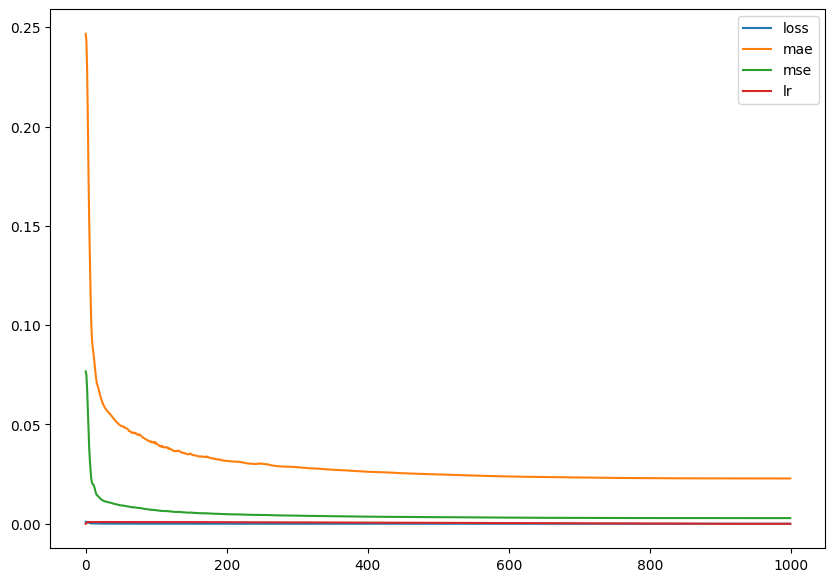

In [ ]:
if experiment['TYPE'] == 'train':
  pd.DataFrame(autoencoder_model_hist.history).plot(figsize=(10, 7))

### Run model in Inference mode - Prediction

In [ ]:
def predict_perpdiff(dataset, ds_imgs, model):
  vgg19_perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [vgg19_perp_model.layers[i].output for i in [12]]  # Set 12th layer for the model output layer
  vgg19_perp_model = Model(vgg19_perp_model.inputs, modelOutputs)

  for ds_imgs in dataset.take(1):
    input_imgs = ds_imgs[0].numpy()

    # Predict the reconstructed image
    y_pred = model.predict(input_imgs)

    # Resize the images to the input size of VGG19
    y_true_reshape = tf.image.resize(input_imgs, (224, 224))
    y_pred_reshape = tf.image.resize(y_pred, (224, 224))
    mask1_reshape = tf.image.resize(ds_imgs[1], (224, 224))
    # mask2_reshape = tf.image.resize(ds_imgs[2], (224, 224))

    # Pass all images in the VGG19 and get the perceptual layers outputs
    perp_input = vgg19_perp_model([y_true_reshape])
    perp_pred = vgg19_perp_model([y_pred_reshape])

  # return y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred
  return y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred

In [ ]:
def compute_min_max(perp_input, perp_pred):
  print("Computing min and max...")
  max_norm = 0
  min_norm = 1000000

  for img_idx in range(perp_input.shape[0]):
    perp_img = tf.math.abs( perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0] )

    for i in range(1, perp_input.shape[3] ):
      perp_img += tf.math.abs( perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i] )
      max_value = tf.math.reduce_max(perp_img)
      min_value = tf.math.reduce_min(perp_img)

      if max_value > max_norm:
        max_norm = max_value
      if min_value < min_norm:
        min_norm = min_value

  print("max_norm: {}".format(max_norm))
  print("min_norm: {}".format(min_norm))

  return min_norm, max_norm

In [ ]:
def calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm):
  y_pred_all = []
  all_perp = []

  print("Calculating anomaly map")
  for img_idx in range(perp_input.shape[0]):
      perp_img = tf.math.abs(perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0])
      for i in range(1, perp_input.shape[3] ):
        perp_img += tf.math.abs(perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i])

      perp_img =(perp_img - min_norm) / (max_norm - min_norm)

      perp_img = tf.image.resize(tf.expand_dims(perp_img, axis=2), (224,224))
      perp_img = tf.squeeze(perp_img)

      all_perp.append(perp_img)
      y_pred_all.append( perp_img.numpy().ravel() )

  return all_perp, y_pred_all

In [ ]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

In [ ]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

Load trained weights

In [ ]:
if experiment['TYPE'] == 'test':
  autoencoder_model.load_weights('/content/drive/MyDrive/MASTER/Master_Thesis/Google_Colab_Workspace/BD67_weights/weights_data_aug_True_bath_size_16_epochs_1000_loss_mse_perc/best_model_val_loss.h5')

Run the model in Inference mode and try it on training data

### Generate Images from Training Data

3/3 [==============================] - 17s 6s/step


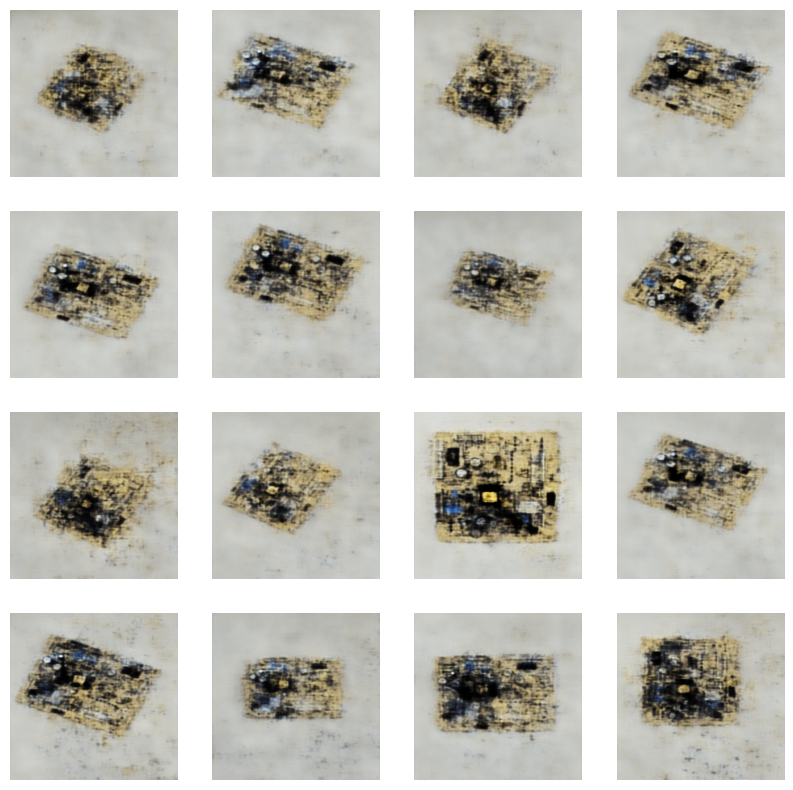

In [ ]:
generated_train_data = autoencoder_model.predict(train_dataset_part)

show_generated_images(generated_train_data)

In [ ]:
train_batch, _ = next(iter(train_dataset_part))

display_pixel_wise_img_diff(train_batch[0], generated_train_data[0], threshold=0.8, channel=0, verbose=1)

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(train_dataset, train_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

### Generate Images from Validation Data

In [ ]:
generated_valid_data = autoencoder_model.predict(valid_dataset_part)

show_generated_images(generated_valid_data)

In [ ]:
valid_batch, _ = next(iter(valid_dataset_part))

display_pixel_wise_img_diff(valid_batch[1], generated_valid_data[1], threshold=0.8, channel=0, verbose=1)

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(valid_dataset_part, valid_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

1/1 [==============================] - 11s 11s/step


Exception ignored in: <function Executor.__del__ at 0x79cc5c19beb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Computing min and max...


Create Test Dataset

In [ ]:
import glob
test_dataset = create_dataset_pipeline(BD67_DEFECTED_FRONT_PATH)

### Generate Images from Testing Data

In [ ]:
generated_test_data = autoencoder_model.predict(test_dataset)

show_generated_images(generated_test_data)

In [ ]:
test_batch, _ = next(iter(test_dataset))

display_pixel_wise_img_diff(test_batch[1], generated_test_data[1], threshold=0.6, channel=0, verbose=1)

In [ ]:
# Predict all images
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(test_dataset, test_dataset, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)